In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
from numpy.linalg import LinAlgError

In [2]:
def uniform_hypersphere(d, sigma=1.):
    # sample a point uniformly from d-1 sphere of radius sigma
    x = np.random.randn(d)
    x /= np.linalg.norm(x)
    x *= sigma
    return x

def isotropic_gaussian(d, sigma=1.):
    # sample a point from N(0, I_d * sigma_2^2)
    x = np.random.randn(d)
    x *= sigma
    return x

In [3]:
def y_sample(D, c, X, eps=0.):
    noise = np.random.normal(size=X.shape[0]) * eps
    y = X @ (D @ c) + noise # no noise added
    return y

def X_sample(n, d, distribution_sample, device='cpu'):
    # a n \times d matrix with each row sampled according to function distribution_sample
    X = []
    for i in range(n):
        X.append(distribution_sample(d))
    X = np.array(X)
    if device=='cuda':
        return torch.FloatTensor(X).cuda()
    return X

def c_sample(k, distribution_sample, device='cpu'):
    # a k dimensional vector sampled according to distribution_sample
    c = distribution_sample(k) 
    if device=='cuda':
        return torch.FloatTensor(c).cuda()
    return c

def add_noise(D, eps=0.0):
    return np.random.uniform(-eps, eps, size=D.shape) + D

In [4]:
def task_c_loss_gradient_with_query(X, y, D, X2=None, y2=None, lambd=0., device='cpu'):
    
    if X2 is None:
        X2 = X
        y2 = y
        
    n = X.shape[0]
    p = n
    if device == 'cuda':
        inv = torch.inverse
        outer = torch.ger
        norm = torch.norm
        I = torch.eye(p, p).cuda()
    else:
        inv = np.linalg.inv
        norm = np.linalg.norm
        outer = np.multiply.outer
        I = np.eye(p, p)
    
    # if model is over-parameterized, use Woodburry Identity 
    # ||(X2DD.TX.T*(XDD.TX.T+lambd*eye)^{-1}y-y2)||^2
#     print(X.shape, X2.shape, D.shape, y.shape, y2.shape)
    A = X @ D # n x k
    A2 = X2 @ D # n2 x k
    AT = A.T # k x n
    A2T = A2.T # k x n2

    AAT = A @ A.T # n x n
    try:
        S = inv(AAT + (lambd * I)) # T_0   # n x n
    except LinAlgError:
        print(AAT, lambd, I)
        raise LinAlgError 
    
    Sy = S @ y # n x 1
    XTSy = (X.T) @ Sy # t_1 (d x 1)
    c_solved = D.T @ XTSy # k x 1

    pred = A2 @ c_solved # n2 x 1
    err = (pred - y2) # t_2 (n2 x 1)
    
    ATSy = AT @ Sy # t_3 (k x 1)
    X2Terr = X2.T @ err  # t_4 d x 1
    A2Terr = A2T @ err # t_5
    SAA2Terr = S @ (A @ A2Terr)

    functionValue = (norm(err) ** 2)
    gradient = (2 * outer(X2Terr, ATSy))\
            + (2 * outer(XTSy, A2Terr))\
            - (2 * outer(X.T @ SAA2Terr, ATSy))\
            - (2 * outer(XTSy, A.T @ SAA2Terr))


    return c_solved, functionValue / n, gradient / n

In [5]:
def task_c_loss_gradient_without_query(X, y, D, lambd=0., device='cpu'):
    
    n = X.shape[0]
    k = D.shape[1]
    p = min(n,k)
    if device == 'cuda':
        inv = torch.inverse
        outer = torch.ger
        norm = torch.norm
        I = torch.eye(p, p).cuda()
    else:
        inv = np.linalg.inv
        norm = np.linalg.norm
        outer = np.multiply.outer
        I = np.eye(p, p)
    
    # if model is over-parameterized, use Woodburry Identity 
    # ||(XDD.TX.T*(XDD.TX.T+lambd*eye)^{-1}y-y)||^2
    if n < k:
        A = X @ D # n x k
        AT = A.T # k x n
        AAT = A @ A.T # n x n
        S = inv(AAT + (lambd * I)) # T_0   # n x n
        Sy = S @ y # n x 1
        XTSy = (X.T) @ Sy # t_1 (d x 1)
        c_solved = D.T @ XTSy # k x 1
        pred = AAT @ Sy # n x 1
        err = (pred - y) # t_2 (n x 1)
        ATSy = AT @ Sy # t_3 (k x 1)
        XTerr = X.T @ err  # t_4 d x 1
        ATerr = AT @ err
        SAATerr = S @ (A @ ATerr)

        functionValue = (norm(err) ** 2)
        gradient = (2 * outer(XTerr, ATSy))\
                + (2 * outer(XTSy, ATerr))\
                - (2 * outer(X.T @ SAATerr, ATSy))\
                - (2 * outer(XTSy, A.T @ SAATerr))

    else:    
        # ||((D.TX.TXD+lambd*eye)^{-1}D.TX.Ty-y)||^2
        S = inv((D.T@X.T)@(X@D) + (lambd * I))
        XTy = (X.T) @ y
        DTXTy = D.T @ XTy
        c_solved = S @ (DTXTy)
        pred = X @ (D @ c_solved)
        S_1 = (pred - y)
        S_2 = X.T @ S_1
        S_3 = S @ D.T @ X.T @ S_1

        functionValue = (norm(S_1) ** 2)
        gradient = 2 * (outer(S_2, c_solved))\
                    - 2* ((outer(X.T @ pred, S_3)) + (outer((X.T @ (X @ (D @ (S @ (D.T @ S_2))))), c_solved)))\
                    + (2 * outer(XTy, S_3))

    return c_solved, functionValue / n, gradient / n



In [16]:
def train_without_query(n, d, k_actual, D_true, D_test, D_init, X_pool, fixS, m, c_pool, lambd, lr, num_iterations_train, test_frequency, device, batchsz):
    D = D_init
    num_iterations = num_iterations_train
    avg_train_loss = []
    avg_test_loss = []
    grads = []
    if fixS:
        print("Running with fixSupport of size", m)
        train_X_pool = X_pool[:m]
    else:
        train_X_pool = X_pool
        
    for iteration in tqdm(range(1, num_iterations+1)):
        X = train_X_pool[np.random.choice(len(train_X_pool))]
        c = c_pool[np.random.choice(len(c_pool))]
        y = y_sample(D=D_true, c=c, X=X, eps=0.)
        c_solved, loss, gradient = task_c_loss_gradient_without_query(X=X, y=y, D=D, lambd=lambd, device=device)
        grads.append(gradient)
        
        # batch update
        if iteration % batchsz == 0:
            D = D - lr * np.mean(grads, 0) # update the loss
            grads = []
            
        if iteration % test_frequency == 0: # evaluation
            sum_train_loss = 0.
            sum_test_loss = 0.0
            n_test = 500
            n_train = 500
            
            # First we evaluate on the ML objective (on the base classes)
            for i in range(n_train):
                X = X_pool[np.random.choice(len(X_pool))]
                c = c_pool[np.random.choice(len(c_pool))]
                y = y_sample(D=D_true, c=c, X=X, eps=0.)
                c_solved, loss, gradient = task_c_loss_gradient_without_query(X=X, y=y, D=D, lambd=lambd, device=device)
                sum_train_loss += loss
            avg_train_loss.append(sum_train_loss / n_train)
            
            # Then we evaluate on the ML objective (on the novel classes)
            for i in range(n_test):
                X_sigma_vec=[1./(np.linalg.norm(D_true[i, :])*np.sqrt(d)) for i in range(d)]
                X = np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n)])
                c = isotropic_gaussian(k_actual)
                y = y_sample(D=D_test, c=c, X=X, eps=0.)
                c_solved, loss, gradient = task_c_loss_gradient_without_query(X=X, y=y, D=D, lambd=lambd, device=device)
                sum_test_loss += loss
            avg_test_loss.append(sum_test_loss / n_test)
            
    return avg_train_loss, avg_test_loss, D
        


In [38]:
def train_with_query(n, n2, d, k_actual, D_true, D_test, D_init, X_pool, fixS, m, Xq_pool, c_pool, lambd, lr, num_iterations_train, test_frequency, device, batchsz):
    D = D_init
    num_iterations = num_iterations_train
    avg_train_loss = []
    avg_test_loss = []
    grads = []
    if fixS:
        print("Running with fixSupport of size", m)
        train_X_pool = X_pool[:m]
    else:
        train_X_pool = X_pool
     
    for iteration in tqdm(range(1, num_iterations+1)):
        X = train_X_pool[np.random.choice(len(train_X_pool))]
        Xq = Xq_pool[np.random.choice(len(Xq_pool))]
        c = c_pool[np.random.choice(len(c_pool))]
        y = y_sample(D=D_true, c=c, X=X, eps=0.)
        yq = y_sample(D=D_true, c=c, X=Xq, eps=0.)
        c_solved, loss, gradient = task_c_loss_gradient_with_query(X=X, y=y, D=D, X2=Xq, y2=yq, lambd=lambd, device=device)
        grads.append(gradient)
        
        # batch update
        if iteration % batchsz == 0:
            D = D - lr * np.mean(grads, 0) # update the loss
            grads = []
            
        if iteration % test_frequency == 0: # test evaluation
            sum_train_loss = 0.
            sum_test_loss = 0.
            n_test = 500
            n_train = 500
            
            # First we evaluate on the ML objective (on the base classes)
            for i in range(n_train):
                X = X_pool[np.random.choice(len(X_pool))]
                Xq = Xq_pool[np.random.choice(len(Xq_pool))]
                c = c_pool[np.random.choice(len(c_pool))]
                y = y_sample(D=D_true, c=c, X=X, eps=0.)
                yq = y_sample(D=D_true, c=c, X=Xq, eps=0.)
                c_solved, loss, gradient = task_c_loss_gradient_with_query(X=X, y=y, D=D, X2=Xq, y2=yq, lambd=lambd, device=device)
                sum_train_loss += loss
            avg_train_loss.append(sum_train_loss / n_train)
            
            # Then we evaluate on the ML objective (on the novel classes)
            for i in range(n_test):
                X_sigma_vec=[1./(np.linalg.norm(D_true[i, :])*np.sqrt(d)*2.) for i in range(d)]
                X = X_pool[np.random.choice(len(X_pool))]
#                 X = np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n)])
                Xq = np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n2)])
                c = isotropic_gaussian(k_actual)
                y = y_sample(D=D_test, c=c, X=X)
                yq = y_sample(D=D_test, c=c, X=Xq)
                c_solved, loss, gradient = task_c_loss_gradient_with_query(X=X, y=y, D=D, X2=Xq, y2=yq, lambd=lambd, device=device)
                sum_test_loss += loss
            avg_test_loss.append(sum_test_loss / n_test)
            
    return avg_train_loss, avg_test_loss, D

### Possible ranges to experiment on:

In [39]:
##########################################################################################################
# X_distribution: uniform hyper-sphere [norm=1.]
# c_distribution: [uniform hyper-sphere (possibly scaled by constant), iso-tropic gaussian]
# may D shd be orthogonal matrix (the set of orthogonal matrices is non-cvx)
# d: [50, 100, 200]
# k: [5, 10, 30]
# k_hat: [5, 20, 50]
# lambda: [0.01, 1., 10.]
# n, n2: 5, 15
# shift: throw away 0 to k/2 columns
# w* = D*c*
# If D has orthogonal columns and c is smapled from uniform hype then we end up getting hyper-ellipse
##########################################################################################################

## -----------------------------------------------------------------------------------------------------------

  0%|          | 396/400000 [00:00<01:40, 3956.49it/s]

Running with fixSupport of size 20


100%|██████████| 400000/400000 [02:26<00:00, 2739.54it/s]


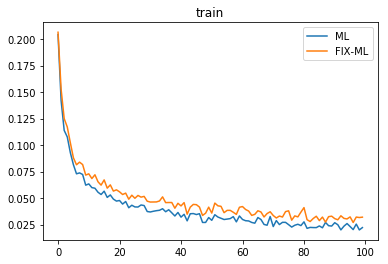

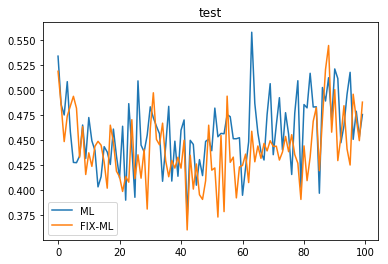

In [47]:
# THIS IS A TYPICAL RUN ###########

# Set parameters
n = 5 # number of support examples per task
n2 = 15 # number of query examples per task
d = 50 # ambient dimension
k = 5 # actual subspace dimension of the weights (used in data generation)  
k_hat = 50 # subspace dimension we learn (used in prediction)
T = 5 # total number of tasks
M = 10000 # total number of X matrix of shape n \times d
m = 20 # no of support sets in fixml
lr = 0.1 # learning rate for learning D
num_iterations_train = 400000 # no of train_iterations
test_frequency = 4000 # no of iterations after which we test
batchsz = 1
lambd = 10. # inner loop regularizer
device = 'cpu' # cuda uses GPU, cpu option would only perform operations on np arrays
seed = 9127
np.random.seed(seed) # set seed

        
# obtain meta-learning and fix-meta learning solns
D_true = np.stack([isotropic_gaussian(d) for _ in range(k)], axis=0).T
D_true = np.linalg.qr(D_true)[0]
D_init = np.random.randn(d, k_hat) / np.sqrt(d) # he init
D_test = D_true
# D_test = np.concatenate([D_true[:, :-1], np.random.randn(d, 1)], axis=1)


# Get Dataset

X_sigma_vec=[1./(np.linalg.norm(D_true[i, :])*np.sqrt(d)*2.) for i in range(d)]
X_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n)]) for i in range(M)]
Xq_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n2)]) for i in range(M)]
c_pool = [isotropic_gaussian(k) for i in range(T)]


if device == 'cuda':
    D_true = torch.FloatTensor(D_true).cuda()
    D_init = torch.FloatTensor(D_init).cuda()
    D_test = torch.FloatTensor(D_test).cuda()


np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
metal_avg_train_loss, metal_avg_test_loss, D_ML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=False, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)
np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
fix_metal_avg_train_loss, fix_metal_avg_test_loss, D_FIXML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=True, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)

# plots
plt.plot(list(range(len(metal_avg_train_loss))), metal_avg_train_loss, label='ML')
plt.plot(list(range(len(fix_metal_avg_train_loss))), fix_metal_avg_train_loss, label='FIX-ML')
plt.title('train')
plt.legend()
plt.show()

plt.plot(list(range(num_iterations_train // test_frequency)), metal_avg_test_loss, label='ML')
plt.plot(list(range(num_iterations_train // test_frequency)), fix_metal_avg_test_loss, label='FIX-ML')
plt.title('test')
plt.legend()
plt.show()

  0%|          | 402/400000 [00:00<01:39, 4017.21it/s]

Running with fixSupport of size 20


100%|██████████| 400000/400000 [02:28<00:00, 2701.31it/s]


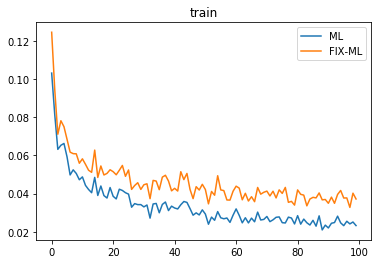

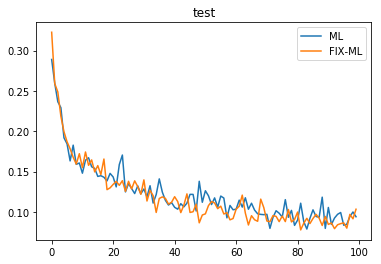

In [48]:
# THIS IS A TYPICAL RUN ###########

# Set parameters
n = 5 # number of support examples per task
n2 = 15 # number of query examples per task
d = 50 # ambient dimension
k = 5 # actual subspace dimension of the weights (used in data generation)  
k_hat = 50 # subspace dimension we learn (used in prediction)
T = 7 # total number of tasks
M = 10000 # total number of X matrix of shape n \times d
m = 20 # no of support sets in fixml
lr = 0.1 # learning rate for learning D
num_iterations_train = 400000 # no of train_iterations
test_frequency = 4000 # no of iterations after which we test
batchsz = 1
lambd = 1. # inner loop regularizer
device = 'cpu' # cuda uses GPU, cpu option would only perform operations on np arrays
seed = 9127
np.random.seed(seed) # set seed

        
# obtain meta-learning and fix-meta learning solns
D_true = np.stack([isotropic_gaussian(d) for _ in range(k)], axis=0).T
D_true = np.linalg.qr(D_true)[0]
D_init = np.random.randn(d, k_hat) / np.sqrt(d) # he init
D_test = D_true
# D_test = np.concatenate([D_true[:, :-1], np.random.randn(d, 1)], axis=1)


# Get Dataset

X_sigma_vec=[1./(np.linalg.norm(D_true[i, :])*np.sqrt(d)*2.) for i in range(d)]
X_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n)]) for i in range(M)]
Xq_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n2)]) for i in range(M)]
c_pool = [isotropic_gaussian(k) for i in range(T)]


if device == 'cuda':
    D_true = torch.FloatTensor(D_true).cuda()
    D_init = torch.FloatTensor(D_init).cuda()
    D_test = torch.FloatTensor(D_test).cuda()


np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
metal_avg_train_loss, metal_avg_test_loss, D_ML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=False, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)
np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
fix_metal_avg_train_loss, fix_metal_avg_test_loss, D_FIXML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=True, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)

# plots
plt.plot(list(range(len(metal_avg_train_loss))), metal_avg_train_loss, label='ML')
plt.plot(list(range(len(fix_metal_avg_train_loss))), fix_metal_avg_train_loss, label='FIX-ML')
plt.title('train')
plt.legend()
plt.show()

plt.plot(list(range(num_iterations_train // test_frequency)), metal_avg_test_loss, label='ML')
plt.plot(list(range(num_iterations_train // test_frequency)), fix_metal_avg_test_loss, label='FIX-ML')
plt.title('test')
plt.legend()
plt.show()

  0%|          | 413/400000 [00:00<01:36, 4122.96it/s]

Running with fixSupport of size 20


100%|██████████| 400000/400000 [02:24<00:00, 2761.84it/s]


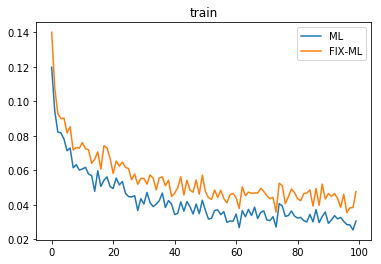

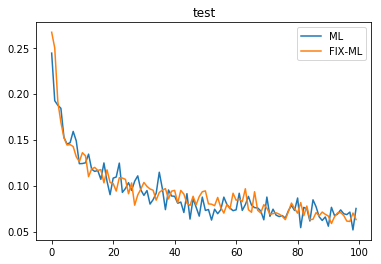

In [49]:
# THIS IS A TYPICAL RUN ###########

# Set parameters
n = 5 # number of support examples per task
n2 = 15 # number of query examples per task
d = 50 # ambient dimension
k = 5 # actual subspace dimension of the weights (used in data generation)  
k_hat = 50 # subspace dimension we learn (used in prediction)
T = 10 # total number of tasks
M = 10000 # total number of X matrix of shape n \times d
m = 20 # no of support sets in fixml
lr = 0.1 # learning rate for learning D
num_iterations_train = 400000 # no of train_iterations
test_frequency = 4000 # no of iterations after which we test
batchsz = 1
lambd = 1. # inner loop regularizer
device = 'cpu' # cuda uses GPU, cpu option would only perform operations on np arrays
seed = 9127
np.random.seed(seed) # set seed

        
# obtain meta-learning and fix-meta learning solns
D_true = np.stack([isotropic_gaussian(d) for _ in range(k)], axis=0).T
D_true = np.linalg.qr(D_true)[0]
D_init = np.random.randn(d, k_hat) / np.sqrt(d) # he init
D_test = D_true
# D_test = np.concatenate([D_true[:, :-1], np.random.randn(d, 1)], axis=1)


# Get Dataset

X_sigma_vec=[1./(np.linalg.norm(D_true[i, :])*np.sqrt(d)*2.) for i in range(d)]
X_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n)]) for i in range(M)]
Xq_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n2)]) for i in range(M)]
c_pool = [isotropic_gaussian(k) for i in range(T)]


if device == 'cuda':
    D_true = torch.FloatTensor(D_true).cuda()
    D_init = torch.FloatTensor(D_init).cuda()
    D_test = torch.FloatTensor(D_test).cuda()


np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
metal_avg_train_loss, metal_avg_test_loss, D_ML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=False, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)
np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
fix_metal_avg_train_loss, fix_metal_avg_test_loss, D_FIXML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=True, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)

# plots
plt.plot(list(range(len(metal_avg_train_loss))), metal_avg_train_loss, label='ML')
plt.plot(list(range(len(fix_metal_avg_train_loss))), fix_metal_avg_train_loss, label='FIX-ML')
plt.title('train')
plt.legend()
plt.show()

plt.plot(list(range(num_iterations_train // test_frequency)), metal_avg_test_loss, label='ML')
plt.plot(list(range(num_iterations_train // test_frequency)), fix_metal_avg_test_loss, label='FIX-ML')
plt.title('test')
plt.legend()
plt.show()


 11%|█         | 43820/400000 [00:18<01:54, 3122.29it/s]


 22%|██▏       | 87616/400000 [00:37<01:40, 3112.97it/s]


 32%|███▏      | 128223/400000 [00:57<04:02, 1122.76it/s]


 42%|████▏     | 169440/400000 [01:16<01:39, 2313.69it/s]


 53%|█████▎    | 212685/400000 [01:35<01:40, 1854.89it/s]


 63%|██████▎   | 253096/400000 [01:54<01:17, 1887.57it/s]


 74%|███████▍  | 296453/400000 [02:13<01:02, 1657.17it/s]


 84%|████████▍ | 337261/400000 [02:32<00:29, 2133.45it/s]


 95%|█████████▌| 380750/400000 [02:51<00:10, 1832.49it/s]


100%|██████████| 400000/400000 [02:59<00:00, 2228.86it/s]

  0%|          | 332/400000 [00:00<02:00, 3317.93it/s]

Running with fixSupport of size 20



 11%|█         | 44867/400000 [00:19<03:11, 1858.84it/s]


 22%|██▏       | 89253/400000 [00:38<02:24, 2150.26it/s]


 34%|███▎      | 134106/400000 [00:57<01:36, 2762.67it/s]


 44%|████▍     | 177842/400000 [01:16<01:25, 2595.10it/s]


 55%|█████▌    | 221672/400000 [01:35<01:08, 2606.43it/s]


 66%|██████▋   | 265759/400000 [01:54<00:51, 2595.80it/s]


 78%|███████▊  | 310083/400000 [02:12<00:32, 2779.58it/s]


 89%|████████▊ | 354340/400000 [02:31<00:15, 2940.17it/s]


100%|█████████▉| 398035/400000 [02:50<00:00, 2701.84it/s]


100%|██████████| 400000/400000 [02:51<00:00, 2327.46it/s]


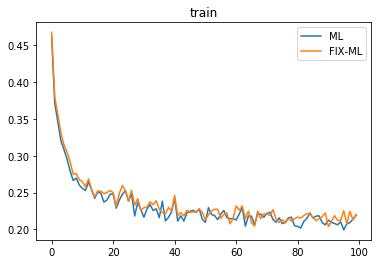

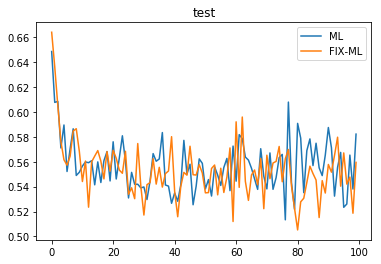

In [52]:
# THIS IS A TYPICAL RUN ###########

# Set parameters
n = 5 # number of support examples per task
n2 = 15 # number of query examples per task
d = 50 # ambient dimension
k = 10 # actual subspace dimension of the weights (used in data generation)  
k_hat = 100 # subspace dimension we learn (used in prediction)
T = 15 # total number of tasks
M = 10000 # total number of X matrix of shape n \times d
m = 20 # no of support sets in fixml
lr = 0.1 # learning rate for learning D
num_iterations_train = 400000 # no of train_iterations
test_frequency = 4000 # no of iterations after which we test
batchsz = 1
lambd = 10. # inner loop regularizer
device = 'cpu' # cuda uses GPU, cpu option would only perform operations on np arrays
seed = 9127
np.random.seed(seed) # set seed

        
# obtain meta-learning and fix-meta learning solns
D_true = np.stack([isotropic_gaussian(d) for _ in range(k)], axis=0).T
D_true = np.linalg.qr(D_true)[0]
D_init = np.random.randn(d, k_hat) / np.sqrt(d) # he init
D_test = D_true
# D_test = np.concatenate([D_true[:, :-1], np.random.randn(d, 1)], axis=1)


# Get Dataset

X_sigma_vec=[1./(np.linalg.norm(D_true[i, :])*np.sqrt(d)*2.) for i in range(d)]
X_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n)]) for i in range(M)]
Xq_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n2)]) for i in range(M)]
c_pool = [isotropic_gaussian(k) for i in range(T)]


if device == 'cuda':
    D_true = torch.FloatTensor(D_true).cuda()
    D_init = torch.FloatTensor(D_init).cuda()
    D_test = torch.FloatTensor(D_test).cuda()


np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
metal_avg_train_loss, metal_avg_test_loss, D_ML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=False, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)
np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
fix_metal_avg_train_loss, fix_metal_avg_test_loss, D_FIXML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=True, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)

# plots
plt.plot(list(range(len(metal_avg_train_loss))), metal_avg_train_loss, label='ML')
plt.plot(list(range(len(fix_metal_avg_train_loss))), fix_metal_avg_train_loss, label='FIX-ML')
plt.title('train')
plt.legend()
plt.show()

plt.plot(list(range(num_iterations_train // test_frequency)), metal_avg_test_loss, label='ML')
plt.plot(list(range(num_iterations_train // test_frequency)), fix_metal_avg_test_loss, label='FIX-ML')
plt.title('test')
plt.legend()
plt.show()


 11%|█         | 42392/400000 [00:19<02:12, 2697.28it/s]


 21%|██        | 84625/400000 [00:38<03:06, 1691.59it/s]


 31%|███▏      | 125624/400000 [00:58<01:50, 2487.80it/s]


 42%|████▏     | 166641/400000 [01:17<01:25, 2736.98it/s]


 52%|█████▏    | 206862/400000 [01:36<01:03, 3038.43it/s]


 63%|██████▎   | 251558/400000 [01:55<00:46, 3181.67it/s]


 74%|███████▎  | 294609/400000 [02:14<00:35, 2985.25it/s]


 84%|████████▍ | 337915/400000 [02:33<00:23, 2630.47it/s]


 95%|█████████▍| 379203/400000 [02:52<00:07, 2864.64it/s]


100%|██████████| 400000/400000 [03:02<00:00, 2192.37it/s]

  0%|          | 306/400000 [00:00<02:11, 3051.03it/s]

Running with fixSupport of size 20



 10%|█         | 41465/400000 [00:19<02:49, 2117.62it/s]


 21%|██        | 83184/400000 [00:38<01:41, 3107.97it/s]


 32%|███▏      | 127085/400000 [00:57<01:30, 3030.22it/s]


 42%|████▏     | 169757/400000 [01:16<01:30, 2543.64it/s]


 53%|█████▎    | 212440/400000 [01:35<02:23, 1305.54it/s]


 63%|██████▎   | 252997/400000 [01:54<01:12, 2038.18it/s]


 74%|███████▍  | 296494/400000 [02:13<01:05, 1577.53it/s]


 85%|████████▍ | 339821/400000 [02:32<00:19, 3131.45it/s]


 96%|█████████▌| 382958/400000 [02:51<00:05, 3036.00it/s]


100%|██████████| 400000/400000 [02:59<00:00, 2232.67it/s]


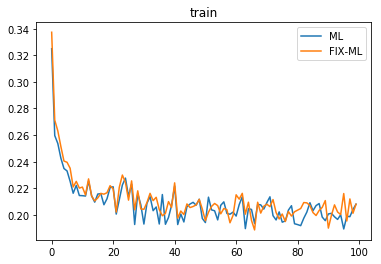

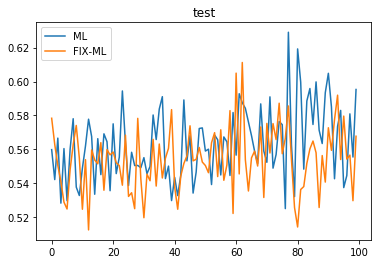

In [53]:
# THIS IS A TYPICAL RUN ###########

# Set parameters
n = 5 # number of support examples per task
n2 = 15 # number of query examples per task
d = 50 # ambient dimension
k = 10 # actual subspace dimension of the weights (used in data generation)  
k_hat = 100 # subspace dimension we learn (used in prediction)
T = 15 # total number of tasks
M = 10000 # total number of X matrix of shape n \times d
m = 20 # no of support sets in fixml
lr = 0.1 # learning rate for learning D
num_iterations_train = 400000 # no of train_iterations
test_frequency = 4000 # no of iterations after which we test
batchsz = 1
lambd = 2. # inner loop regularizer
device = 'cpu' # cuda uses GPU, cpu option would only perform operations on np arrays
seed = 9127
np.random.seed(seed) # set seed

        
# obtain meta-learning and fix-meta learning solns
D_true = np.stack([isotropic_gaussian(d) for _ in range(k)], axis=0).T
D_true = np.linalg.qr(D_true)[0]
D_init = np.random.randn(d, k_hat) / np.sqrt(d) # he init
D_test = D_true
# D_test = np.concatenate([D_true[:, :-1], np.random.randn(d, 1)], axis=1)


# Get Dataset

X_sigma_vec=[1./(np.linalg.norm(D_true[i, :])*np.sqrt(d)*2.) for i in range(d)]
X_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n)]) for i in range(M)]
Xq_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n2)]) for i in range(M)]
c_pool = [isotropic_gaussian(k) for i in range(T)]


if device == 'cuda':
    D_true = torch.FloatTensor(D_true).cuda()
    D_init = torch.FloatTensor(D_init).cuda()
    D_test = torch.FloatTensor(D_test).cuda()


np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
metal_avg_train_loss, metal_avg_test_loss, D_ML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=False, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)
np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
fix_metal_avg_train_loss, fix_metal_avg_test_loss, D_FIXML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=True, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)

# plots
plt.plot(list(range(len(metal_avg_train_loss))), metal_avg_train_loss, label='ML')
plt.plot(list(range(len(fix_metal_avg_train_loss))), fix_metal_avg_train_loss, label='FIX-ML')
plt.title('train')
plt.legend()
plt.show()

plt.plot(list(range(num_iterations_train // test_frequency)), metal_avg_test_loss, label='ML')
plt.plot(list(range(num_iterations_train // test_frequency)), fix_metal_avg_test_loss, label='FIX-ML')
plt.title('test')
plt.legend()
plt.show()


  4%|▎         | 14326/400000 [00:19<07:29, 858.37it/s]


  7%|▋         | 28718/400000 [00:39<09:04, 682.46it/s]


 11%|█         | 43085/400000 [00:59<06:20, 938.37it/s]


 14%|█▍        | 57082/400000 [01:20<06:53, 828.97it/s]


 18%|█▊        | 71374/400000 [01:39<05:20, 1024.23it/s]


 21%|██▏       | 85574/400000 [02:00<05:31, 949.78it/s]


 25%|██▍       | 99436/400000 [02:19<05:14, 956.33it/s]


 28%|██▊       | 113209/400000 [02:40<05:31, 864.78it/s]


 32%|███▏      | 127412/400000 [03:00<05:08, 883.47it/s]


 35%|███▌      | 140800/400000 [03:21<06:18, 685.39it/s]


 39%|███▊      | 154399/400000 [03:40<03:54, 1046.70it/s]


 42%|████▏     | 168569/400000 [04:01<06:37, 581.71it/s]


 46%|████▌     | 182792/400000 [04:20<03:28, 1041.39it/s]


 49%|████▉     | 197090/400000 [04:41<04:12, 803.67it/s]


 53%|█████▎    | 211002/400000 [04:59<03:09, 995.14it/s] 


 56%|█████▋    | 225070/400000 [05:21<04:29, 649.54it/s]


 60%|█████▉    | 239060/400000 [05:40<02:34, 1038.64it/s]


 63%|██████▎   | 252338/400000 [06:02<07:25, 331.78it/s]


 66%|██████▋   | 265624/400000 [06:22<02:33, 873.55it/s]


 70%|██████▉   | 278338/400000 [06:42<02:44, 741.78it/s]


 73%|███████▎  | 292072/400000 [07:03<09:15, 194.19it/s]


 76%|███████▋  | 305989/400000 [07:23<01:31, 1028.26it/s]


 80%|████████  | 320200/400000 [07:43<04:14, 313.54it/s]


 84%|████████▎ | 334459/400000 [08:02<01:04, 1022.65it/s]


 87%|████████▋ | 348501/400000 [08:23<01:50, 467.50it/s]


 91%|█████████ | 362850/400000 [08:42<00:36, 1010.08it/s]


 94%|█████████▍| 377020/400000 [09:02<00:28, 818.06it/s]


 98%|█████████▊| 390171/400000 [09:23<00:12, 763.09it/s]


100%|██████████| 400000/400000 [09:40<00:00, 689.45it/s]

  0%|          | 100/400000 [00:00<06:43, 991.05it/s]

Running with fixSupport of size 20



  4%|▎         | 14759/400000 [00:19<06:11, 1036.78it/s]


  7%|▋         | 28824/400000 [00:40<08:58, 689.43it/s]


 11%|█         | 42663/400000 [01:00<06:09, 966.35it/s] 


 14%|█▍        | 56945/400000 [01:21<07:24, 771.42it/s]


 18%|█▊        | 71231/400000 [01:41<05:29, 998.02it/s]


 21%|██▏       | 85560/400000 [02:02<05:31, 948.41it/s]


 25%|██▍       | 99506/400000 [02:21<05:15, 951.02it/s]


 28%|██▊       | 113096/400000 [02:43<07:16, 657.12it/s]


 32%|███▏      | 127053/400000 [03:02<05:42, 795.99it/s]


 35%|███▍      | 139862/400000 [03:22<04:30, 963.24it/s]


 39%|███▊      | 154079/400000 [03:42<04:09, 987.29it/s] 


 42%|████▏     | 168331/400000 [04:03<10:23, 371.53it/s]


 46%|████▌     | 182649/400000 [04:22<03:42, 978.03it/s]


 49%|████▉     | 196821/400000 [04:42<04:33, 742.69it/s]


 53%|█████▎    | 210939/400000 [05:01<03:54, 804.57it/s]


 56%|█████▌    | 224170/400000 [05:23<13:30, 217.03it/s]


 59%|█████▉    | 237775/400000 [05:42<02:48, 961.20it/s]


 63%|██████▎   | 251819/400000 [06:01<02:34, 960.42it/s]


 66%|██████▋   | 265933/400000 [06:22<02:09, 1033.00it/s]


 70%|███████   | 280206/400000 [06:43<08:19, 239.85it/s]


 74%|███████▎  | 294268/400000 [07:02<01:42, 1033.75it/s]


 77%|███████▋  | 308432/400000 [07:23<03:08, 486.04it/s]


 81%|████████  | 322549/400000 [07:42<01:34, 821.89it/s]


 84%|████████▍ | 336801/400000 [08:03<01:36, 651.64it/s]


 88%|████████▊ | 350956/400000 [08:22<00:51, 951.12it/s]


 91%|█████████ | 363954/400000 [08:42<00:49, 733.67it/s]


 94%|█████████▍| 377228/400000 [09:04<00:26, 873.39it/s]


 98%|█████████▊| 391000/400000 [09:23<00:08, 1058.30it/s]


100%|██████████| 400000/400000 [09:36<00:00, 693.44it/s] 


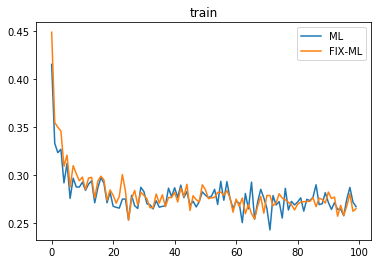

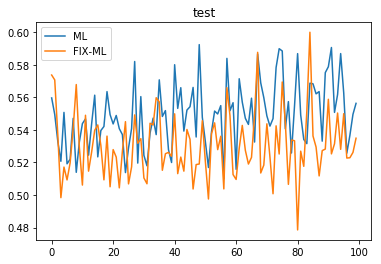

In [54]:
# THIS IS A TYPICAL RUN ###########

# Set parameters
n = 5 # number of support examples per task
n2 = 15 # number of query examples per task
d = 50 # ambient dimension
k = 10 # actual subspace dimension of the weights (used in data generation)  
k_hat = 200 # subspace dimension we learn (used in prediction)
T = 15 # total number of tasks
M = 10000 # total number of X matrix of shape n \times d
m = 20 # no of support sets in fixml
lr = 0.1 # learning rate for learning D
num_iterations_train = 400000 # no of train_iterations
test_frequency = 4000 # no of iterations after which we test
batchsz = 1
lambd = 2. # inner loop regularizer
device = 'cpu' # cuda uses GPU, cpu option would only perform operations on np arrays
seed = 9127
np.random.seed(seed) # set seed

        
# obtain meta-learning and fix-meta learning solns
D_true = np.stack([isotropic_gaussian(d) for _ in range(k)], axis=0).T
D_true = np.linalg.qr(D_true)[0]
D_init = np.random.randn(d, k_hat) / np.sqrt(d) # he init
D_test = D_true
# D_test = np.concatenate([D_true[:, :-1], np.random.randn(d, 1)], axis=1)


# Get Dataset

X_sigma_vec=[1./(np.linalg.norm(D_true[i, :])*np.sqrt(d)*2.) for i in range(d)]
X_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n)]) for i in range(M)]
Xq_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n2)]) for i in range(M)]
c_pool = [isotropic_gaussian(k) for i in range(T)]


if device == 'cuda':
    D_true = torch.FloatTensor(D_true).cuda()
    D_init = torch.FloatTensor(D_init).cuda()
    D_test = torch.FloatTensor(D_test).cuda()


np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
metal_avg_train_loss, metal_avg_test_loss, D_ML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=False, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)
np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
fix_metal_avg_train_loss, fix_metal_avg_test_loss, D_FIXML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=True, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)

# plots
plt.plot(list(range(len(metal_avg_train_loss))), metal_avg_train_loss, label='ML')
plt.plot(list(range(len(fix_metal_avg_train_loss))), fix_metal_avg_train_loss, label='FIX-ML')
plt.title('train')
plt.legend()
plt.show()

plt.plot(list(range(num_iterations_train // test_frequency)), metal_avg_test_loss, label='ML')
plt.plot(list(range(num_iterations_train // test_frequency)), fix_metal_avg_test_loss, label='FIX-ML')
plt.title('test')
plt.legend()
plt.show()


  4%|▎         | 14623/400000 [00:19<06:02, 1061.80it/s]


  7%|▋         | 29075/400000 [00:40<07:25, 832.05it/s]


 11%|█         | 42144/400000 [01:00<05:44, 1039.49it/s]


 14%|█▍        | 56611/400000 [01:20<09:26, 606.51it/s]


 18%|█▊        | 70654/400000 [01:40<05:05, 1077.01it/s]


 21%|██▏       | 85363/400000 [02:01<05:29, 955.54it/s]


 25%|██▍       | 99954/400000 [02:21<05:53, 848.91it/s]


 29%|██▊       | 114122/400000 [02:41<04:53, 974.79it/s]


 32%|███▏      | 127723/400000 [03:01<04:46, 949.33it/s]


 35%|███▌      | 140925/400000 [03:22<05:19, 812.01it/s]


 39%|███▊      | 154487/400000 [03:41<05:10, 791.13it/s]


 42%|████▏     | 168122/400000 [04:03<18:22, 210.24it/s]


 46%|████▌     | 182494/400000 [04:21<03:39, 991.98it/s]


 49%|████▉     | 196669/400000 [04:42<05:14, 646.81it/s]


 53%|█████▎    | 210885/400000 [05:01<03:12, 983.14it/s] 


 56%|█████▋    | 225097/400000 [05:22<03:11, 915.28it/s]


 60%|█████▉    | 238984/400000 [05:41<02:38, 1013.60it/s]


 63%|██████▎   | 253120/400000 [06:02<02:47, 879.15it/s]


 67%|██████▋   | 267173/400000 [06:21<02:45, 800.76it/s]


 70%|███████   | 281246/400000 [06:42<02:07, 928.57it/s]


 74%|███████▍  | 295475/400000 [07:01<01:49, 953.91it/s]


 77%|███████▋  | 309450/400000 [07:21<01:47, 839.45it/s]


 81%|████████  | 323432/400000 [07:40<01:17, 989.91it/s]


 84%|████████▍ | 337135/400000 [08:00<01:07, 927.27it/s]


 88%|████████▊ | 351521/400000 [08:19<00:45, 1063.98it/s]


 91%|█████████▏| 365250/400000 [08:40<00:35, 968.66it/s]


 95%|█████████▍| 379402/400000 [08:59<00:21, 940.56it/s]


 98%|█████████▊| 393543/400000 [09:20<00:07, 919.10it/s]


100%|██████████| 400000/400000 [09:30<00:00, 701.65it/s] 

  0%|          | 92/400000 [00:00<07:17, 913.43it/s]

Running with fixSupport of size 20



  4%|▎         | 14911/400000 [00:19<06:10, 1039.38it/s]


  7%|▋         | 29567/400000 [00:40<05:53, 1048.82it/s]


 11%|█         | 43279/400000 [01:00<06:44, 881.98it/s]


 14%|█▍        | 57884/400000 [01:20<07:28, 763.07it/s] 


 18%|█▊        | 72078/400000 [01:41<21:34, 253.39it/s]


 22%|██▏       | 86604/400000 [02:00<05:13, 998.69it/s]


 25%|██▌       | 101212/400000 [02:21<08:36, 577.97it/s]


 29%|██▉       | 115559/400000 [02:40<05:17, 895.16it/s]


 32%|███▏      | 129929/400000 [03:00<06:23, 704.62it/s]


 36%|███▌      | 144285/400000 [03:21<13:54, 306.50it/s]


 40%|███▉      | 158668/400000 [03:40<03:56, 1020.24it/s]


 43%|████▎     | 172548/400000 [04:00<06:46, 558.96it/s]


 47%|████▋     | 186686/400000 [04:20<03:25, 1040.42it/s]


 50%|█████     | 200780/400000 [04:40<04:22, 757.79it/s]


 54%|█████▎    | 214746/400000 [04:59<03:05, 1000.71it/s]


 57%|█████▋    | 228934/400000 [05:20<03:26, 830.30it/s]


 61%|██████    | 243332/400000 [05:39<02:39, 982.08it/s]


 64%|██████▍   | 257534/400000 [06:00<02:20, 1012.89it/s]


 68%|██████▊   | 271647/400000 [06:19<02:01, 1057.06it/s]


 71%|███████▏  | 285969/400000 [06:39<01:46, 1069.96it/s]


 75%|███████▌  | 300412/400000 [07:00<04:10, 397.06it/s]


 79%|███████▊  | 314301/400000 [07:19<01:21, 1051.33it/s]


 82%|████████▏ | 327992/400000 [07:38<01:08, 1056.49it/s]


 86%|████████▌ | 342436/400000 [07:59<00:53, 1073.24it/s]


 89%|████████▉ | 356160/400000 [08:20<03:41, 198.15it/s]


 92%|█████████▏| 369462/400000 [08:40<00:31, 979.50it/s]


 96%|█████████▌| 383840/400000 [08:59<00:15, 1076.52it/s]


100%|█████████▉| 398086/400000 [09:19<00:01, 1019.93it/s]


100%|██████████| 400000/400000 [09:23<00:00, 710.10it/s]


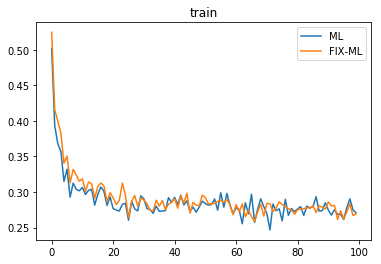

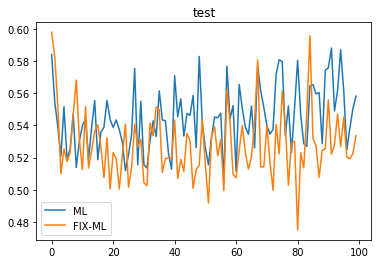

In [55]:
# THIS IS A TYPICAL RUN ###########

# Set parameters
n = 5 # number of support examples per task
n2 = 15 # number of query examples per task
d = 50 # ambient dimension
k = 10 # actual subspace dimension of the weights (used in data generation)  
k_hat = 200 # subspace dimension we learn (used in prediction)
T = 15 # total number of tasks
M = 10000 # total number of X matrix of shape n \times d
m = 20 # no of support sets in fixml
lr = 0.05 # learning rate for learning D
num_iterations_train = 400000 # no of train_iterations
test_frequency = 4000 # no of iterations after which we test
batchsz = 1
lambd = 2. # inner loop regularizer
device = 'cpu' # cuda uses GPU, cpu option would only perform operations on np arrays
seed = 9127
np.random.seed(seed) # set seed

        
# obtain meta-learning and fix-meta learning solns
D_true = np.stack([isotropic_gaussian(d) for _ in range(k)], axis=0).T
D_true = np.linalg.qr(D_true)[0]
D_init = np.random.randn(d, k_hat) / np.sqrt(d) # he init
D_test = D_true
# D_test = np.concatenate([D_true[:, :-1], np.random.randn(d, 1)], axis=1)


# Get Dataset

X_sigma_vec=[1./(np.linalg.norm(D_true[i, :])*np.sqrt(d)*2.) for i in range(d)]
X_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n)]) for i in range(M)]
Xq_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n2)]) for i in range(M)]
c_pool = [isotropic_gaussian(k) for i in range(T)]


if device == 'cuda':
    D_true = torch.FloatTensor(D_true).cuda()
    D_init = torch.FloatTensor(D_init).cuda()
    D_test = torch.FloatTensor(D_test).cuda()


np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
metal_avg_train_loss, metal_avg_test_loss, D_ML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=False, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)
np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
fix_metal_avg_train_loss, fix_metal_avg_test_loss, D_FIXML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=True, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)

# plots
plt.plot(list(range(len(metal_avg_train_loss))), metal_avg_train_loss, label='ML')
plt.plot(list(range(len(fix_metal_avg_train_loss))), fix_metal_avg_train_loss, label='FIX-ML')
plt.title('train')
plt.legend()
plt.show()

plt.plot(list(range(num_iterations_train // test_frequency)), metal_avg_test_loss, label='ML')
plt.plot(list(range(num_iterations_train // test_frequency)), fix_metal_avg_test_loss, label='FIX-ML')
plt.title('test')
plt.legend()
plt.show()




  0%|          | 0/400000 [00:00<?, ?it/s]


  0%|          | 436/400000 [00:00<01:31, 4351.11it/s]


  0%|          | 870/400000 [00:00<01:31, 4347.77it/s]


  0%|          | 1211/400000 [00:00<01:39, 4015.22it/s]


  0%|          | 1633/400000 [00:00<01:37, 4074.51it/s]


  1%|          | 2069/400000 [00:00<01:35, 4154.40it/s]


  1%|          | 2506/400000 [00:00<01:34, 4215.20it/s]


  1%|          | 2942/400000 [00:00<01:33, 4254.97it/s]


  1%|          | 3377/400000 [00:00<01:32, 4282.95it/s]


  1%|          | 3813/400000 [00:00<01:32, 4305.12it/s]


  1%|          | 4227/400000 [00:01<03:44, 1763.39it/s]


  1%|          | 4666/400000 [00:01<03:04, 2148.47it/s]


  1%|▏         | 5107/400000 [00:01<02:35, 2538.66it/s]


  1%|▏         | 5550/400000 [00:01<02:15, 2910.60it/s]


  1%|▏         | 5996/400000 [00:01<02:01, 3249.02it/s]


  2%|▏         | 6439/400000 [00:01<01:51, 3531.16it/s]


  2%|▏         | 6884/400000 [00:02<01:44, 3762.18it/s]


  2%|▏         | 7329/4000

 13%|█▎        | 53351/400000 [00:17<01:56, 2981.57it/s]


 13%|█▎        | 53798/400000 [00:18<01:44, 3310.87it/s]


 14%|█▎        | 54246/400000 [00:18<01:36, 3589.78it/s]


 14%|█▎        | 54694/400000 [00:18<01:30, 3816.81it/s]


 14%|█▍        | 55138/400000 [00:18<01:26, 3983.77it/s]


 14%|█▍        | 55574/400000 [00:18<01:24, 4083.06it/s]


 14%|█▍        | 56010/400000 [00:18<03:06, 1843.99it/s]


 14%|█▍        | 56434/400000 [00:19<02:34, 2219.63it/s]


 14%|█▍        | 56865/400000 [00:19<02:12, 2596.91it/s]


 14%|█▍        | 57298/400000 [00:19<01:56, 2951.02it/s]


 14%|█▍        | 57731/400000 [00:19<01:44, 3262.43it/s]


 15%|█▍        | 58163/400000 [00:19<01:37, 3520.37it/s]


 15%|█▍        | 58597/400000 [00:19<01:31, 3729.73it/s]


 15%|█▍        | 59026/400000 [00:19<01:27, 3880.91it/s]


 15%|█▍        | 59454/400000 [00:19<01:25, 3990.31it/s]


 15%|█▍        | 59885/400000 [00:19<01:23, 4080.10it/s]


 15%|█▌        | 60311/400000 [00:20<03:12, 1768.81it/s]

 26%|██▋       | 105523/400000 [00:35<01:40, 2940.99it/s]


 26%|██▋       | 105965/400000 [00:35<01:29, 3268.52it/s]


 27%|██▋       | 106409/400000 [00:35<01:22, 3547.84it/s]


 27%|██▋       | 106844/400000 [00:36<01:18, 3754.01it/s]


 27%|██▋       | 107288/400000 [00:36<01:14, 3935.02it/s]


 27%|██▋       | 107720/400000 [00:36<01:12, 4042.35it/s]


 27%|██▋       | 108152/400000 [00:36<02:38, 1837.93it/s]


 27%|██▋       | 108591/400000 [00:36<02:10, 2225.74it/s]


 27%|██▋       | 109027/400000 [00:36<01:51, 2607.97it/s]


 27%|██▋       | 109471/400000 [00:37<01:37, 2975.94it/s]


 27%|██▋       | 109916/400000 [00:37<01:27, 3304.28it/s]


 28%|██▊       | 110351/400000 [00:37<01:21, 3560.04it/s]


 28%|██▊       | 110796/400000 [00:37<01:16, 3786.46it/s]


 28%|██▊       | 111224/400000 [00:37<01:13, 3919.72it/s]


 28%|██▊       | 111660/400000 [00:37<01:11, 4041.58it/s]


 28%|██▊       | 112090/400000 [00:38<02:37, 1823.61it/s]


 28%|██▊       | 112523/400000 [00:38<02

 39%|███▉      | 156671/400000 [00:53<01:52, 2158.72it/s]


 39%|███▉      | 157099/400000 [00:53<01:35, 2534.82it/s]


 39%|███▉      | 157525/400000 [00:53<01:24, 2884.98it/s]


 39%|███▉      | 157959/400000 [00:53<01:15, 3207.25it/s]


 40%|███▉      | 158377/400000 [00:53<01:10, 3447.59it/s]


 40%|███▉      | 158803/400000 [00:53<01:05, 3655.13it/s]


 40%|███▉      | 159230/400000 [00:53<01:03, 3818.97it/s]


 40%|███▉      | 159655/400000 [00:54<01:01, 3936.99it/s]


 40%|████      | 160074/400000 [00:54<02:16, 1761.45it/s]


 40%|████      | 160499/400000 [00:54<01:52, 2136.41it/s]


 40%|████      | 160923/400000 [00:54<01:35, 2509.66it/s]


 40%|████      | 161349/400000 [00:54<01:23, 2861.50it/s]


 40%|████      | 161776/400000 [00:54<01:15, 3174.95it/s]


 41%|████      | 162200/400000 [00:55<01:09, 3433.57it/s]


 41%|████      | 162627/400000 [00:55<01:05, 3646.92it/s]


 41%|████      | 163053/400000 [00:55<01:02, 3810.77it/s]


 41%|████      | 163479/400000 [00:55<01

 52%|█████▏    | 207303/400000 [01:10<00:49, 3882.20it/s]


 52%|█████▏    | 207741/400000 [01:10<00:47, 4017.39it/s]


 52%|█████▏    | 208170/400000 [01:11<01:44, 1834.72it/s]


 52%|█████▏    | 208616/400000 [01:11<01:25, 2227.76it/s]


 52%|█████▏    | 209053/400000 [01:11<01:13, 2611.70it/s]


 52%|█████▏    | 209473/400000 [01:11<01:04, 2944.58it/s]


 52%|█████▏    | 209890/400000 [01:11<00:58, 3227.27it/s]


 53%|█████▎    | 210324/400000 [01:11<00:54, 3494.30it/s]


 53%|█████▎    | 210762/400000 [01:11<00:50, 3719.13it/s]


 53%|█████▎    | 211198/400000 [01:11<00:48, 3889.69it/s]


 53%|█████▎    | 211634/400000 [01:11<00:46, 4019.39it/s]


 53%|█████▎    | 212062/400000 [01:12<01:43, 1808.96it/s]


 53%|█████▎    | 212491/400000 [01:12<01:25, 2188.10it/s]


 53%|█████▎    | 212928/400000 [01:12<01:12, 2573.58it/s]


 53%|█████▎    | 213365/400000 [01:12<01:03, 2934.34it/s]


 53%|█████▎    | 213802/400000 [01:12<00:57, 3254.48it/s]


 54%|█████▎    | 214238/400000 [01:12<00

 64%|██████▍   | 257887/400000 [01:28<00:43, 3240.79it/s]


 65%|██████▍   | 258321/400000 [01:28<00:40, 3507.09it/s]


 65%|██████▍   | 258770/400000 [01:28<00:37, 3752.42it/s]


 65%|██████▍   | 259207/400000 [01:28<00:35, 3917.29it/s]


 65%|██████▍   | 259643/400000 [01:28<00:34, 4038.27it/s]


 65%|██████▌   | 260074/400000 [01:28<01:16, 1829.69it/s]


 65%|██████▌   | 260496/400000 [01:29<01:03, 2203.82it/s]


 65%|██████▌   | 260931/400000 [01:29<00:53, 2585.79it/s]


 65%|██████▌   | 261364/400000 [01:29<00:47, 2940.38it/s]


 65%|██████▌   | 261785/400000 [01:29<00:42, 3232.45it/s]


 66%|██████▌   | 262218/400000 [01:29<00:39, 3496.91it/s]


 66%|██████▌   | 262655/400000 [01:29<00:36, 3718.19it/s]


 66%|██████▌   | 263093/400000 [01:29<00:35, 3892.44it/s]


 66%|██████▌   | 263530/400000 [01:29<00:33, 4023.52it/s]


 66%|██████▌   | 263967/400000 [01:29<00:33, 4120.69it/s]


 66%|██████▌   | 264398/400000 [01:30<01:14, 1825.59it/s]


 66%|██████▌   | 264833/400000 [01:30<01

 77%|███████▋  | 308421/400000 [01:45<00:43, 2097.64it/s]


 77%|███████▋  | 308838/400000 [01:45<00:36, 2465.16it/s]


 77%|███████▋  | 309256/400000 [01:45<00:32, 2810.78it/s]


 77%|███████▋  | 309673/400000 [01:45<00:28, 3115.35it/s]


 78%|███████▊  | 310093/400000 [01:46<00:26, 3376.69it/s]


 78%|███████▊  | 310513/400000 [01:46<00:24, 3587.36it/s]


 78%|███████▊  | 310934/400000 [01:46<00:23, 3753.02it/s]


 78%|███████▊  | 311352/400000 [01:46<00:22, 3871.56it/s]


 78%|███████▊  | 311775/400000 [01:46<00:22, 3971.89it/s]


 78%|███████▊  | 312191/400000 [01:46<00:49, 1761.64it/s]


 78%|███████▊  | 312609/400000 [01:47<00:41, 2131.34it/s]


 78%|███████▊  | 313031/400000 [01:47<00:34, 2502.08it/s]


 78%|███████▊  | 313460/400000 [01:47<00:30, 2859.03it/s]


 78%|███████▊  | 313886/400000 [01:47<00:27, 3170.54it/s]


 79%|███████▊  | 314320/400000 [01:47<00:24, 3449.22it/s]


 79%|███████▊  | 314764/400000 [01:47<00:23, 3695.50it/s]


 79%|███████▉  | 315212/400000 [01:47<00

 89%|████████▉ | 356864/400000 [02:03<00:16, 2574.24it/s]


 89%|████████▉ | 357298/400000 [02:03<00:14, 2931.51it/s]


 89%|████████▉ | 357732/400000 [02:03<00:13, 3247.68it/s]


 90%|████████▉ | 358166/400000 [02:03<00:11, 3511.60it/s]


 90%|████████▉ | 358602/400000 [02:03<00:11, 3728.02it/s]


 90%|████████▉ | 359035/400000 [02:03<00:10, 3888.83it/s]


 90%|████████▉ | 359470/400000 [02:04<00:10, 4014.93it/s]


 90%|████████▉ | 359901/400000 [02:04<00:09, 4098.38it/s]


 90%|█████████ | 360330/400000 [02:04<00:22, 1777.86it/s]


 90%|█████████ | 360755/400000 [02:04<00:18, 2153.14it/s]


 90%|█████████ | 361188/400000 [02:04<00:15, 2535.40it/s]


 90%|█████████ | 361613/400000 [02:04<00:13, 2883.43it/s]


 91%|█████████ | 362037/400000 [02:05<00:11, 3188.32it/s]


 91%|█████████ | 362459/400000 [02:05<00:10, 3440.06it/s]


 91%|█████████ | 362888/400000 [02:05<00:10, 3655.99it/s]


 91%|█████████ | 363328/400000 [02:05<00:09, 3849.84it/s]


 91%|█████████ | 363764/400000 [02:05<00

Running with fixSupport of size 20





  0%|          | 865/400000 [00:00<01:32, 4331.25it/s]


  0%|          | 1295/400000 [00:00<01:32, 4319.78it/s]


  0%|          | 1727/400000 [00:00<01:32, 4319.39it/s]


  1%|          | 2169/400000 [00:00<01:31, 4348.96it/s]


  1%|          | 2644/400000 [00:00<01:29, 4461.19it/s]


  1%|          | 3088/400000 [00:00<01:29, 4452.10it/s]


  1%|          | 3532/400000 [00:00<01:29, 4447.53it/s]


  1%|          | 3953/400000 [00:00<01:36, 4092.62it/s]


  1%|          | 4351/400000 [00:01<03:44, 1765.08it/s]


  1%|          | 4780/400000 [00:01<03:04, 2143.19it/s]


  1%|▏         | 5210/400000 [00:01<02:36, 2522.60it/s]


  1%|▏         | 5642/400000 [00:01<02:16, 2882.14it/s]


  2%|▏         | 6083/400000 [00:01<02:02, 3216.43it/s]


  2%|▏         | 6525/400000 [00:01<01:52, 3501.95it/s]


  2%|▏         | 6969/400000 [00:02<01:45, 3738.72it/s]


  2%|▏         | 7413/400000 [00:02<01:40, 3923.96it/s]


  2%|▏         | 7857/400000 [00:02<01:36, 4065.23it/s]


  2%|▏      

 13%|█▎        | 52884/400000 [00:17<02:15, 2555.40it/s]


 13%|█▎        | 53314/400000 [00:18<01:59, 2908.91it/s]


 13%|█▎        | 53739/400000 [00:18<01:47, 3212.37it/s]


 14%|█▎        | 54156/400000 [00:18<01:40, 3448.99it/s]


 14%|█▎        | 54585/400000 [00:18<01:34, 3664.39it/s]


 14%|█▍        | 55016/400000 [00:18<01:29, 3836.16it/s]


 14%|█▍        | 55447/400000 [00:18<01:26, 3966.96it/s]


 14%|█▍        | 55879/400000 [00:18<01:24, 4065.37it/s]


 14%|█▍        | 56305/400000 [00:19<03:10, 1799.92it/s]


 14%|█▍        | 56737/400000 [00:19<02:37, 2181.26it/s]


 14%|█▍        | 57170/400000 [00:19<02:13, 2562.35it/s]


 14%|█▍        | 57603/400000 [00:19<01:57, 2919.80it/s]


 15%|█▍        | 58036/400000 [00:19<01:45, 3234.70it/s]


 15%|█▍        | 58473/400000 [00:19<01:37, 3506.96it/s]


 15%|█▍        | 58904/400000 [00:19<01:31, 3714.15it/s]


 15%|█▍        | 59334/400000 [00:19<01:28, 3870.70it/s]


 15%|█▍        | 59762/400000 [00:20<01:25, 3982.80it/s]

 26%|██▌       | 103976/400000 [00:35<01:13, 4039.12it/s]


 26%|██▌       | 104399/400000 [00:35<02:45, 1781.94it/s]


 26%|██▌       | 104745/400000 [00:36<02:21, 2083.82it/s]


 26%|██▋       | 105140/400000 [00:36<02:01, 2427.38it/s]


 26%|██▋       | 105555/400000 [00:36<01:46, 2772.14it/s]


 26%|██▋       | 105979/400000 [00:36<01:35, 3092.69it/s]


 27%|██▋       | 106396/400000 [00:36<01:27, 3351.63it/s]


 27%|██▋       | 106814/400000 [00:36<01:22, 3562.36it/s]


 27%|██▋       | 107242/400000 [00:36<01:18, 3750.70it/s]


 27%|██▋       | 107667/400000 [00:36<01:15, 3887.04it/s]


 27%|██▋       | 108081/400000 [00:37<02:48, 1732.36it/s]


 27%|██▋       | 108479/400000 [00:37<02:19, 2085.56it/s]


 27%|██▋       | 108895/400000 [00:37<01:58, 2452.26it/s]


 27%|██▋       | 109320/400000 [00:37<01:43, 2808.41it/s]


 27%|██▋       | 109752/400000 [00:37<01:32, 3137.02it/s]


 28%|██▊       | 110179/400000 [00:37<01:25, 3407.87it/s]


 28%|██▊       | 110605/400000 [00:37<01

 39%|███▊      | 154072/400000 [00:52<01:18, 3135.85it/s]


 39%|███▊      | 154486/400000 [00:53<01:12, 3380.23it/s]


 39%|███▊      | 154901/400000 [00:53<01:08, 3577.82it/s]


 39%|███▉      | 155328/400000 [00:53<01:05, 3759.61it/s]


 39%|███▉      | 155753/400000 [00:53<01:02, 3894.27it/s]


 39%|███▉      | 156168/400000 [00:53<02:20, 1732.82it/s]


 39%|███▉      | 156592/400000 [00:54<01:55, 2106.26it/s]


 39%|███▉      | 157018/400000 [00:54<01:37, 2481.84it/s]


 39%|███▉      | 157446/400000 [00:54<01:25, 2838.82it/s]


 39%|███▉      | 157873/400000 [00:54<01:16, 3155.16it/s]


 40%|███▉      | 158299/400000 [00:54<01:10, 3419.58it/s]


 40%|███▉      | 158730/400000 [00:54<01:06, 3644.19it/s]


 40%|███▉      | 159161/400000 [00:54<01:03, 3819.84it/s]


 40%|███▉      | 159588/400000 [00:54<01:00, 3942.89it/s]


 40%|████      | 160010/400000 [00:55<02:17, 1751.64it/s]


 40%|████      | 160427/400000 [00:55<01:53, 2119.98it/s]


 40%|████      | 160848/400000 [00:55<01

 51%|█████     | 204701/400000 [01:10<01:30, 2162.76it/s]


 51%|█████▏    | 205131/400000 [01:10<01:16, 2541.22it/s]


 51%|█████▏    | 205561/400000 [01:10<01:07, 2895.66it/s]


 51%|█████▏    | 205980/400000 [01:10<01:00, 3190.09it/s]


 52%|█████▏    | 206409/400000 [01:11<00:56, 3454.11it/s]


 52%|█████▏    | 206840/400000 [01:11<00:52, 3671.91it/s]


 52%|█████▏    | 207281/400000 [01:11<00:49, 3865.39it/s]


 52%|█████▏    | 207721/400000 [01:11<00:47, 4010.70it/s]


 52%|█████▏    | 208149/400000 [01:11<01:46, 1797.90it/s]


 52%|█████▏    | 208578/400000 [01:11<01:27, 2176.94it/s]


 52%|█████▏    | 209010/400000 [01:12<01:14, 2556.84it/s]


 52%|█████▏    | 209438/400000 [01:12<01:05, 2907.36it/s]


 52%|█████▏    | 209867/400000 [01:12<00:59, 3217.97it/s]


 53%|█████▎    | 210298/400000 [01:12<00:54, 3481.73it/s]


 53%|█████▎    | 210737/400000 [01:12<00:50, 3711.54it/s]


 53%|█████▎    | 211176/400000 [01:12<00:48, 3891.39it/s]


 53%|█████▎    | 211608/400000 [01:12<00

 64%|██████▍   | 255722/400000 [01:27<00:36, 4001.29it/s]


 64%|██████▍   | 256148/400000 [01:28<01:18, 1828.04it/s]


 64%|██████▍   | 256587/400000 [01:28<01:04, 2215.69it/s]


 64%|██████▍   | 257029/400000 [01:28<00:54, 2604.82it/s]


 64%|██████▍   | 257470/400000 [01:28<00:48, 2969.37it/s]


 64%|██████▍   | 257912/400000 [01:28<00:43, 3292.40it/s]


 65%|██████▍   | 258352/400000 [01:28<00:39, 3561.34it/s]


 65%|██████▍   | 258792/400000 [01:28<00:37, 3776.50it/s]


 65%|██████▍   | 259233/400000 [01:28<00:35, 3945.91it/s]


 65%|██████▍   | 259674/400000 [01:29<00:34, 4072.77it/s]


 65%|██████▌   | 260108/400000 [01:29<01:15, 1857.27it/s]


 65%|██████▌   | 260545/400000 [01:29<01:02, 2244.36it/s]


 65%|██████▌   | 260988/400000 [01:29<00:52, 2633.40it/s]


 65%|██████▌   | 261430/400000 [01:29<00:46, 2995.43it/s]


 65%|██████▌   | 261871/400000 [01:29<00:41, 3314.12it/s]


 66%|██████▌   | 262309/400000 [01:30<00:38, 3575.11it/s]


 66%|██████▌   | 262741/400000 [01:30<00

 77%|███████▋  | 306086/400000 [01:45<00:29, 3235.09it/s]


 77%|███████▋  | 306519/400000 [01:45<00:26, 3500.35it/s]


 77%|███████▋  | 306952/400000 [01:45<00:25, 3711.90it/s]


 77%|███████▋  | 307386/400000 [01:45<00:23, 3878.20it/s]


 77%|███████▋  | 307810/400000 [01:45<00:23, 3973.11it/s]


 77%|███████▋  | 308233/400000 [01:46<00:51, 1783.27it/s]


 77%|███████▋  | 308664/400000 [01:46<00:42, 2163.34it/s]


 77%|███████▋  | 309095/400000 [01:46<00:35, 2542.96it/s]


 77%|███████▋  | 309527/400000 [01:46<00:31, 2899.66it/s]


 77%|███████▋  | 309960/400000 [01:46<00:27, 3217.23it/s]


 78%|███████▊  | 310393/400000 [01:46<00:25, 3485.02it/s]


 78%|███████▊  | 310825/400000 [01:46<00:24, 3697.83it/s]


 78%|███████▊  | 311256/400000 [01:46<00:22, 3862.26it/s]


 78%|███████▊  | 311685/400000 [01:47<00:22, 3981.18it/s]


 78%|███████▊  | 312110/400000 [01:47<00:49, 1780.51it/s]


 78%|███████▊  | 312534/400000 [01:47<00:40, 2155.42it/s]


 78%|███████▊  | 312960/400000 [01:47<00

 89%|████████▉ | 356821/400000 [02:02<00:20, 2137.58it/s]


 89%|████████▉ | 357244/400000 [02:03<00:17, 2509.54it/s]


 89%|████████▉ | 357667/400000 [02:03<00:14, 2857.33it/s]


 90%|████████▉ | 358089/400000 [02:03<00:13, 3162.78it/s]


 90%|████████▉ | 358512/400000 [02:03<00:12, 3419.90it/s]


 90%|████████▉ | 358935/400000 [02:03<00:11, 3627.31it/s]


 90%|████████▉ | 359357/400000 [02:03<00:10, 3784.69it/s]


 90%|████████▉ | 359778/400000 [02:03<00:10, 3902.26it/s]


 90%|█████████ | 360194/400000 [02:04<00:22, 1751.58it/s]


 90%|█████████ | 360629/400000 [02:04<00:18, 2133.91it/s]


 90%|█████████ | 361065/400000 [02:04<00:15, 2519.43it/s]


 90%|█████████ | 361499/400000 [02:04<00:13, 2881.55it/s]


 90%|█████████ | 361936/400000 [02:04<00:11, 3208.69it/s]


 91%|█████████ | 362373/400000 [02:04<00:10, 3486.28it/s]


 91%|█████████ | 362808/400000 [02:04<00:10, 3706.57it/s]


 91%|█████████ | 363245/400000 [02:04<00:09, 3882.12it/s]


 91%|█████████ | 363680/400000 [02:04<00

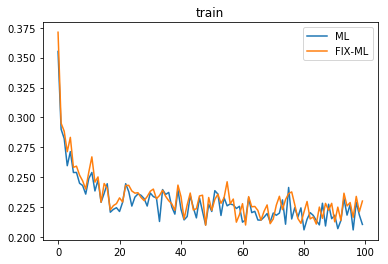

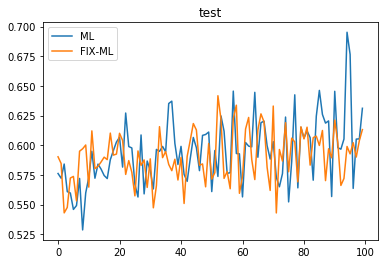

In [76]:
# THIS IS A TYPICAL RUN ###########

# Set parameters
n = 5 # number of support examples per task
n2 = 15 # number of query examples per task
d = 50 # ambient dimension
k = 10 # actual subspace dimension of the weights (used in data generation)  
k_hat = 30 # subspace dimension we learn (used in prediction)
T = 15 # total number of tasks
M = 10000 # total number of X matrix of shape n \times d
m = 20 # no of support sets in fixml
lr = 0.05 # learning rate for learning D
num_iterations_train = 400000 # no of train_iterations
test_frequency = 4000 # no of iterations after which we test
batchsz = 1
lambd = 1. # inner loop regularizer
device = 'cpu' # cuda uses GPU, cpu option would only perform operations on np arrays
seed = 9127
np.random.seed(seed) # set seed

        
# obtain meta-learning and fix-meta learning solns
D_true = np.stack([isotropic_gaussian(d) for _ in range(k)], axis=0).T
D_true = np.linalg.qr(D_true)[0]
D_init = np.random.randn(d, k_hat) / np.sqrt(d) # he init
D_test = D_true
# D_test = np.concatenate([D_true[:, :-1], np.random.randn(d, 1)], axis=1)


# Get Dataset

X_sigma_vec=[1./(np.linalg.norm(D_true[i, :])*np.sqrt(d)*2.) for i in range(d)]
X_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n)]) for i in range(M)]
Xq_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n2)]) for i in range(M)]
c_pool = [isotropic_gaussian(k) for i in range(T)]


if device == 'cuda':
    D_true = torch.FloatTensor(D_true).cuda()
    D_init = torch.FloatTensor(D_init).cuda()
    D_test = torch.FloatTensor(D_test).cuda()


np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
metal_avg_train_loss, metal_avg_test_loss, D_ML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=False, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)
np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
fix_metal_avg_train_loss, fix_metal_avg_test_loss, D_FIXML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=True, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)

# plots
plt.plot(list(range(len(metal_avg_train_loss))), metal_avg_train_loss, label='ML')
plt.plot(list(range(len(fix_metal_avg_train_loss))), fix_metal_avg_train_loss, label='FIX-ML')
plt.title('train')
plt.legend()
plt.show()

plt.plot(list(range(num_iterations_train // test_frequency)), metal_avg_test_loss, label='ML')
plt.plot(list(range(num_iterations_train // test_frequency)), fix_metal_avg_test_loss, label='FIX-ML')
plt.title('test')
plt.legend()
plt.show()

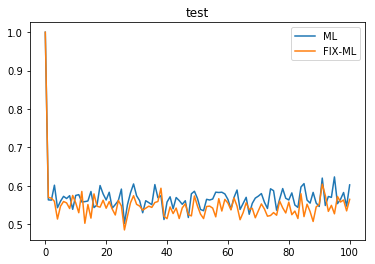

In [74]:
plt.plot(list(range(num_iterations_train // test_frequency+1)), [1.]+metal_avg_test_loss, label='ML')
plt.plot(list(range(num_iterations_train // test_frequency+1)), [1.]+fix_metal_avg_test_loss, label='FIX-ML')
plt.title('test')
plt.legend()
plt.show()



  1%|          | 3949/400000 [00:16<10:03, 655.94it/s]

  0%|          | 84/400000 [00:00<08:00, 831.45it/s]

  0%|          | 171/400000 [00:00<07:55, 841.74it/s]

  0%|          | 252/400000 [00:00<08:01, 830.76it/s]

  0%|          | 340/400000 [00:00<07:54, 842.46it/s]

  0%|          | 405/400000 [00:00<08:52, 750.11it/s]

  0%|          | 494/400000 [00:00<08:28, 785.21it/s]

  0%|          | 582/400000 [00:00<08:13, 810.02it/s]

  0%|          | 670/400000 [00:00<08:02, 828.08it/s]

  0%|          | 758/400000 [00:00<07:53, 842.47it/s]

  0%|          | 846/400000 [00:01<07:49, 850.60it/s]

  0%|          | 930/400000 [00:01<07:56, 837.84it/s]

  0%|          | 1013/400000 [00:01<09:53, 672.11it/s]

  0%|          | 1085/400000 [00:01<10:05, 658.81it/s]

  0%|          | 1176/400000 [00:01<09:15, 717.59it/s]

  0%|          | 1263/400000 [00:01<08:46, 756.99it/s]

  0%|          | 1351/400000 [00:01<08:25, 788.52it/s]

  0%|          | 1439/400000 [00:01<08:10, 812.47it/s]

  

  3%|▎         | 11275/400000 [00:17<08:03, 803.72it/s]

  3%|▎         | 11361/400000 [00:17<07:54, 818.65it/s]

  3%|▎         | 11448/400000 [00:17<07:47, 830.69it/s]

  3%|▎         | 11532/400000 [00:17<10:13, 632.89it/s]

  3%|▎         | 11618/400000 [00:17<09:25, 686.94it/s]

  3%|▎         | 11704/400000 [00:17<08:51, 730.23it/s]

  3%|▎         | 11789/400000 [00:17<08:29, 761.89it/s]

  3%|▎         | 11872/400000 [00:17<08:17, 780.70it/s]

  3%|▎         | 11956/400000 [00:18<08:07, 796.32it/s]

  3%|▎         | 12038/400000 [00:19<46:03, 140.38it/s]

  3%|▎         | 12097/400000 [00:19<36:01, 179.47it/s]

  3%|▎         | 12183/400000 [00:20<27:28, 235.21it/s]

  3%|▎         | 12269/400000 [00:20<21:29, 300.63it/s]

  3%|▎         | 12356/400000 [00:20<17:17, 373.60it/s]

  3%|▎         | 12435/400000 [00:20<14:33, 443.46it/s]

  3%|▎         | 12522/400000 [00:20<12:26, 519.17it/s]

  3%|▎         | 12602/400000 [00:20<12:56, 498.71it/s]

  3%|▎         | 12691/400000 [

  6%|▌         | 22227/400000 [00:36<07:47, 807.82it/s]

  6%|▌         | 22309/400000 [00:36<08:57, 702.69it/s]

  6%|▌         | 22396/400000 [00:36<08:27, 743.84it/s]

  6%|▌         | 22474/400000 [00:36<08:35, 732.87it/s]

  6%|▌         | 22561/400000 [00:36<08:11, 767.36it/s]

  6%|▌         | 22648/400000 [00:36<07:54, 794.72it/s]

  6%|▌         | 22735/400000 [00:36<07:43, 813.71it/s]

  6%|▌         | 22822/400000 [00:36<07:35, 828.82it/s]

  6%|▌         | 22909/400000 [00:36<07:28, 839.89it/s]

  6%|▌         | 22995/400000 [00:36<07:26, 844.49it/s]

  6%|▌         | 23082/400000 [00:37<07:23, 849.87it/s]

  6%|▌         | 23168/400000 [00:37<07:45, 810.02it/s]

  6%|▌         | 23254/400000 [00:37<07:37, 823.53it/s]

  6%|▌         | 23341/400000 [00:37<07:31, 834.25it/s]

  6%|▌         | 23428/400000 [00:37<07:26, 842.55it/s]

  6%|▌         | 23513/400000 [00:37<07:48, 804.39it/s]

  6%|▌         | 23599/400000 [00:37<07:39, 820.02it/s]

  6%|▌         | 23686/400000 [

  8%|▊         | 33276/400000 [00:54<10:43, 570.24it/s]

  8%|▊         | 33363/400000 [00:55<09:37, 634.51it/s]

  8%|▊         | 33450/400000 [00:55<08:52, 688.94it/s]

  8%|▊         | 33527/400000 [00:55<08:58, 680.39it/s]

  8%|▊         | 33613/400000 [00:55<08:25, 725.09it/s]

  8%|▊         | 33699/400000 [00:55<08:01, 760.28it/s]

  8%|▊         | 33785/400000 [00:55<07:45, 787.03it/s]

  8%|▊         | 33867/400000 [00:55<07:58, 764.98it/s]

  8%|▊         | 33953/400000 [00:55<07:43, 790.48it/s]

  9%|▊         | 34039/400000 [00:55<07:33, 807.86it/s]

  9%|▊         | 34126/400000 [00:55<07:24, 823.05it/s]

  9%|▊         | 34213/400000 [00:56<07:18, 834.19it/s]

  9%|▊         | 34300/400000 [00:56<07:14, 842.61it/s]

  9%|▊         | 34387/400000 [00:56<07:11, 848.13it/s]

  9%|▊         | 34473/400000 [00:56<07:26, 818.43it/s]

  9%|▊         | 34559/400000 [00:56<07:20, 829.52it/s]

  9%|▊         | 34645/400000 [00:56<07:15, 838.08it/s]

  9%|▊         | 34731/400000 [

 11%|█         | 44074/400000 [01:13<44:50, 132.29it/s]

 11%|█         | 44159/400000 [01:14<33:28, 177.16it/s]

 11%|█         | 44243/400000 [01:14<25:34, 231.91it/s]

 11%|█         | 44329/400000 [01:14<19:57, 296.97it/s]

 11%|█         | 44415/400000 [01:14<16:02, 369.52it/s]

 11%|█         | 44495/400000 [01:14<13:27, 440.09it/s]

 11%|█         | 44581/400000 [01:14<11:29, 515.21it/s]

 11%|█         | 44668/400000 [01:14<10:06, 585.91it/s]

 11%|█         | 44755/400000 [01:14<09:07, 648.58it/s]

 11%|█         | 44839/400000 [01:14<08:49, 670.49it/s]

 11%|█         | 44925/400000 [01:14<08:14, 717.66it/s]

 11%|█▏        | 45011/400000 [01:15<07:50, 755.10it/s]

 11%|█▏        | 45098/400000 [01:15<07:32, 784.38it/s]

 11%|█▏        | 45184/400000 [01:15<07:20, 804.79it/s]

 11%|█▏        | 45269/400000 [01:15<07:49, 754.77it/s]

 11%|█▏        | 45348/400000 [01:15<09:01, 654.96it/s]

 11%|█▏        | 45419/400000 [01:15<08:56, 660.98it/s]

 11%|█▏        | 45504/400000 [

 14%|█▍        | 55075/400000 [01:31<07:15, 791.42it/s]

 14%|█▍        | 55160/400000 [01:31<07:07, 806.65it/s]

 14%|█▍        | 55246/400000 [01:31<07:00, 819.83it/s]

 14%|█▍        | 55332/400000 [01:31<06:55, 828.69it/s]

 14%|█▍        | 55416/400000 [01:31<08:49, 650.50it/s]

 14%|█▍        | 55488/400000 [01:31<08:35, 667.84it/s]

 14%|█▍        | 55573/400000 [01:31<08:03, 712.70it/s]

 14%|█▍        | 55656/400000 [01:32<07:43, 743.47it/s]

 14%|█▍        | 55742/400000 [01:32<07:25, 773.33it/s]

 14%|█▍        | 55828/400000 [01:32<07:12, 794.99it/s]

 14%|█▍        | 55914/400000 [01:32<07:03, 812.58it/s]

 14%|█▍        | 55997/400000 [01:32<07:23, 776.11it/s]

 14%|█▍        | 56076/400000 [01:34<42:44, 134.12it/s]

 14%|█▍        | 56133/400000 [01:34<33:41, 170.14it/s]

 14%|█▍        | 56222/400000 [01:34<25:30, 224.59it/s]

 14%|█▍        | 56308/400000 [01:34<19:51, 288.40it/s]

 14%|█▍        | 56394/400000 [01:34<15:53, 360.19it/s]

 14%|█▍        | 56480/400000 [

 16%|█▋        | 65977/400000 [01:50<07:13, 769.75it/s]

 17%|█▋        | 66055/400000 [01:50<08:21, 666.31it/s]

 17%|█▋        | 66125/400000 [01:50<09:37, 577.99it/s]

 17%|█▋        | 66215/400000 [01:50<08:36, 646.67it/s]

 17%|█▋        | 66300/400000 [01:50<07:59, 696.39it/s]

 17%|█▋        | 66383/400000 [01:50<07:38, 727.20it/s]

 17%|█▋        | 66468/400000 [01:50<07:18, 759.82it/s]

 17%|█▋        | 66554/400000 [01:51<07:04, 785.37it/s]

 17%|█▋        | 66639/400000 [01:51<06:55, 802.01it/s]

 17%|█▋        | 66724/400000 [01:51<06:49, 814.55it/s]

 17%|█▋        | 66810/400000 [01:51<06:43, 825.40it/s]

 17%|█▋        | 66896/400000 [01:51<06:39, 834.23it/s]

 17%|█▋        | 66982/400000 [01:51<06:35, 841.12it/s]

 17%|█▋        | 67067/400000 [01:51<06:49, 813.35it/s]

 17%|█▋        | 67152/400000 [01:51<06:44, 823.69it/s]

 17%|█▋        | 67237/400000 [01:51<06:41, 828.96it/s]

 17%|█▋        | 67323/400000 [01:51<06:37, 837.10it/s]

 17%|█▋        | 67407/400000 [

 19%|█▉        | 77005/400000 [02:08<07:39, 703.07it/s]

 19%|█▉        | 77081/400000 [02:08<07:31, 714.75it/s]

 19%|█▉        | 77163/400000 [02:09<07:14, 743.00it/s]

 19%|█▉        | 77246/400000 [02:09<07:00, 766.89it/s]

 19%|█▉        | 77329/400000 [02:09<06:51, 784.68it/s]

 19%|█▉        | 77412/400000 [02:09<06:45, 796.41it/s]

 19%|█▉        | 77496/400000 [02:09<06:39, 806.50it/s]

 19%|█▉        | 77579/400000 [02:09<06:36, 812.92it/s]

 19%|█▉        | 77662/400000 [02:09<06:35, 815.94it/s]

 19%|█▉        | 77745/400000 [02:09<06:37, 811.00it/s]

 19%|█▉        | 77827/400000 [02:09<06:37, 810.57it/s]

 19%|█▉        | 77910/400000 [02:10<06:35, 815.29it/s]

 19%|█▉        | 77993/400000 [02:10<06:33, 817.77it/s]

 20%|█▉        | 78076/400000 [02:10<06:32, 820.14it/s]

 20%|█▉        | 78159/400000 [02:10<06:31, 822.46it/s]

 20%|█▉        | 78242/400000 [02:10<06:31, 822.75it/s]

 20%|█▉        | 78325/400000 [02:10<07:15, 738.32it/s]

 20%|█▉        | 78404/400000 [

 22%|██▏       | 87765/400000 [02:26<06:11, 840.63it/s]

 22%|██▏       | 87852/400000 [02:26<06:07, 848.26it/s]

 22%|██▏       | 87939/400000 [02:26<06:05, 853.70it/s]

 22%|██▏       | 88025/400000 [02:28<37:22, 139.11it/s]

 22%|██▏       | 88111/400000 [02:28<27:58, 185.80it/s]

 22%|██▏       | 88197/400000 [02:28<21:23, 242.93it/s]

 22%|██▏       | 88284/400000 [02:28<16:46, 309.71it/s]

 22%|██▏       | 88371/400000 [02:28<13:32, 383.78it/s]

 22%|██▏       | 88458/400000 [02:28<11:16, 460.66it/s]

 22%|██▏       | 88545/400000 [02:28<09:41, 535.87it/s]

 22%|██▏       | 88629/400000 [02:28<08:44, 594.07it/s]

 22%|██▏       | 88715/400000 [02:29<07:55, 654.04it/s]

 22%|██▏       | 88801/400000 [02:29<07:21, 704.46it/s]

 22%|██▏       | 88886/400000 [02:29<07:00, 739.39it/s]

 22%|██▏       | 88970/400000 [02:29<06:52, 754.57it/s]

 22%|██▏       | 89056/400000 [02:29<06:37, 782.96it/s]

 22%|██▏       | 89143/400000 [02:29<06:25, 805.51it/s]

 22%|██▏       | 89230/400000 [

 25%|██▍       | 98777/400000 [02:45<05:49, 861.55it/s]

 25%|██▍       | 98865/400000 [02:45<05:48, 864.51it/s]

 25%|██▍       | 98953/400000 [02:45<05:47, 866.29it/s]

 25%|██▍       | 99041/400000 [02:45<05:46, 867.94it/s]

 25%|██▍       | 99129/400000 [02:45<05:46, 868.80it/s]

 25%|██▍       | 99216/400000 [02:45<05:46, 868.06it/s]

 25%|██▍       | 99303/400000 [02:45<06:07, 817.91it/s]

 25%|██▍       | 99386/400000 [02:46<07:04, 708.00it/s]

 25%|██▍       | 99460/400000 [02:46<07:11, 696.00it/s]

 25%|██▍       | 99532/400000 [02:46<07:24, 675.63it/s]

 25%|██▍       | 99609/400000 [02:46<07:08, 700.63it/s]

 25%|██▍       | 99694/400000 [02:46<06:46, 739.14it/s]

 25%|██▍       | 99780/400000 [02:46<06:29, 770.50it/s]

 25%|██▍       | 99866/400000 [02:46<06:17, 795.31it/s]

 25%|██▍       | 99952/400000 [02:46<06:09, 811.73it/s]

 25%|██▌       | 100035/400000 [02:48<35:22, 141.33it/s]

 25%|██▌       | 100107/400000 [02:48<26:54, 185.73it/s]

 25%|██▌       | 100193/40000

 27%|██▋       | 109462/400000 [03:04<06:30, 744.47it/s]

 27%|██▋       | 109540/400000 [03:04<06:24, 754.67it/s]

 27%|██▋       | 109617/400000 [03:04<07:37, 634.51it/s]

 27%|██▋       | 109685/400000 [03:04<09:55, 487.79it/s]

 27%|██▋       | 109757/400000 [03:04<08:58, 539.03it/s]

 27%|██▋       | 109836/400000 [03:04<08:08, 594.08it/s]

 27%|██▋       | 109908/400000 [03:05<07:42, 626.86it/s]

 27%|██▋       | 109987/400000 [03:05<07:14, 666.95it/s]

 28%|██▊       | 110066/400000 [03:05<06:55, 697.29it/s]

 28%|██▊       | 110145/400000 [03:05<06:42, 720.40it/s]

 28%|██▊       | 110220/400000 [03:05<06:39, 725.05it/s]

 28%|██▊       | 110298/400000 [03:05<06:31, 740.32it/s]

 28%|██▊       | 110377/400000 [03:05<06:25, 752.23it/s]

 28%|██▊       | 110456/400000 [03:05<06:20, 761.28it/s]

 28%|██▊       | 110534/400000 [03:05<06:18, 763.99it/s]

 28%|██▊       | 110613/400000 [03:06<06:16, 769.50it/s]

 28%|██▊       | 110692/400000 [03:06<06:14, 772.80it/s]

 28%|██▊      

 30%|██▉       | 119316/400000 [03:22<06:13, 751.80it/s]

 30%|██▉       | 119395/400000 [03:22<06:08, 760.97it/s]

 30%|██▉       | 119474/400000 [03:22<06:05, 767.38it/s]

 30%|██▉       | 119551/400000 [03:22<06:24, 728.63it/s]

 30%|██▉       | 119629/400000 [03:22<06:17, 742.95it/s]

 30%|██▉       | 119707/400000 [03:22<06:11, 753.50it/s]

 30%|██▉       | 119785/400000 [03:22<06:08, 760.19it/s]

 30%|██▉       | 119864/400000 [03:22<06:05, 766.72it/s]

 30%|██▉       | 119941/400000 [03:22<06:06, 763.73it/s]

 30%|███       | 120018/400000 [03:24<40:30, 115.18it/s]

 30%|███       | 120096/400000 [03:24<30:09, 154.70it/s]

 30%|███       | 120175/400000 [03:25<22:53, 203.71it/s]

 30%|███       | 120254/400000 [03:25<17:48, 261.73it/s]

 30%|███       | 120333/400000 [03:25<14:15, 327.05it/s]

 30%|███       | 120412/400000 [03:25<11:45, 396.17it/s]

 30%|███       | 120487/400000 [03:25<11:07, 418.94it/s]

 30%|███       | 120554/400000 [03:25<10:47, 431.61it/s]

 30%|███      

 33%|███▎      | 130052/400000 [03:40<05:29, 818.64it/s]

 33%|███▎      | 130139/400000 [03:40<05:24, 832.18it/s]

 33%|███▎      | 130226/400000 [03:41<05:20, 842.00it/s]

 33%|███▎      | 130311/400000 [03:41<05:28, 820.67it/s]

 33%|███▎      | 130397/400000 [03:41<05:24, 830.95it/s]

 33%|███▎      | 130481/400000 [03:41<05:53, 762.27it/s]

 33%|███▎      | 130559/400000 [03:41<05:53, 762.97it/s]

 33%|███▎      | 130644/400000 [03:41<05:42, 787.01it/s]

 33%|███▎      | 130724/400000 [03:41<05:49, 771.35it/s]

 33%|███▎      | 130802/400000 [03:41<05:52, 764.28it/s]

 33%|███▎      | 130885/400000 [03:41<05:44, 781.05it/s]

 33%|███▎      | 130972/400000 [03:42<05:34, 804.01it/s]

 33%|███▎      | 131060/400000 [03:42<05:26, 823.82it/s]

 33%|███▎      | 131147/400000 [03:42<05:21, 836.06it/s]

 33%|███▎      | 131231/400000 [03:42<05:34, 802.57it/s]

 33%|███▎      | 131316/400000 [03:42<05:29, 816.20it/s]

 33%|███▎      | 131402/400000 [03:42<05:24, 828.48it/s]

 33%|███▎     

 35%|███▌      | 140824/400000 [03:59<06:35, 655.89it/s]

 35%|███▌      | 140910/400000 [03:59<06:06, 706.14it/s]

 35%|███▌      | 140997/400000 [03:59<05:46, 747.39it/s]

 35%|███▌      | 141083/400000 [03:59<05:32, 777.86it/s]

 35%|███▌      | 141170/400000 [04:00<05:22, 803.21it/s]

 35%|███▌      | 141257/400000 [04:00<05:14, 821.71it/s]

 35%|███▌      | 141343/400000 [04:00<05:54, 728.96it/s]

 35%|███▌      | 141420/400000 [04:00<08:04, 533.91it/s]

 35%|███▌      | 141506/400000 [04:00<07:09, 602.32it/s]

 35%|███▌      | 141581/400000 [04:00<06:57, 619.21it/s]

 35%|███▌      | 141667/400000 [04:00<06:22, 675.22it/s]

 35%|███▌      | 141754/400000 [04:00<05:57, 722.52it/s]

 35%|███▌      | 141841/400000 [04:01<05:39, 759.99it/s]

 35%|███▌      | 141928/400000 [04:01<05:27, 789.09it/s]

 36%|███▌      | 142015/400000 [04:01<05:18, 811.07it/s]

 36%|███▌      | 142102/400000 [04:01<05:11, 826.76it/s]

 36%|███▌      | 142189/400000 [04:01<05:07, 838.07it/s]

 36%|███▌     

 38%|███▊      | 151583/400000 [04:16<05:37, 736.98it/s]

 38%|███▊      | 151665/400000 [04:17<05:27, 759.30it/s]

 38%|███▊      | 151743/400000 [04:17<06:27, 640.66it/s]

 38%|███▊      | 151817/400000 [04:17<06:17, 657.65it/s]

 38%|███▊      | 151889/400000 [04:17<06:07, 674.26it/s]

 38%|███▊      | 151959/400000 [04:17<06:58, 592.53it/s]

 38%|███▊      | 152022/400000 [04:19<39:39, 104.22it/s]

 38%|███▊      | 152106/400000 [04:19<29:14, 141.32it/s]

 38%|███▊      | 152175/400000 [04:19<22:15, 185.54it/s]

 38%|███▊      | 152245/400000 [04:19<17:23, 237.40it/s]

 38%|███▊      | 152321/400000 [04:19<13:48, 298.99it/s]

 38%|███▊      | 152388/400000 [04:19<11:39, 353.80it/s]

 38%|███▊      | 152457/400000 [04:19<09:58, 413.83it/s]

 38%|███▊      | 152544/400000 [04:20<08:24, 490.21it/s]

 38%|███▊      | 152631/400000 [04:20<07:18, 563.50it/s]

 38%|███▊      | 152718/400000 [04:20<06:32, 629.65it/s]

 38%|███▊      | 152805/400000 [04:20<06:00, 686.19it/s]

 38%|███▊     

 41%|████      | 162333/400000 [04:35<05:08, 769.17it/s]

 41%|████      | 162420/400000 [04:36<04:58, 795.71it/s]

 41%|████      | 162507/400000 [04:36<04:51, 814.87it/s]

 41%|████      | 162594/400000 [04:36<04:46, 828.78it/s]

 41%|████      | 162681/400000 [04:36<04:42, 838.82it/s]

 41%|████      | 162766/400000 [04:36<04:59, 793.17it/s]

 41%|████      | 162852/400000 [04:36<04:52, 811.51it/s]

 41%|████      | 162939/400000 [04:36<04:46, 826.64it/s]

 41%|████      | 163026/400000 [04:36<04:42, 837.39it/s]

 41%|████      | 163111/400000 [04:36<04:55, 800.54it/s]

 41%|████      | 163197/400000 [04:36<04:49, 816.88it/s]

 41%|████      | 163284/400000 [04:37<04:45, 829.40it/s]

 41%|████      | 163371/400000 [04:37<04:42, 839.03it/s]

 41%|████      | 163458/400000 [04:37<04:39, 845.16it/s]

 41%|████      | 163545/400000 [04:37<04:38, 850.36it/s]

 41%|████      | 163631/400000 [04:37<04:53, 804.87it/s]

 41%|████      | 163713/400000 [04:37<04:53, 805.03it/s]

 41%|████     

 43%|████▎     | 172831/400000 [04:54<05:29, 689.58it/s]

 43%|████▎     | 172911/400000 [04:54<05:23, 701.67it/s]

 43%|████▎     | 172994/400000 [04:54<05:09, 734.61it/s]

 43%|████▎     | 173078/400000 [04:54<04:57, 761.94it/s]

 43%|████▎     | 173162/400000 [04:54<04:49, 782.91it/s]

 43%|████▎     | 173244/400000 [04:54<04:51, 778.33it/s]

 43%|████▎     | 173327/400000 [04:54<04:46, 791.63it/s]

 43%|████▎     | 173414/400000 [04:55<04:38, 812.32it/s]

 43%|████▎     | 173501/400000 [04:55<04:33, 826.65it/s]

 43%|████▎     | 173588/400000 [04:55<04:30, 836.59it/s]

 43%|████▎     | 173675/400000 [04:55<04:27, 844.94it/s]

 43%|████▎     | 173762/400000 [04:55<04:25, 850.91it/s]

 43%|████▎     | 173848/400000 [04:55<04:24, 853.56it/s]

 43%|████▎     | 173934/400000 [04:55<04:31, 833.45it/s]

 44%|████▎     | 174020/400000 [04:55<04:28, 840.22it/s]

 44%|████▎     | 174105/400000 [04:55<04:27, 842.91it/s]

 44%|████▎     | 174190/400000 [04:56<05:15, 715.67it/s]

 44%|████▎    

 46%|████▌     | 183720/400000 [05:11<04:26, 812.78it/s]

 46%|████▌     | 183807/400000 [05:11<04:20, 829.10it/s]

 46%|████▌     | 183894/400000 [05:11<04:17, 839.72it/s]

 46%|████▌     | 183981/400000 [05:11<04:14, 847.77it/s]

 46%|████▌     | 184067/400000 [05:13<26:12, 137.28it/s]

 46%|████▌     | 184151/400000 [05:13<19:38, 183.15it/s]

 46%|████▌     | 184238/400000 [05:13<14:59, 239.88it/s]

 46%|████▌     | 184312/400000 [05:13<12:18, 292.23it/s]

 46%|████▌     | 184397/400000 [05:13<09:52, 363.60it/s]

 46%|████▌     | 184484/400000 [05:13<08:09, 439.97it/s]

 46%|████▌     | 184562/400000 [05:14<07:28, 480.21it/s]

 46%|████▌     | 184649/400000 [05:14<06:28, 553.81it/s]

 46%|████▌     | 184736/400000 [05:14<05:46, 620.61it/s]

 46%|████▌     | 184823/400000 [05:14<05:17, 678.12it/s]

 46%|████▌     | 184910/400000 [05:14<04:56, 724.23it/s]

 46%|████▌     | 184993/400000 [05:14<05:45, 623.06it/s]

 46%|████▋     | 185066/400000 [05:14<07:34, 473.20it/s]

 46%|████▋    

 49%|████▊     | 194618/400000 [05:30<04:00, 855.50it/s]

 49%|████▊     | 194705/400000 [05:30<03:59, 858.77it/s]

 49%|████▊     | 194792/400000 [05:30<04:18, 793.62it/s]

 49%|████▊     | 194873/400000 [05:30<04:37, 738.82it/s]

 49%|████▊     | 194959/400000 [05:30<04:26, 770.63it/s]

 49%|████▉     | 195045/400000 [05:30<04:18, 792.93it/s]

 49%|████▉     | 195126/400000 [05:30<04:25, 770.32it/s]

 49%|████▉     | 195204/400000 [05:31<05:02, 677.91it/s]

 49%|████▉     | 195284/400000 [05:31<04:48, 709.03it/s]

 49%|████▉     | 195358/400000 [05:31<04:45, 717.79it/s]

 49%|████▉     | 195433/400000 [05:31<04:41, 726.70it/s]

 49%|████▉     | 195508/400000 [05:31<04:39, 732.07it/s]

 49%|████▉     | 195583/400000 [05:31<04:37, 736.54it/s]

 49%|████▉     | 195658/400000 [05:31<04:36, 739.71it/s]

 49%|████▉     | 195733/400000 [05:31<04:46, 712.48it/s]

 49%|████▉     | 195807/400000 [05:31<04:43, 719.62it/s]

 49%|████▉     | 195883/400000 [05:31<04:40, 728.59it/s]

 49%|████▉    

 51%|█████     | 204230/400000 [05:49<11:28, 284.50it/s]

 51%|█████     | 204313/400000 [05:49<09:12, 354.15it/s]

 51%|█████     | 204399/400000 [05:49<07:35, 429.72it/s]

 51%|█████     | 204473/400000 [05:49<06:47, 480.05it/s]

 51%|█████     | 204559/400000 [05:49<05:53, 553.11it/s]

 51%|█████     | 204645/400000 [05:50<05:15, 618.80it/s]

 51%|█████     | 204732/400000 [05:50<04:48, 676.38it/s]

 51%|█████     | 204813/400000 [05:50<04:44, 687.24it/s]

 51%|█████     | 204899/400000 [05:50<04:26, 731.12it/s]

 51%|█████     | 204980/400000 [05:50<04:49, 674.62it/s]

 51%|█████▏    | 205063/400000 [05:50<04:32, 714.09it/s]

 51%|█████▏    | 205150/400000 [05:50<04:18, 752.86it/s]

 51%|█████▏    | 205237/400000 [05:50<04:08, 782.49it/s]

 51%|█████▏    | 205323/400000 [05:50<04:02, 803.41it/s]

 51%|█████▏    | 205406/400000 [05:51<04:15, 761.97it/s]

 51%|█████▏    | 205493/400000 [05:51<04:06, 789.11it/s]

 51%|█████▏    | 205580/400000 [05:51<04:00, 809.27it/s]

 51%|█████▏   

 54%|█████▎    | 214544/400000 [06:07<04:05, 754.18it/s]

 54%|█████▎    | 214623/400000 [06:07<04:03, 762.29it/s]

 54%|█████▎    | 214702/400000 [06:07<04:01, 768.00it/s]

 54%|█████▎    | 214781/400000 [06:07<03:59, 772.31it/s]

 54%|█████▎    | 214860/400000 [06:07<03:58, 775.59it/s]

 54%|█████▎    | 214939/400000 [06:07<03:58, 777.53it/s]

 54%|█████▍    | 215017/400000 [06:07<04:09, 740.43it/s]

 54%|█████▍    | 215092/400000 [06:08<05:01, 613.77it/s]

 54%|█████▍    | 215158/400000 [06:08<05:27, 564.98it/s]

 54%|█████▍    | 215219/400000 [06:08<05:40, 542.15it/s]

 54%|█████▍    | 215297/400000 [06:08<05:10, 595.26it/s]

 54%|█████▍    | 215375/400000 [06:08<04:48, 640.20it/s]

 54%|█████▍    | 215454/400000 [06:08<04:32, 677.03it/s]

 54%|█████▍    | 215532/400000 [06:08<04:22, 703.89it/s]

 54%|█████▍    | 215610/400000 [06:08<04:14, 725.00it/s]

 54%|█████▍    | 215688/400000 [06:08<04:08, 740.45it/s]

 54%|█████▍    | 215764/400000 [06:09<04:17, 714.46it/s]

 54%|█████▍   

 56%|█████▌    | 224685/400000 [06:26<04:39, 627.38it/s]

 56%|█████▌    | 224769/400000 [06:26<04:18, 677.73it/s]

 56%|█████▌    | 224850/400000 [06:26<04:52, 597.92it/s]

 56%|█████▌    | 224921/400000 [06:26<04:51, 601.51it/s]

 56%|█████▋    | 225016/400000 [06:26<04:18, 675.76it/s]

 56%|█████▋    | 225100/400000 [06:26<04:03, 717.06it/s]

 56%|█████▋    | 225179/400000 [06:27<04:05, 712.03it/s]

 56%|█████▋    | 225263/400000 [06:27<03:54, 744.94it/s]

 56%|█████▋    | 225347/400000 [06:27<03:46, 769.80it/s]

 56%|█████▋    | 225429/400000 [06:27<03:48, 765.57it/s]

 56%|█████▋    | 225508/400000 [06:27<03:53, 746.07it/s]

 56%|█████▋    | 225592/400000 [06:27<03:46, 769.75it/s]

 56%|█████▋    | 225676/400000 [06:27<03:41, 788.55it/s]

 56%|█████▋    | 225760/400000 [06:27<03:37, 802.26it/s]

 56%|█████▋    | 225843/400000 [06:27<03:35, 809.77it/s]

 56%|█████▋    | 225927/400000 [06:27<03:33, 817.24it/s]

 57%|█████▋    | 226011/400000 [06:28<03:31, 822.56it/s]

 57%|█████▋   

 59%|█████▉    | 235532/400000 [06:43<03:19, 824.61it/s]

 59%|█████▉    | 235618/400000 [06:43<03:17, 834.12it/s]

 59%|█████▉    | 235704/400000 [06:43<03:15, 840.80it/s]

 59%|█████▉    | 235790/400000 [06:43<03:14, 845.94it/s]

 59%|█████▉    | 235877/400000 [06:43<03:12, 850.98it/s]

 59%|█████▉    | 235963/400000 [06:43<03:12, 852.21it/s]

 59%|█████▉    | 236049/400000 [06:45<18:35, 146.98it/s]

 59%|█████▉    | 236135/400000 [06:45<13:57, 195.57it/s]

 59%|█████▉    | 236222/400000 [06:45<10:43, 254.58it/s]

 59%|█████▉    | 236309/400000 [06:45<08:26, 322.87it/s]

 59%|█████▉    | 236395/400000 [06:45<06:52, 396.83it/s]

 59%|█████▉    | 236482/400000 [06:45<05:45, 473.51it/s]

 59%|█████▉    | 236568/400000 [06:46<04:58, 547.08it/s]

 59%|█████▉    | 236655/400000 [06:46<04:25, 614.75it/s]

 59%|█████▉    | 236740/400000 [06:46<04:08, 656.91it/s]

 59%|█████▉    | 236826/400000 [06:46<03:50, 706.69it/s]

 59%|█████▉    | 236913/400000 [06:46<03:38, 746.87it/s]

 59%|█████▉   

 62%|██████▏   | 246288/400000 [07:01<03:15, 784.32it/s]

 62%|██████▏   | 246369/400000 [07:01<03:22, 757.06it/s]

 62%|██████▏   | 246455/400000 [07:02<03:15, 784.47it/s]

 62%|██████▏   | 246542/400000 [07:02<03:10, 805.69it/s]

 62%|██████▏   | 246629/400000 [07:02<03:06, 821.67it/s]

 62%|██████▏   | 246712/400000 [07:02<03:12, 794.70it/s]

 62%|██████▏   | 246798/400000 [07:02<03:08, 812.73it/s]

 62%|██████▏   | 246884/400000 [07:02<03:05, 826.04it/s]

 62%|██████▏   | 246971/400000 [07:02<03:02, 836.23it/s]

 62%|██████▏   | 247058/400000 [07:02<03:01, 843.70it/s]

 62%|██████▏   | 247145/400000 [07:02<03:00, 848.36it/s]

 62%|██████▏   | 247232/400000 [07:02<02:59, 852.37it/s]

 62%|██████▏   | 247319/400000 [07:03<02:58, 855.73it/s]

 62%|██████▏   | 247405/400000 [07:03<03:06, 816.88it/s]

 62%|██████▏   | 247491/400000 [07:03<03:04, 827.84it/s]

 62%|██████▏   | 247577/400000 [07:03<03:02, 836.72it/s]

 62%|██████▏   | 247663/400000 [07:03<03:00, 843.01it/s]

 62%|██████▏  

 64%|██████▍   | 256984/400000 [07:20<03:39, 651.39it/s]

 64%|██████▍   | 257056/400000 [07:20<03:40, 649.17it/s]

 64%|██████▍   | 257138/400000 [07:20<03:26, 691.16it/s]

 64%|██████▍   | 257225/400000 [07:20<03:14, 734.63it/s]

 64%|██████▍   | 257311/400000 [07:20<03:05, 767.82it/s]

 64%|██████▍   | 257397/400000 [07:20<02:59, 792.39it/s]

 64%|██████▍   | 257483/400000 [07:21<02:55, 810.60it/s]

 64%|██████▍   | 257566/400000 [07:21<03:00, 790.71it/s]

 64%|██████▍   | 257647/400000 [07:21<03:05, 768.56it/s]

 64%|██████▍   | 257729/400000 [07:21<03:02, 781.55it/s]

 64%|██████▍   | 257814/400000 [07:21<02:58, 798.59it/s]

 64%|██████▍   | 257895/400000 [07:21<03:02, 776.71it/s]

 64%|██████▍   | 257981/400000 [07:21<02:57, 798.52it/s]

 65%|██████▍   | 258068/400000 [07:21<02:53, 816.25it/s]

 65%|██████▍   | 258154/400000 [07:21<02:51, 826.79it/s]

 65%|██████▍   | 258241/400000 [07:21<02:49, 836.73it/s]

 65%|██████▍   | 258328/400000 [07:22<02:47, 844.23it/s]

 65%|██████▍  

 67%|██████▋   | 267799/400000 [07:37<02:36, 847.07it/s]

 67%|██████▋   | 267885/400000 [07:37<02:35, 850.78it/s]

 67%|██████▋   | 267972/400000 [07:37<02:34, 854.15it/s]

 67%|██████▋   | 268058/400000 [07:39<14:52, 147.79it/s]

 67%|██████▋   | 268139/400000 [07:39<11:15, 195.12it/s]

 67%|██████▋   | 268225/400000 [07:39<08:38, 253.94it/s]

 67%|██████▋   | 268310/400000 [07:39<06:50, 321.19it/s]

 67%|██████▋   | 268395/400000 [07:39<05:33, 394.85it/s]

 67%|██████▋   | 268482/400000 [07:39<04:38, 471.54it/s]

 67%|██████▋   | 268568/400000 [07:40<04:01, 545.13it/s]

 67%|██████▋   | 268655/400000 [07:40<03:34, 613.21it/s]

 67%|██████▋   | 268742/400000 [07:40<03:15, 672.10it/s]

 67%|██████▋   | 268827/400000 [07:40<03:06, 701.76it/s]

 67%|██████▋   | 268910/400000 [07:40<03:27, 631.01it/s]

 67%|██████▋   | 268992/400000 [07:40<03:13, 677.55it/s]

 67%|██████▋   | 269079/400000 [07:40<03:00, 723.96it/s]

 67%|██████▋   | 269158/400000 [07:40<03:55, 555.04it/s]

 67%|██████▋  

 70%|██████▉   | 278435/400000 [07:56<02:26, 828.69it/s]

 70%|██████▉   | 278519/400000 [07:56<02:28, 816.79it/s]

 70%|██████▉   | 278603/400000 [07:56<02:27, 822.22it/s]

 70%|██████▉   | 278688/400000 [07:56<02:26, 827.55it/s]

 70%|██████▉   | 278773/400000 [07:56<02:25, 831.40it/s]

 70%|██████▉   | 278857/400000 [07:56<02:25, 833.65it/s]

 70%|██████▉   | 278941/400000 [07:56<02:24, 835.03it/s]

 70%|██████▉   | 279025/400000 [07:57<02:31, 800.46it/s]

 70%|██████▉   | 279106/400000 [07:57<02:55, 687.61it/s]

 70%|██████▉   | 279204/400000 [07:57<02:40, 754.18it/s]

 70%|██████▉   | 279284/400000 [07:57<02:38, 762.58it/s]

 70%|██████▉   | 279368/400000 [07:57<02:33, 783.47it/s]

 70%|██████▉   | 279449/400000 [07:57<02:36, 771.23it/s]

 70%|██████▉   | 279535/400000 [07:57<02:31, 795.13it/s]

 70%|██████▉   | 279621/400000 [07:57<02:28, 811.17it/s]

 70%|██████▉   | 279708/400000 [07:57<02:25, 827.23it/s]

 70%|██████▉   | 279794/400000 [07:58<02:23, 835.92it/s]

 70%|██████▉  

 72%|███████▏  | 289164/400000 [08:14<02:17, 806.62it/s]

 72%|███████▏  | 289254/400000 [08:14<02:13, 831.61it/s]

 72%|███████▏  | 289341/400000 [08:14<02:11, 842.62it/s]

 72%|███████▏  | 289428/400000 [08:14<02:11, 842.84it/s]

 72%|███████▏  | 289515/400000 [08:14<02:10, 849.09it/s]

 72%|███████▏  | 289602/400000 [08:15<02:09, 852.20it/s]

 72%|███████▏  | 289689/400000 [08:15<02:08, 856.65it/s]

 72%|███████▏  | 289776/400000 [08:15<02:08, 860.09it/s]

 72%|███████▏  | 289865/400000 [08:15<02:07, 866.47it/s]

 72%|███████▏  | 289952/400000 [08:15<02:06, 866.56it/s]

 73%|███████▎  | 290039/400000 [08:15<02:06, 866.44it/s]

 73%|███████▎  | 290127/400000 [08:15<02:06, 867.92it/s]

 73%|███████▎  | 290214/400000 [08:15<02:56, 622.69it/s]

 73%|███████▎  | 290295/400000 [08:15<02:44, 668.08it/s]

 73%|███████▎  | 290384/400000 [08:16<02:32, 721.11it/s]

 73%|███████▎  | 290472/400000 [08:16<02:23, 761.69it/s]

 73%|███████▎  | 290559/400000 [08:16<02:18, 790.57it/s]

 73%|███████▎ 

 75%|███████▌  | 300133/400000 [08:33<09:04, 183.48it/s]

 75%|███████▌  | 300220/400000 [08:33<06:55, 240.32it/s]

 75%|███████▌  | 300300/400000 [08:33<05:28, 303.79it/s]

 75%|███████▌  | 300383/400000 [08:33<04:25, 374.74it/s]

 75%|███████▌  | 300469/400000 [08:33<03:40, 450.48it/s]

 75%|███████▌  | 300556/400000 [08:33<03:08, 526.65it/s]

 75%|███████▌  | 300638/400000 [08:33<02:52, 574.96it/s]

 75%|███████▌  | 300723/400000 [08:33<02:36, 635.67it/s]

 75%|███████▌  | 300805/400000 [08:33<02:25, 679.95it/s]

 75%|███████▌  | 300890/400000 [08:34<02:17, 722.74it/s]

 75%|███████▌  | 300976/400000 [08:34<02:10, 757.99it/s]

 75%|███████▌  | 301060/400000 [08:34<02:49, 583.95it/s]

 75%|███████▌  | 301142/400000 [08:34<02:34, 638.76it/s]

 75%|███████▌  | 301216/400000 [08:34<02:33, 644.29it/s]

 75%|███████▌  | 301302/400000 [08:34<02:21, 695.16it/s]

 75%|███████▌  | 301388/400000 [08:34<02:14, 735.61it/s]

 75%|███████▌  | 301471/400000 [08:34<02:09, 760.55it/s]

 75%|███████▌ 

 78%|███████▊  | 310366/400000 [08:50<02:27, 606.38it/s]

 78%|███████▊  | 310439/400000 [08:50<02:20, 638.29it/s]

 78%|███████▊  | 310524/400000 [08:50<02:09, 688.63it/s]

 78%|███████▊  | 310609/400000 [08:51<02:02, 730.05it/s]

 78%|███████▊  | 310695/400000 [08:51<01:57, 763.17it/s]

 78%|███████▊  | 310781/400000 [08:51<01:53, 789.39it/s]

 78%|███████▊  | 310863/400000 [08:51<01:54, 779.66it/s]

 78%|███████▊  | 310949/400000 [08:51<01:51, 800.87it/s]

 78%|███████▊  | 311035/400000 [08:51<01:48, 816.92it/s]

 78%|███████▊  | 311121/400000 [08:51<01:47, 828.41it/s]

 78%|███████▊  | 311205/400000 [08:51<01:48, 817.39it/s]

 78%|███████▊  | 311291/400000 [08:51<01:47, 828.94it/s]

 78%|███████▊  | 311376/400000 [08:51<01:46, 835.04it/s]

 78%|███████▊  | 311462/400000 [08:52<01:45, 841.91it/s]

 78%|███████▊  | 311547/400000 [08:52<01:55, 766.82it/s]

 78%|███████▊  | 311633/400000 [08:52<01:51, 791.70it/s]

 78%|███████▊  | 311719/400000 [08:52<01:48, 810.19it/s]

 78%|███████▊ 

 80%|████████  | 321273/400000 [09:09<01:46, 737.68it/s]

 80%|████████  | 321351/400000 [09:09<01:44, 749.09it/s]

 80%|████████  | 321429/400000 [09:09<01:43, 757.59it/s]

 80%|████████  | 321507/400000 [09:09<01:42, 763.71it/s]

 80%|████████  | 321585/400000 [09:09<01:46, 738.34it/s]

 80%|████████  | 321660/400000 [09:09<01:46, 738.62it/s]

 80%|████████  | 321738/400000 [09:09<01:44, 750.25it/s]

 80%|████████  | 321817/400000 [09:10<01:43, 758.93it/s]

 80%|████████  | 321896/400000 [09:10<01:42, 765.20it/s]

 80%|████████  | 321975/400000 [09:10<01:41, 770.40it/s]

 81%|████████  | 322054/400000 [09:10<01:40, 773.74it/s]

 81%|████████  | 322132/400000 [09:10<01:50, 704.60it/s]

 81%|████████  | 322204/400000 [09:10<01:51, 694.87it/s]

 81%|████████  | 322282/400000 [09:10<01:48, 717.73it/s]

 81%|████████  | 322360/400000 [09:10<01:45, 734.98it/s]

 81%|████████  | 322437/400000 [09:10<01:47, 721.92it/s]

 81%|████████  | 322515/400000 [09:11<01:44, 738.08it/s]

 81%|████████ 

 83%|████████▎ | 331862/400000 [09:26<01:24, 807.51it/s]

 83%|████████▎ | 331949/400000 [09:26<01:22, 823.18it/s]

 83%|████████▎ | 332032/400000 [09:28<08:19, 135.94it/s]

 83%|████████▎ | 332110/400000 [09:28<06:15, 180.63it/s]

 83%|████████▎ | 332186/400000 [09:28<04:49, 234.14it/s]

 83%|████████▎ | 332265/400000 [09:28<03:48, 296.47it/s]

 83%|████████▎ | 332337/400000 [09:28<03:12, 351.62it/s]

 83%|████████▎ | 332415/400000 [09:28<02:40, 420.72it/s]

 83%|████████▎ | 332493/400000 [09:28<02:18, 488.03it/s]

 83%|████████▎ | 332571/400000 [09:28<02:02, 549.68it/s]

 83%|████████▎ | 332646/400000 [09:29<01:58, 569.19it/s]

 83%|████████▎ | 332724/400000 [09:29<01:48, 618.92it/s]

 83%|████████▎ | 332802/400000 [09:29<01:41, 659.71it/s]

 83%|████████▎ | 332881/400000 [09:29<01:36, 692.41it/s]

 83%|████████▎ | 332960/400000 [09:29<01:33, 716.50it/s]

 83%|████████▎ | 333038/400000 [09:29<01:31, 732.99it/s]

 83%|████████▎ | 333117/400000 [09:29<01:29, 746.75it/s]

 83%|████████▎

 85%|████████▌ | 341911/400000 [09:45<01:08, 846.07it/s]

 85%|████████▌ | 341998/400000 [09:45<01:08, 852.50it/s]

 86%|████████▌ | 342085/400000 [09:45<01:07, 857.10it/s]

 86%|████████▌ | 342171/400000 [09:45<01:09, 836.01it/s]

 86%|████████▌ | 342258/400000 [09:45<01:08, 844.21it/s]

 86%|████████▌ | 342345/400000 [09:45<01:07, 849.68it/s]

 86%|████████▌ | 342431/400000 [09:45<01:07, 852.74it/s]

 86%|████████▌ | 342517/400000 [09:45<01:09, 829.21it/s]

 86%|████████▌ | 342603/400000 [09:45<01:08, 838.09it/s]

 86%|████████▌ | 342687/400000 [09:46<01:15, 755.63it/s]

 86%|████████▌ | 342765/400000 [09:46<01:25, 670.31it/s]

 86%|████████▌ | 342835/400000 [09:46<01:41, 560.76it/s]

 86%|████████▌ | 342921/400000 [09:46<01:31, 625.56it/s]

 86%|████████▌ | 342998/400000 [09:46<01:25, 662.86it/s]

 86%|████████▌ | 343085/400000 [09:46<01:19, 712.34it/s]

 86%|████████▌ | 343172/400000 [09:46<01:15, 752.82it/s]

 86%|████████▌ | 343259/400000 [09:46<01:12, 783.78it/s]

 86%|████████▌

 88%|████████▊ | 352621/400000 [10:04<01:19, 596.88it/s]

 88%|████████▊ | 352709/400000 [10:04<01:11, 659.01it/s]

 88%|████████▊ | 352796/400000 [10:04<01:06, 710.09it/s]

 88%|████████▊ | 352883/400000 [10:04<01:02, 750.98it/s]

 88%|████████▊ | 352970/400000 [10:04<01:00, 782.32it/s]

 88%|████████▊ | 353058/400000 [10:04<00:58, 807.30it/s]

 88%|████████▊ | 353144/400000 [10:04<00:59, 784.24it/s]

 88%|████████▊ | 353231/400000 [10:04<00:58, 804.19it/s]

 88%|████████▊ | 353318/400000 [10:04<00:56, 820.69it/s]

 88%|████████▊ | 353403/400000 [10:04<00:56, 818.20it/s]

 88%|████████▊ | 353487/400000 [10:05<00:58, 788.66it/s]

 88%|████████▊ | 353574/400000 [10:05<00:57, 810.44it/s]

 88%|████████▊ | 353662/400000 [10:05<00:56, 827.44it/s]

 88%|████████▊ | 353749/400000 [10:05<00:55, 838.81it/s]

 88%|████████▊ | 353836/400000 [10:05<00:54, 847.30it/s]

 88%|████████▊ | 353923/400000 [10:05<00:53, 853.95it/s]

 89%|████████▊ | 354011/400000 [10:05<00:53, 859.29it/s]

 89%|████████▊

 91%|█████████ | 363033/400000 [10:21<00:53, 695.11it/s]

 91%|█████████ | 363120/400000 [10:21<00:49, 737.84it/s]

 91%|█████████ | 363198/400000 [10:21<00:50, 729.67it/s]

 91%|█████████ | 363285/400000 [10:21<00:48, 764.65it/s]

 91%|█████████ | 363371/400000 [10:21<00:46, 790.92it/s]

 91%|█████████ | 363458/400000 [10:21<00:45, 810.48it/s]

 91%|█████████ | 363541/400000 [10:21<00:46, 778.30it/s]

 91%|█████████ | 363628/400000 [10:22<00:45, 802.06it/s]

 91%|█████████ | 363715/400000 [10:22<00:44, 819.05it/s]

 91%|█████████ | 363802/400000 [10:22<00:43, 831.26it/s]

 91%|█████████ | 363889/400000 [10:22<00:42, 841.23it/s]

 91%|█████████ | 363975/400000 [10:22<00:42, 846.57it/s]

 91%|█████████ | 364060/400000 [10:24<04:09, 143.91it/s]

 91%|█████████ | 364145/400000 [10:24<03:07, 191.58it/s]

 91%|█████████ | 364222/400000 [10:24<02:24, 247.13it/s]

 91%|█████████ | 364309/400000 [10:24<01:53, 314.46it/s]

 91%|█████████ | 364396/400000 [10:24<01:31, 388.61it/s]

 91%|█████████

 93%|█████████▎| 373811/400000 [10:40<00:39, 656.51it/s]

 93%|█████████▎| 373898/400000 [10:40<00:36, 707.78it/s]

 93%|█████████▎| 373985/400000 [10:40<00:34, 748.41it/s]

 94%|█████████▎| 374072/400000 [10:40<00:33, 779.85it/s]

 94%|█████████▎| 374156/400000 [10:40<00:36, 701.54it/s]

 94%|█████████▎| 374244/400000 [10:40<00:34, 745.30it/s]

 94%|█████████▎| 374323/400000 [10:40<00:35, 721.93it/s]

 94%|█████████▎| 374409/400000 [10:40<00:33, 758.33it/s]

 94%|█████████▎| 374496/400000 [10:40<00:32, 787.05it/s]

 94%|█████████▎| 374583/400000 [10:41<00:31, 809.35it/s]

 94%|█████████▎| 374666/400000 [10:41<00:32, 769.26it/s]

 94%|█████████▎| 374752/400000 [10:41<00:31, 793.87it/s]

 94%|█████████▎| 374839/400000 [10:41<00:30, 814.43it/s]

 94%|█████████▎| 374926/400000 [10:41<00:30, 828.84it/s]

 94%|█████████▍| 375013/400000 [10:41<00:29, 840.36it/s]

 94%|█████████▍| 375100/400000 [10:41<00:29, 848.76it/s]

 94%|█████████▍| 375188/400000 [10:41<00:29, 855.37it/s]

 94%|█████████

 96%|█████████▌| 384560/400000 [10:58<00:26, 577.90it/s]

 96%|█████████▌| 384647/400000 [10:58<00:23, 641.64it/s]

 96%|█████████▌| 384734/400000 [10:59<00:21, 695.45it/s]

 96%|█████████▌| 384817/400000 [10:59<00:21, 706.82it/s]

 96%|█████████▌| 384903/400000 [10:59<00:20, 745.58it/s]

 96%|█████████▌| 384989/400000 [10:59<00:19, 776.57it/s]

 96%|█████████▋| 385076/400000 [10:59<00:18, 801.64it/s]

 96%|█████████▋| 385163/400000 [10:59<00:18, 819.15it/s]

 96%|█████████▋| 385250/400000 [10:59<00:17, 832.98it/s]

 96%|█████████▋| 385337/400000 [10:59<00:17, 842.79it/s]

 96%|█████████▋| 385424/400000 [10:59<00:17, 848.02it/s]

 96%|█████████▋| 385510/400000 [10:59<00:17, 824.73it/s]

 96%|█████████▋| 385596/400000 [11:00<00:17, 833.14it/s]

 96%|█████████▋| 385683/400000 [11:00<00:17, 842.09it/s]

 96%|█████████▋| 385770/400000 [11:00<00:16, 849.13it/s]

 96%|█████████▋| 385856/400000 [11:00<00:19, 727.58it/s]

 96%|█████████▋| 385933/400000 [11:00<00:28, 500.43it/s]

 97%|█████████

 99%|█████████▉| 395316/400000 [11:15<00:05, 843.80it/s]

 99%|█████████▉| 395401/400000 [11:16<00:05, 819.37it/s]

 99%|█████████▉| 395485/400000 [11:16<00:05, 825.32it/s]

 99%|█████████▉| 395570/400000 [11:16<00:05, 830.06it/s]

 99%|█████████▉| 395655/400000 [11:16<00:05, 833.59it/s]

 99%|█████████▉| 395740/400000 [11:16<00:05, 836.01it/s]

 99%|█████████▉| 395824/400000 [11:16<00:05, 724.02it/s]

 99%|█████████▉| 395900/400000 [11:16<00:05, 729.65it/s]

 99%|█████████▉| 395975/400000 [11:16<00:05, 672.69it/s]

 99%|█████████▉| 396045/400000 [11:18<00:32, 122.46it/s]

 99%|█████████▉| 396129/400000 [11:18<00:23, 164.63it/s]

 99%|█████████▉| 396216/400000 [11:18<00:17, 217.49it/s]

 99%|█████████▉| 396304/400000 [11:18<00:13, 280.64it/s]

 99%|█████████▉| 396384/400000 [11:18<00:10, 348.48it/s]

 99%|█████████▉| 396460/400000 [11:19<00:08, 405.83it/s]

 99%|█████████▉| 396533/400000 [11:19<00:08, 412.77it/s]

 99%|█████████▉| 396618/400000 [11:19<00:06, 487.86it/s]

 99%|█████████

Running with fixSupport of size 20




  0%|          | 165/400000 [00:00<08:13, 809.40it/s]

  0%|          | 253/400000 [00:00<08:02, 828.31it/s]

  0%|          | 341/400000 [00:00<07:54, 841.45it/s]

  0%|          | 418/400000 [00:00<08:09, 816.22it/s]

  0%|          | 506/400000 [00:00<07:59, 833.09it/s]

  0%|          | 581/400000 [00:00<09:08, 728.83it/s]

  0%|          | 650/400000 [00:00<13:13, 503.14it/s]

  0%|          | 738/400000 [00:01<11:32, 576.70it/s]

  0%|          | 826/400000 [00:01<10:21, 642.55it/s]

  0%|          | 901/400000 [00:01<09:54, 671.10it/s]

  0%|          | 989/400000 [00:01<09:12, 722.08it/s]

  0%|          | 1077/400000 [00:01<08:43, 762.07it/s]

  0%|          | 1165/400000 [00:01<08:22, 793.14it/s]

  0%|          | 1248/400000 [00:01<08:26, 787.23it/s]

  0%|          | 1336/400000 [00:01<08:11, 811.69it/s]

  0%|          | 1424/400000 [00:01<08:00, 828.66it/s]

  0%|          | 1512/400000 [00:01<07:52, 843.19it/s]

  0%|          | 1600/400000 [00:02<07:46, 853.29it/s]

 

  3%|▎         | 11441/400000 [00:17<07:39, 845.93it/s]

  3%|▎         | 11529/400000 [00:17<07:35, 853.29it/s]

  3%|▎         | 11617/400000 [00:17<07:31, 860.08it/s]

  3%|▎         | 11705/400000 [00:18<07:29, 864.67it/s]

  3%|▎         | 11792/400000 [00:18<08:12, 788.84it/s]

  3%|▎         | 11880/400000 [00:18<07:58, 811.73it/s]

  3%|▎         | 11968/400000 [00:18<07:47, 829.29it/s]

  3%|▎         | 12052/400000 [00:20<45:30, 142.10it/s]

  3%|▎         | 12139/400000 [00:20<34:05, 189.63it/s]

  3%|▎         | 12226/400000 [00:20<26:05, 247.72it/s]

  3%|▎         | 12314/400000 [00:20<20:28, 315.54it/s]

  3%|▎         | 12392/400000 [00:20<16:55, 381.55it/s]

  3%|▎         | 12480/400000 [00:20<14:04, 459.03it/s]

  3%|▎         | 12566/400000 [00:20<12:07, 532.71it/s]

  3%|▎         | 12654/400000 [00:20<10:42, 602.82it/s]

  3%|▎         | 12738/400000 [00:20<10:33, 611.22it/s]

  3%|▎         | 12826/400000 [00:21<09:36, 671.25it/s]

  3%|▎         | 12914/400000 [

  6%|▌         | 22414/400000 [00:36<07:40, 820.45it/s]

  6%|▌         | 22502/400000 [00:36<07:31, 836.36it/s]

  6%|▌         | 22591/400000 [00:36<07:24, 848.96it/s]

  6%|▌         | 22679/400000 [00:36<07:19, 857.96it/s]

  6%|▌         | 22768/400000 [00:37<07:16, 864.68it/s]

  6%|▌         | 22857/400000 [00:37<07:13, 869.80it/s]

  6%|▌         | 22945/400000 [00:37<07:29, 839.64it/s]

  6%|▌         | 23036/400000 [00:37<07:18, 859.30it/s]

  6%|▌         | 23123/400000 [00:37<07:20, 854.91it/s]

  6%|▌         | 23209/400000 [00:37<07:21, 853.96it/s]

  6%|▌         | 23295/400000 [00:37<07:41, 816.14it/s]

  6%|▌         | 23378/400000 [00:37<10:19, 607.76it/s]

  6%|▌         | 23466/400000 [00:38<09:22, 669.29it/s]

  6%|▌         | 23554/400000 [00:38<08:42, 721.04it/s]

  6%|▌         | 23642/400000 [00:38<08:13, 762.30it/s]

  6%|▌         | 23730/400000 [00:38<07:54, 793.68it/s]

  6%|▌         | 23818/400000 [00:38<07:40, 817.09it/s]

  6%|▌         | 23903/400000 [

  8%|▊         | 33459/400000 [00:55<07:38, 799.00it/s]

  8%|▊         | 33542/400000 [00:55<07:38, 800.07it/s]

  8%|▊         | 33630/400000 [00:55<07:26, 820.81it/s]

  8%|▊         | 33718/400000 [00:56<07:18, 835.50it/s]

  8%|▊         | 33803/400000 [00:56<07:31, 811.15it/s]

  8%|▊         | 33885/400000 [00:56<07:29, 813.63it/s]

  8%|▊         | 33967/400000 [00:56<07:52, 775.44it/s]

  9%|▊         | 34052/400000 [00:56<07:40, 794.17it/s]

  9%|▊         | 34133/400000 [00:56<07:40, 793.89it/s]

  9%|▊         | 34213/400000 [00:56<07:53, 772.70it/s]

  9%|▊         | 34298/400000 [00:56<07:41, 792.85it/s]

  9%|▊         | 34384/400000 [00:56<07:31, 809.46it/s]

  9%|▊         | 34466/400000 [00:56<07:49, 778.34it/s]

  9%|▊         | 34551/400000 [00:57<07:37, 798.10it/s]

  9%|▊         | 34636/400000 [00:57<07:29, 812.92it/s]

  9%|▊         | 34721/400000 [00:57<07:23, 823.12it/s]

  9%|▊         | 34807/400000 [00:57<07:19, 831.20it/s]

  9%|▊         | 34892/400000 [

 11%|█         | 44531/400000 [01:14<10:57, 540.49it/s]

 11%|█         | 44616/400000 [01:14<10:05, 586.86it/s]

 11%|█         | 44702/400000 [01:14<09:08, 648.21it/s]

 11%|█         | 44790/400000 [01:14<08:25, 702.53it/s]

 11%|█         | 44874/400000 [01:14<08:28, 698.01it/s]

 11%|█         | 44954/400000 [01:15<11:05, 533.71it/s]

 11%|█▏        | 45038/400000 [01:15<10:33, 559.94it/s]

 11%|█▏        | 45122/400000 [01:15<09:30, 621.88it/s]

 11%|█▏        | 45210/400000 [01:15<08:40, 681.02it/s]

 11%|█▏        | 45298/400000 [01:15<08:05, 729.94it/s]

 11%|█▏        | 45386/400000 [01:15<07:41, 769.01it/s]

 11%|█▏        | 45468/400000 [01:15<07:47, 758.03it/s]

 11%|█▏        | 45556/400000 [01:15<07:28, 789.52it/s]

 11%|█▏        | 45644/400000 [01:16<07:15, 813.03it/s]

 11%|█▏        | 45732/400000 [01:16<07:06, 831.18it/s]

 11%|█▏        | 45817/400000 [01:16<07:19, 805.03it/s]

 11%|█▏        | 45905/400000 [01:16<07:08, 825.59it/s]

 11%|█▏        | 45993/400000 [

 14%|█▍        | 55217/400000 [01:32<07:14, 793.91it/s]

 14%|█▍        | 55306/400000 [01:32<07:00, 819.57it/s]

 14%|█▍        | 55389/400000 [01:32<06:59, 821.97it/s]

 14%|█▍        | 55477/400000 [01:32<07:09, 802.61it/s]

 14%|█▍        | 55565/400000 [01:32<06:58, 822.63it/s]

 14%|█▍        | 55656/400000 [01:32<06:46, 846.87it/s]

 14%|█▍        | 55747/400000 [01:32<06:38, 863.59it/s]

 14%|█▍        | 55834/400000 [01:33<06:55, 828.71it/s]

 14%|█▍        | 55918/400000 [01:33<07:10, 799.57it/s]

 14%|█▍        | 55999/400000 [01:33<08:35, 667.72it/s]

 14%|█▍        | 56070/400000 [01:35<50:25, 113.67it/s]

 14%|█▍        | 56157/400000 [01:35<37:16, 153.71it/s]

 14%|█▍        | 56219/400000 [01:35<31:03, 184.47it/s]

 14%|█▍        | 56305/400000 [01:35<23:44, 241.26it/s]

 14%|█▍        | 56392/400000 [01:35<18:35, 307.91it/s]

 14%|█▍        | 56480/400000 [01:35<14:59, 382.02it/s]

 14%|█▍        | 56556/400000 [01:35<14:45, 387.96it/s]

 14%|█▍        | 56642/400000 [

 17%|█▋        | 66366/400000 [01:51<06:38, 837.57it/s]

 17%|█▋        | 66454/400000 [01:51<06:33, 847.21it/s]

 17%|█▋        | 66541/400000 [01:51<06:30, 853.41it/s]

 17%|█▋        | 66629/400000 [01:51<06:27, 859.68it/s]

 17%|█▋        | 66717/400000 [01:51<06:25, 864.56it/s]

 17%|█▋        | 66804/400000 [01:51<06:24, 866.03it/s]

 17%|█▋        | 66891/400000 [01:51<06:49, 812.57it/s]

 17%|█▋        | 66973/400000 [01:52<06:51, 808.50it/s]

 17%|█▋        | 67061/400000 [01:52<06:42, 827.21it/s]

 17%|█▋        | 67145/400000 [01:52<07:06, 780.57it/s]

 17%|█▋        | 67233/400000 [01:52<06:52, 807.16it/s]

 17%|█▋        | 67321/400000 [01:52<06:42, 826.85it/s]

 17%|█▋        | 67409/400000 [01:52<06:35, 841.86it/s]

 17%|█▋        | 67497/400000 [01:52<06:30, 850.65it/s]

 17%|█▋        | 67585/400000 [01:52<06:27, 858.56it/s]

 17%|█▋        | 67672/400000 [01:52<06:25, 861.63it/s]

 17%|█▋        | 67760/400000 [01:52<06:23, 865.45it/s]

 17%|█▋        | 67847/400000 [

 19%|█▉        | 76926/400000 [02:10<07:52, 683.93it/s]

 19%|█▉        | 77000/400000 [02:10<08:03, 667.42it/s]

 19%|█▉        | 77076/400000 [02:10<07:47, 690.98it/s]

 19%|█▉        | 77152/400000 [02:10<07:35, 708.84it/s]

 19%|█▉        | 77225/400000 [02:10<08:30, 631.83it/s]

 19%|█▉        | 77294/400000 [02:10<08:18, 647.54it/s]

 19%|█▉        | 77370/400000 [02:10<07:57, 676.01it/s]

 19%|█▉        | 77446/400000 [02:10<07:42, 696.87it/s]

 19%|█▉        | 77518/400000 [02:11<07:59, 672.10it/s]

 19%|█▉        | 77593/400000 [02:11<07:45, 693.08it/s]

 19%|█▉        | 77668/400000 [02:11<07:34, 708.91it/s]

 19%|█▉        | 77744/400000 [02:11<07:26, 721.39it/s]

 19%|█▉        | 77817/400000 [02:11<07:40, 699.65it/s]

 19%|█▉        | 77893/400000 [02:11<07:30, 714.97it/s]

 19%|█▉        | 77969/400000 [02:11<07:23, 726.21it/s]

 20%|█▉        | 78044/400000 [02:11<07:19, 733.07it/s]

 20%|█▉        | 78120/400000 [02:11<07:15, 739.73it/s]

 20%|█▉        | 78196/400000 [

 22%|██▏       | 86542/400000 [02:28<07:09, 729.82it/s]

 22%|██▏       | 86617/400000 [02:28<07:06, 734.98it/s]

 22%|██▏       | 86691/400000 [02:28<07:12, 723.74it/s]

 22%|██▏       | 86766/400000 [02:28<07:09, 730.13it/s]

 22%|██▏       | 86841/400000 [02:28<07:06, 734.43it/s]

 22%|██▏       | 86915/400000 [02:28<07:08, 730.98it/s]

 22%|██▏       | 86990/400000 [02:28<07:05, 735.40it/s]

 22%|██▏       | 87065/400000 [02:28<07:04, 738.01it/s]

 22%|██▏       | 87140/400000 [02:28<07:02, 739.99it/s]

 22%|██▏       | 87215/400000 [02:29<07:01, 741.70it/s]

 22%|██▏       | 87290/400000 [02:29<09:05, 573.13it/s]

 22%|██▏       | 87354/400000 [02:29<10:35, 492.25it/s]

 22%|██▏       | 87423/400000 [02:29<09:40, 538.46it/s]

 22%|██▏       | 87498/400000 [02:29<08:51, 587.49it/s]

 22%|██▏       | 87573/400000 [02:29<08:17, 627.71it/s]

 22%|██▏       | 87648/400000 [02:29<07:53, 659.63it/s]

 22%|██▏       | 87723/400000 [02:29<07:36, 683.66it/s]

 22%|██▏       | 87798/400000 [

 24%|██▍       | 97068/400000 [02:47<06:23, 790.60it/s]

 24%|██▍       | 97153/400000 [02:47<06:42, 752.58it/s]

 24%|██▍       | 97240/400000 [02:47<06:26, 783.83it/s]

 24%|██▍       | 97326/400000 [02:47<06:23, 790.01it/s]

 24%|██▍       | 97414/400000 [02:47<06:12, 812.71it/s]

 24%|██▍       | 97498/400000 [02:48<06:33, 769.03it/s]

 24%|██▍       | 97585/400000 [02:48<06:19, 796.74it/s]

 24%|██▍       | 97673/400000 [02:48<06:09, 817.48it/s]

 24%|██▍       | 97761/400000 [02:48<06:02, 832.90it/s]

 24%|██▍       | 97846/400000 [02:48<06:16, 802.58it/s]

 24%|██▍       | 97933/400000 [02:48<06:08, 820.75it/s]

 25%|██▍       | 98021/400000 [02:48<06:01, 835.38it/s]

 25%|██▍       | 98106/400000 [02:48<06:00, 837.03it/s]

 25%|██▍       | 98191/400000 [02:48<06:16, 801.14it/s]

 25%|██▍       | 98278/400000 [02:48<06:07, 820.57it/s]

 25%|██▍       | 98366/400000 [02:49<06:00, 835.67it/s]

 25%|██▍       | 98454/400000 [02:49<05:56, 846.33it/s]

 25%|██▍       | 98540/400000 [

 27%|██▋       | 108049/400000 [03:06<37:26, 129.99it/s]

 27%|██▋       | 108135/400000 [03:06<27:54, 174.31it/s]

 27%|██▋       | 108204/400000 [03:06<21:38, 224.68it/s]

 27%|██▋       | 108284/400000 [03:06<16:58, 286.43it/s]

 27%|██▋       | 108372/400000 [03:06<13:32, 358.77it/s]

 27%|██▋       | 108456/400000 [03:06<11:13, 433.02it/s]

 27%|██▋       | 108534/400000 [03:06<09:45, 497.69it/s]

 27%|██▋       | 108622/400000 [03:06<08:29, 571.64it/s]

 27%|██▋       | 108710/400000 [03:07<07:36, 637.55it/s]

 27%|██▋       | 108798/400000 [03:07<06:59, 694.04it/s]

 27%|██▋       | 108886/400000 [03:07<06:33, 739.68it/s]

 27%|██▋       | 108974/400000 [03:07<06:15, 775.87it/s]

 27%|██▋       | 109062/400000 [03:07<06:02, 803.10it/s]

 27%|██▋       | 109150/400000 [03:07<05:53, 823.77it/s]

 27%|██▋       | 109237/400000 [03:07<06:04, 797.15it/s]

 27%|██▋       | 109325/400000 [03:07<05:55, 818.39it/s]

 27%|██▋       | 109413/400000 [03:07<05:48, 834.10it/s]

 27%|██▋      

 30%|██▉       | 119082/400000 [03:23<06:06, 767.49it/s]

 30%|██▉       | 119170/400000 [03:23<05:52, 797.17it/s]

 30%|██▉       | 119252/400000 [03:23<06:06, 766.68it/s]

 30%|██▉       | 119340/400000 [03:23<05:52, 796.45it/s]

 30%|██▉       | 119428/400000 [03:23<05:42, 818.97it/s]

 30%|██▉       | 119516/400000 [03:23<05:53, 792.95it/s]

 30%|██▉       | 119601/400000 [03:23<05:47, 807.39it/s]

 30%|██▉       | 119689/400000 [03:23<05:39, 826.52it/s]

 30%|██▉       | 119777/400000 [03:23<05:33, 841.20it/s]

 30%|██▉       | 119865/400000 [03:24<05:28, 852.07it/s]

 30%|██▉       | 119953/400000 [03:24<05:25, 859.72it/s]

 30%|███       | 120040/400000 [03:25<32:26, 143.79it/s]

 30%|███       | 120128/400000 [03:26<24:18, 191.86it/s]

 30%|███       | 120211/400000 [03:26<18:42, 249.25it/s]

 30%|███       | 120299/400000 [03:26<14:40, 317.52it/s]

 30%|███       | 120387/400000 [03:26<11:52, 392.70it/s]

 30%|███       | 120475/400000 [03:26<09:53, 470.75it/s]

 30%|███      

 33%|███▎      | 130129/400000 [03:41<05:48, 774.23it/s]

 33%|███▎      | 130216/400000 [03:41<05:37, 799.78it/s]

 33%|███▎      | 130303/400000 [03:42<05:30, 816.91it/s]

 33%|███▎      | 130389/400000 [03:42<05:25, 829.35it/s]

 33%|███▎      | 130476/400000 [03:42<05:21, 839.52it/s]

 33%|███▎      | 130563/400000 [03:42<05:18, 846.93it/s]

 33%|███▎      | 130650/400000 [03:42<05:16, 851.79it/s]

 33%|███▎      | 130736/400000 [03:42<05:24, 830.63it/s]

 33%|███▎      | 130822/400000 [03:42<05:20, 839.18it/s]

 33%|███▎      | 130907/400000 [03:42<05:19, 841.22it/s]

 33%|███▎      | 130994/400000 [03:42<05:17, 847.41it/s]

 33%|███▎      | 131079/400000 [03:42<05:43, 783.45it/s]

 33%|███▎      | 131166/400000 [03:43<05:33, 805.39it/s]

 33%|███▎      | 131253/400000 [03:43<05:27, 821.71it/s]

 33%|███▎      | 131340/400000 [03:43<05:21, 834.40it/s]

 33%|███▎      | 131427/400000 [03:43<05:18, 844.33it/s]

 33%|███▎      | 131512/400000 [03:43<08:00, 558.27it/s]

 33%|███▎     

 35%|███▌      | 140770/400000 [04:00<06:12, 696.25it/s]

 35%|███▌      | 140859/400000 [04:00<05:48, 743.38it/s]

 35%|███▌      | 140944/400000 [04:01<05:44, 751.53it/s]

 35%|███▌      | 141032/400000 [04:01<05:29, 784.87it/s]

 35%|███▌      | 141121/400000 [04:01<05:19, 811.20it/s]

 35%|███▌      | 141210/400000 [04:01<05:11, 830.69it/s]

 35%|███▌      | 141299/400000 [04:01<05:06, 844.79it/s]

 35%|███▌      | 141388/400000 [04:01<05:02, 854.96it/s]

 35%|███▌      | 141477/400000 [04:01<04:59, 862.16it/s]

 35%|███▌      | 141566/400000 [04:01<04:57, 867.77it/s]

 35%|███▌      | 141654/400000 [04:01<05:16, 816.06it/s]

 35%|███▌      | 141741/400000 [04:01<05:10, 830.63it/s]

 35%|███▌      | 141829/400000 [04:02<05:06, 842.77it/s]

 35%|███▌      | 141914/400000 [04:02<05:54, 727.80it/s]

 35%|███▌      | 141991/400000 [04:02<06:36, 651.33it/s]

 36%|███▌      | 142083/400000 [04:02<06:01, 712.77it/s]

 36%|███▌      | 142170/400000 [04:02<05:50, 735.81it/s]

 36%|███▌     

 38%|███▊      | 151316/400000 [04:17<05:01, 825.89it/s]

 38%|███▊      | 151404/400000 [04:17<04:56, 839.21it/s]

 38%|███▊      | 151492/400000 [04:18<04:52, 849.40it/s]

 38%|███▊      | 151580/400000 [04:18<04:50, 856.28it/s]

 38%|███▊      | 151668/400000 [04:18<04:48, 861.15it/s]

 38%|███▊      | 151755/400000 [04:18<05:03, 819.10it/s]

 38%|███▊      | 151840/400000 [04:18<04:59, 827.21it/s]

 38%|███▊      | 151924/400000 [04:18<05:06, 810.52it/s]

 38%|███▊      | 152006/400000 [04:20<29:12, 141.51it/s]

 38%|███▊      | 152091/400000 [04:20<21:54, 188.66it/s]

 38%|███▊      | 152179/400000 [04:20<16:44, 246.61it/s]

 38%|███▊      | 152268/400000 [04:20<13:07, 314.48it/s]

 38%|███▊      | 152346/400000 [04:20<11:56, 345.47it/s]

 38%|███▊      | 152414/400000 [04:20<10:12, 403.93it/s]

 38%|███▊      | 152482/400000 [04:21<09:25, 437.33it/s]

 38%|███▊      | 152569/400000 [04:21<08:01, 513.41it/s]

 38%|███▊      | 152657/400000 [04:21<07:02, 585.96it/s]

 38%|███▊     

 41%|████      | 162275/400000 [04:36<04:48, 824.62it/s]

 41%|████      | 162361/400000 [04:36<04:45, 832.66it/s]

 41%|████      | 162445/400000 [04:37<05:51, 675.53it/s]

 41%|████      | 162544/400000 [04:37<05:18, 745.99it/s]

 41%|████      | 162625/400000 [04:37<05:26, 726.27it/s]

 41%|████      | 162712/400000 [04:37<05:10, 763.34it/s]

 41%|████      | 162800/400000 [04:37<04:59, 792.94it/s]

 41%|████      | 162888/400000 [04:37<04:50, 816.13it/s]

 41%|████      | 162976/400000 [04:37<04:44, 833.21it/s]

 41%|████      | 163064/400000 [04:37<04:40, 846.04it/s]

 41%|████      | 163150/400000 [04:37<04:55, 801.26it/s]

 41%|████      | 163238/400000 [04:38<04:48, 821.08it/s]

 41%|████      | 163326/400000 [04:38<04:42, 836.73it/s]

 41%|████      | 163411/400000 [04:38<04:56, 797.06it/s]

 41%|████      | 163499/400000 [04:38<04:49, 818.00it/s]

 41%|████      | 163587/400000 [04:38<04:43, 833.76it/s]

 41%|████      | 163675/400000 [04:38<04:39, 846.09it/s]

 41%|████     

 43%|████▎     | 173274/400000 [04:55<06:49, 554.05it/s]

 43%|████▎     | 173361/400000 [04:55<06:04, 621.10it/s]

 43%|████▎     | 173437/400000 [04:55<05:44, 656.84it/s]

 43%|████▎     | 173525/400000 [04:56<05:19, 709.38it/s]

 43%|████▎     | 173612/400000 [04:56<05:01, 750.93it/s]

 43%|████▎     | 173700/400000 [04:56<04:48, 784.70it/s]

 43%|████▎     | 173782/400000 [04:56<04:49, 781.85it/s]

 43%|████▎     | 173869/400000 [04:56<04:40, 805.63it/s]

 43%|████▎     | 173957/400000 [04:56<04:34, 824.32it/s]

 44%|████▎     | 174045/400000 [04:56<04:29, 838.86it/s]

 44%|████▎     | 174132/400000 [04:56<04:26, 846.28it/s]

 44%|████▎     | 174220/400000 [04:56<04:23, 855.51it/s]

 44%|████▎     | 174308/400000 [04:56<04:21, 861.93it/s]

 44%|████▎     | 174396/400000 [04:57<04:20, 865.23it/s]

 44%|████▎     | 174483/400000 [04:57<04:28, 839.06it/s]

 44%|████▎     | 174570/400000 [04:57<04:26, 847.37it/s]

 44%|████▎     | 174658/400000 [04:57<04:23, 854.63it/s]

 44%|████▎    

 46%|████▌     | 184162/400000 [05:14<15:59, 224.86it/s]

 46%|████▌     | 184238/400000 [05:14<12:37, 285.01it/s]

 46%|████▌     | 184320/400000 [05:14<10:09, 353.90it/s]

 46%|████▌     | 184404/400000 [05:14<08:23, 428.15it/s]

 46%|████▌     | 184489/400000 [05:14<07:08, 502.37it/s]

 46%|████▌     | 184572/400000 [05:14<06:18, 569.67it/s]

 46%|████▌     | 184657/400000 [05:14<05:40, 631.61it/s]

 46%|████▌     | 184742/400000 [05:14<05:14, 683.81it/s]

 46%|████▌     | 184827/400000 [05:15<04:56, 725.88it/s]

 46%|████▌     | 184910/400000 [05:15<04:49, 743.48it/s]

 46%|████▌     | 184992/400000 [05:15<05:07, 699.72it/s]

 46%|████▋     | 185068/400000 [05:15<05:00, 716.23it/s]

 46%|████▋     | 185144/400000 [05:15<04:54, 728.69it/s]

 46%|████▋     | 185229/400000 [05:15<04:42, 760.23it/s]

 46%|████▋     | 185314/400000 [05:15<04:33, 784.03it/s]

 46%|████▋     | 185399/400000 [05:15<04:28, 800.57it/s]

 46%|████▋     | 185484/400000 [05:15<04:23, 813.61it/s]

 46%|████▋    

 49%|████▊     | 194812/400000 [05:31<03:57, 863.83it/s]

 49%|████▊     | 194900/400000 [05:31<03:56, 868.01it/s]

 49%|████▊     | 194988/400000 [05:31<03:55, 870.02it/s]

 49%|████▉     | 195076/400000 [05:31<04:07, 828.54it/s]

 49%|████▉     | 195164/400000 [05:32<04:03, 842.40it/s]

 49%|████▉     | 195253/400000 [05:32<03:59, 853.60it/s]

 49%|████▉     | 195341/400000 [05:32<03:57, 861.35it/s]

 49%|████▉     | 195428/400000 [05:32<04:06, 828.47it/s]

 49%|████▉     | 195514/400000 [05:32<04:04, 837.20it/s]

 49%|████▉     | 195599/400000 [05:32<04:08, 822.01it/s]

 49%|████▉     | 195684/400000 [05:32<04:06, 828.97it/s]

 49%|████▉     | 195771/400000 [05:32<04:02, 840.69it/s]

 49%|████▉     | 195856/400000 [05:32<04:05, 832.93it/s]

 49%|████▉     | 195944/400000 [05:33<04:01, 844.42it/s]

 49%|████▉     | 196029/400000 [05:34<22:41, 149.83it/s]

 49%|████▉     | 196109/400000 [05:34<17:09, 198.10it/s]

 49%|████▉     | 196197/400000 [05:34<13:10, 257.93it/s]

 49%|████▉    

 51%|█████▏    | 205724/400000 [05:50<03:53, 833.69it/s]

 51%|█████▏    | 205809/400000 [05:50<04:01, 804.93it/s]

 51%|█████▏    | 205893/400000 [05:50<03:58, 814.96it/s]

 51%|█████▏    | 205981/400000 [05:50<03:53, 831.31it/s]

 52%|█████▏    | 206066/400000 [05:50<03:51, 835.93it/s]

 52%|█████▏    | 206153/400000 [05:50<03:49, 844.99it/s]

 52%|█████▏    | 206240/400000 [05:50<03:47, 850.92it/s]

 52%|█████▏    | 206328/400000 [05:51<03:46, 856.89it/s]

 52%|█████▏    | 206415/400000 [05:51<03:45, 859.10it/s]

 52%|█████▏    | 206502/400000 [05:51<03:59, 807.45it/s]

 52%|█████▏    | 206584/400000 [05:51<04:33, 707.70it/s]

 52%|█████▏    | 206670/400000 [05:51<04:18, 747.08it/s]

 52%|█████▏    | 206753/400000 [05:51<04:11, 769.07it/s]

 52%|█████▏    | 206840/400000 [05:51<04:03, 794.43it/s]

 52%|█████▏    | 206927/400000 [05:51<03:56, 814.91it/s]

 52%|█████▏    | 207014/400000 [05:51<03:52, 828.98it/s]

 52%|█████▏    | 207101/400000 [05:52<03:49, 839.88it/s]

 52%|█████▏   

 54%|█████▍    | 216546/400000 [06:09<06:13, 490.70it/s]

 54%|█████▍    | 216633/400000 [06:09<05:25, 563.91it/s]

 54%|█████▍    | 216712/400000 [06:09<05:17, 577.59it/s]

 54%|█████▍    | 216792/400000 [06:09<04:50, 630.07it/s]

 54%|█████▍    | 216879/400000 [06:10<04:26, 686.38it/s]

 54%|█████▍    | 216963/400000 [06:10<04:12, 724.03it/s]

 54%|█████▍    | 217051/400000 [06:10<03:59, 762.90it/s]

 54%|█████▍    | 217139/400000 [06:10<03:50, 793.11it/s]

 54%|█████▍    | 217223/400000 [06:10<03:55, 774.99it/s]

 54%|█████▍    | 217308/400000 [06:10<03:49, 795.38it/s]

 54%|█████▍    | 217396/400000 [06:10<03:43, 817.50it/s]

 54%|█████▍    | 217483/400000 [06:10<03:39, 830.95it/s]

 54%|█████▍    | 217568/400000 [06:10<03:48, 799.74it/s]

 54%|█████▍    | 217656/400000 [06:10<03:42, 820.05it/s]

 54%|█████▍    | 217744/400000 [06:11<03:38, 835.80it/s]

 54%|█████▍    | 217832/400000 [06:11<03:34, 848.06it/s]

 54%|█████▍    | 217920/400000 [06:11<03:32, 857.29it/s]

 55%|█████▍   

 57%|█████▋    | 227634/400000 [06:26<03:25, 838.07it/s]

 57%|█████▋    | 227719/400000 [06:26<03:30, 819.33it/s]

 57%|█████▋    | 227806/400000 [06:26<03:26, 833.66it/s]

 57%|█████▋    | 227894/400000 [06:26<03:23, 844.64it/s]

 57%|█████▋    | 227981/400000 [06:26<03:21, 851.58it/s]

 57%|█████▋    | 228067/400000 [06:28<19:22, 147.96it/s]

 57%|█████▋    | 228154/400000 [06:28<14:32, 196.93it/s]

 57%|█████▋    | 228240/400000 [06:28<11:10, 256.15it/s]

 57%|█████▋    | 228328/400000 [06:28<08:48, 324.97it/s]

 57%|█████▋    | 228406/400000 [06:28<07:27, 383.09it/s]

 57%|█████▋    | 228493/400000 [06:29<06:12, 460.38it/s]

 57%|█████▋    | 228580/400000 [06:29<05:20, 535.65it/s]

 57%|█████▋    | 228667/400000 [06:29<04:43, 605.30it/s]

 57%|█████▋    | 228755/400000 [06:29<04:16, 666.68it/s]

 57%|█████▋    | 228842/400000 [06:29<03:58, 716.67it/s]

 57%|█████▋    | 228930/400000 [06:29<03:46, 756.89it/s]

 57%|█████▋    | 229016/400000 [06:29<03:39, 777.53it/s]

 57%|█████▋   

 60%|█████▉    | 238660/400000 [06:44<04:20, 618.43it/s]

 60%|█████▉    | 238742/400000 [06:44<04:01, 667.57it/s]

 60%|█████▉    | 238830/400000 [06:44<03:44, 719.31it/s]

 60%|█████▉    | 238919/400000 [06:44<03:31, 761.65it/s]

 60%|█████▉    | 239007/400000 [06:45<03:23, 791.96it/s]

 60%|█████▉    | 239095/400000 [06:45<03:17, 814.40it/s]

 60%|█████▉    | 239180/400000 [06:45<03:59, 672.49it/s]

 60%|█████▉    | 239264/400000 [06:45<03:45, 714.26it/s]

 60%|█████▉    | 239349/400000 [06:45<03:34, 748.61it/s]

 60%|█████▉    | 239428/400000 [06:45<03:33, 751.28it/s]

 60%|█████▉    | 239515/400000 [06:45<03:24, 783.28it/s]

 60%|█████▉    | 239603/400000 [06:45<03:18, 808.06it/s]

 60%|█████▉    | 239691/400000 [06:45<03:13, 826.73it/s]

 60%|█████▉    | 239779/400000 [06:46<03:10, 841.06it/s]

 60%|█████▉    | 239867/400000 [06:46<03:08, 850.33it/s]

 60%|█████▉    | 239955/400000 [06:46<03:06, 856.72it/s]

 60%|██████    | 240042/400000 [06:48<18:59, 140.42it/s]

 60%|██████   

 62%|██████▏   | 249733/400000 [07:03<03:27, 724.56it/s]

 62%|██████▏   | 249821/400000 [07:03<03:16, 762.90it/s]

 62%|██████▏   | 249909/400000 [07:03<03:09, 793.81it/s]

 62%|██████▏   | 249992/400000 [07:03<03:14, 772.41it/s]

 63%|██████▎   | 250079/400000 [07:03<03:07, 798.87it/s]

 63%|██████▎   | 250166/400000 [07:03<03:03, 817.95it/s]

 63%|██████▎   | 250254/400000 [07:04<02:59, 833.45it/s]

 63%|██████▎   | 250340/400000 [07:04<02:58, 839.07it/s]

 63%|██████▎   | 250428/400000 [07:04<02:55, 850.21it/s]

 63%|██████▎   | 250516/400000 [07:04<02:54, 858.14it/s]

 63%|██████▎   | 250604/400000 [07:04<02:53, 862.25it/s]

 63%|██████▎   | 250691/400000 [07:04<03:01, 821.15it/s]

 63%|██████▎   | 250776/400000 [07:04<03:00, 827.84it/s]

 63%|██████▎   | 250863/400000 [07:04<02:57, 839.38it/s]

 63%|██████▎   | 250951/400000 [07:04<02:55, 849.19it/s]

 63%|██████▎   | 251037/400000 [07:04<03:03, 812.97it/s]

 63%|██████▎   | 251129/400000 [07:05<02:57, 840.06it/s]

 63%|██████▎  

 65%|██████▌   | 260441/400000 [07:21<05:04, 457.69it/s]

 65%|██████▌   | 260526/400000 [07:21<04:23, 530.30it/s]

 65%|██████▌   | 260608/400000 [07:21<04:02, 575.07it/s]

 65%|██████▌   | 260687/400000 [07:21<05:03, 458.42it/s]

 65%|██████▌   | 260771/400000 [07:22<04:22, 530.35it/s]

 65%|██████▌   | 260856/400000 [07:22<03:53, 596.79it/s]

 65%|██████▌   | 260941/400000 [07:22<03:32, 653.65it/s]

 65%|██████▌   | 261026/400000 [07:22<03:18, 700.53it/s]

 65%|██████▌   | 261111/400000 [07:22<03:08, 738.01it/s]

 65%|██████▌   | 261192/400000 [07:22<03:04, 751.66it/s]

 65%|██████▌   | 261277/400000 [07:22<02:59, 773.18it/s]

 65%|██████▌   | 261362/400000 [07:22<02:54, 792.72it/s]

 65%|██████▌   | 261447/400000 [07:22<02:51, 807.42it/s]

 65%|██████▌   | 261530/400000 [07:23<02:52, 803.01it/s]

 65%|██████▌   | 261614/400000 [07:23<02:50, 813.72it/s]

 65%|██████▌   | 261699/400000 [07:23<02:48, 822.91it/s]

 65%|██████▌   | 261784/400000 [07:23<02:46, 829.30it/s]

 65%|██████▌  

 68%|██████▊   | 270799/400000 [07:39<02:57, 728.41it/s]

 68%|██████▊   | 270874/400000 [07:39<02:55, 734.15it/s]

 68%|██████▊   | 270948/400000 [07:39<03:14, 664.26it/s]

 68%|██████▊   | 271024/400000 [07:39<03:07, 688.64it/s]

 68%|██████▊   | 271100/400000 [07:39<03:02, 707.33it/s]

 68%|██████▊   | 271173/400000 [07:39<03:00, 712.53it/s]

 68%|██████▊   | 271245/400000 [07:39<03:15, 658.23it/s]

 68%|██████▊   | 271320/400000 [07:39<03:08, 682.55it/s]

 68%|██████▊   | 271396/400000 [07:40<03:03, 702.05it/s]

 68%|██████▊   | 271472/400000 [07:40<02:59, 716.47it/s]

 68%|██████▊   | 271545/400000 [07:40<03:18, 646.46it/s]

 68%|██████▊   | 271612/400000 [07:40<03:34, 597.94it/s]

 68%|██████▊   | 271674/400000 [07:40<03:40, 582.77it/s]

 68%|██████▊   | 271734/400000 [07:40<03:39, 584.02it/s]

 68%|██████▊   | 271807/400000 [07:40<03:26, 619.63it/s]

 68%|██████▊   | 271882/400000 [07:40<03:15, 653.67it/s]

 68%|██████▊   | 271957/400000 [07:40<03:08, 679.83it/s]

 68%|██████▊  

 70%|███████   | 280532/400000 [07:58<03:51, 516.44it/s]

 70%|███████   | 280619/400000 [07:58<03:23, 588.05it/s]

 70%|███████   | 280707/400000 [07:58<03:03, 651.69it/s]

 70%|███████   | 280794/400000 [07:58<02:49, 704.54it/s]

 70%|███████   | 280880/400000 [07:58<02:45, 721.78it/s]

 70%|███████   | 280967/400000 [07:58<02:36, 759.81it/s]

 70%|███████   | 281051/400000 [07:58<03:10, 623.97it/s]

 70%|███████   | 281127/400000 [07:59<03:00, 658.16it/s]

 70%|███████   | 281215/400000 [07:59<02:47, 710.49it/s]

 70%|███████   | 281303/400000 [07:59<02:37, 752.00it/s]

 70%|███████   | 281391/400000 [07:59<02:31, 784.38it/s]

 70%|███████   | 281479/400000 [07:59<02:26, 808.81it/s]

 70%|███████   | 281567/400000 [07:59<02:23, 826.27it/s]

 70%|███████   | 281653/400000 [07:59<02:21, 833.98it/s]

 70%|███████   | 281738/400000 [07:59<02:21, 833.83it/s]

 70%|███████   | 281823/400000 [07:59<02:23, 821.11it/s]

 70%|███████   | 281909/400000 [07:59<02:21, 832.39it/s]

 70%|███████  

 73%|███████▎  | 291429/400000 [08:15<03:05, 585.12it/s]

 73%|███████▎  | 291517/400000 [08:15<02:47, 649.43it/s]

 73%|███████▎  | 291605/400000 [08:15<02:34, 703.60it/s]

 73%|███████▎  | 291690/400000 [08:15<02:26, 741.38it/s]

 73%|███████▎  | 291770/400000 [08:15<02:33, 703.42it/s]

 73%|███████▎  | 291858/400000 [08:15<02:24, 747.05it/s]

 73%|███████▎  | 291945/400000 [08:16<02:18, 778.10it/s]

 73%|███████▎  | 292026/400000 [08:17<13:00, 138.35it/s]

 73%|███████▎  | 292107/400000 [08:17<09:46, 184.10it/s]

 73%|███████▎  | 292190/400000 [08:18<07:29, 240.09it/s]

 73%|███████▎  | 292276/400000 [08:18<05:51, 306.20it/s]

 73%|███████▎  | 292363/400000 [08:18<04:43, 379.92it/s]

 73%|███████▎  | 292442/400000 [08:18<04:01, 446.08it/s]

 73%|███████▎  | 292533/400000 [08:18<03:24, 525.66it/s]

 73%|███████▎  | 292620/400000 [08:18<03:00, 595.90it/s]

 73%|███████▎  | 292708/400000 [08:18<02:43, 658.20it/s]

 73%|███████▎  | 292795/400000 [08:18<02:31, 708.10it/s]

 73%|███████▎ 

 76%|███████▌  | 302466/400000 [08:34<01:58, 822.95it/s]

 76%|███████▌  | 302554/400000 [08:34<01:56, 836.93it/s]

 76%|███████▌  | 302639/400000 [08:34<01:57, 829.14it/s]

 76%|███████▌  | 302725/400000 [08:34<01:56, 831.68it/s]

 76%|███████▌  | 302812/400000 [08:34<01:55, 841.90it/s]

 76%|███████▌  | 302900/400000 [08:34<01:54, 850.23it/s]

 76%|███████▌  | 302986/400000 [08:35<02:06, 768.50it/s]

 76%|███████▌  | 303073/400000 [08:35<02:01, 794.70it/s]

 76%|███████▌  | 303154/400000 [08:35<02:20, 690.71it/s]

 76%|███████▌  | 303238/400000 [08:35<02:12, 727.91it/s]

 76%|███████▌  | 303325/400000 [08:35<02:06, 765.16it/s]

 76%|███████▌  | 303412/400000 [08:35<02:01, 793.75it/s]

 76%|███████▌  | 303494/400000 [08:35<02:02, 787.44it/s]

 76%|███████▌  | 303575/400000 [08:35<02:05, 767.75it/s]

 76%|███████▌  | 303653/400000 [08:36<03:26, 465.52it/s]

 76%|███████▌  | 303741/400000 [08:36<02:57, 541.35it/s]

 76%|███████▌  | 303829/400000 [08:36<02:37, 610.71it/s]

 76%|███████▌ 

 78%|███████▊  | 313415/400000 [08:53<01:46, 816.04it/s]

 78%|███████▊  | 313499/400000 [08:53<01:47, 807.81it/s]

 78%|███████▊  | 313587/400000 [08:53<01:44, 825.72it/s]

 78%|███████▊  | 313675/400000 [08:53<01:42, 840.43it/s]

 78%|███████▊  | 313764/400000 [08:53<01:41, 852.18it/s]

 78%|███████▊  | 313853/400000 [08:53<01:40, 860.34it/s]

 78%|███████▊  | 313942/400000 [08:53<01:39, 866.39it/s]

 79%|███████▊  | 314031/400000 [08:53<01:38, 870.37it/s]

 79%|███████▊  | 314120/400000 [08:53<01:38, 873.46it/s]

 79%|███████▊  | 314208/400000 [08:53<01:41, 843.49it/s]

 79%|███████▊  | 314296/400000 [08:54<01:40, 853.14it/s]

 79%|███████▊  | 314384/400000 [08:54<01:39, 860.06it/s]

 79%|███████▊  | 314471/400000 [08:54<01:39, 857.33it/s]

 79%|███████▊  | 314559/400000 [08:54<01:39, 861.50it/s]

 79%|███████▊  | 314646/400000 [08:54<02:15, 629.26it/s]

 79%|███████▊  | 314718/400000 [08:54<02:17, 620.02it/s]

 79%|███████▊  | 314802/400000 [08:54<02:06, 672.87it/s]

 79%|███████▊ 

 81%|████████  | 324459/400000 [09:11<02:37, 478.55it/s]

 81%|████████  | 324542/400000 [09:11<02:21, 533.11it/s]

 81%|████████  | 324629/400000 [09:12<02:05, 602.65it/s]

 81%|████████  | 324716/400000 [09:12<01:53, 663.19it/s]

 81%|████████  | 324803/400000 [09:12<01:45, 714.00it/s]

 81%|████████  | 324888/400000 [09:12<01:46, 707.87it/s]

 81%|████████  | 324976/400000 [09:12<01:40, 749.97it/s]

 81%|████████▏ | 325064/400000 [09:12<01:35, 782.36it/s]

 81%|████████▏ | 325150/400000 [09:12<01:33, 802.71it/s]

 81%|████████▏ | 325238/400000 [09:12<01:30, 822.38it/s]

 81%|████████▏ | 325326/400000 [09:12<01:29, 836.61it/s]

 81%|████████▏ | 325414/400000 [09:13<01:28, 846.70it/s]

 81%|████████▏ | 325501/400000 [09:13<01:52, 664.32it/s]

 81%|████████▏ | 325590/400000 [09:13<01:43, 717.75it/s]

 81%|████████▏ | 325679/400000 [09:13<01:37, 760.13it/s]

 81%|████████▏ | 325768/400000 [09:13<01:33, 793.03it/s]

 81%|████████▏ | 325852/400000 [09:13<01:35, 773.78it/s]

 81%|████████▏

 84%|████████▍ | 335113/400000 [09:29<01:16, 851.39it/s]

 84%|████████▍ | 335200/400000 [09:29<01:15, 856.28it/s]

 84%|████████▍ | 335286/400000 [09:29<01:17, 837.15it/s]

 84%|████████▍ | 335370/400000 [09:29<02:12, 489.59it/s]

 84%|████████▍ | 335460/400000 [09:29<01:53, 566.20it/s]

 84%|████████▍ | 335545/400000 [09:29<01:42, 628.76it/s]

 84%|████████▍ | 335629/400000 [09:29<01:34, 679.95it/s]

 84%|████████▍ | 335708/400000 [09:29<01:31, 706.47it/s]

 84%|████████▍ | 335795/400000 [09:30<01:25, 748.52it/s]

 84%|████████▍ | 335882/400000 [09:30<01:22, 780.26it/s]

 84%|████████▍ | 335970/400000 [09:30<01:19, 805.71it/s]

 84%|████████▍ | 336055/400000 [09:32<07:36, 140.19it/s]

 84%|████████▍ | 336135/400000 [09:32<05:42, 186.26it/s]

 84%|████████▍ | 336215/400000 [09:32<04:23, 241.93it/s]

 84%|████████▍ | 336298/400000 [09:32<03:27, 307.23it/s]

 84%|████████▍ | 336381/400000 [09:32<02:47, 378.81it/s]

 84%|████████▍ | 336469/400000 [09:32<02:19, 456.29it/s]

 84%|████████▍

 86%|████████▋ | 345818/400000 [09:48<01:10, 771.83it/s]

 86%|████████▋ | 345906/400000 [09:48<01:07, 800.30it/s]

 86%|████████▋ | 345994/400000 [09:48<01:05, 821.06it/s]

 87%|████████▋ | 346082/400000 [09:48<01:04, 836.53it/s]

 87%|████████▋ | 346167/400000 [09:48<01:05, 824.10it/s]

 87%|████████▋ | 346254/400000 [09:48<01:04, 836.15it/s]

 87%|████████▋ | 346341/400000 [09:48<01:03, 844.73it/s]

 87%|████████▋ | 346429/400000 [09:48<01:02, 854.84it/s]

 87%|████████▋ | 346517/400000 [09:48<01:02, 862.04it/s]

 87%|████████▋ | 346605/400000 [09:49<01:01, 865.58it/s]

 87%|████████▋ | 346693/400000 [09:49<01:01, 868.35it/s]

 87%|████████▋ | 346780/400000 [09:49<01:03, 838.15it/s]

 87%|████████▋ | 346868/400000 [09:49<01:02, 848.33it/s]

 87%|████████▋ | 346954/400000 [09:49<01:02, 846.97it/s]

 87%|████████▋ | 347042/400000 [09:49<01:01, 855.74it/s]

 87%|████████▋ | 347128/400000 [09:49<01:03, 827.56it/s]

 87%|████████▋ | 347216/400000 [09:49<01:02, 840.99it/s]

 87%|████████▋

 89%|████████▉ | 356470/400000 [10:06<01:28, 490.98it/s]

 89%|████████▉ | 356555/400000 [10:06<01:17, 561.63it/s]

 89%|████████▉ | 356640/400000 [10:06<01:09, 624.38it/s]

 89%|████████▉ | 356725/400000 [10:07<01:03, 677.45it/s]

 89%|████████▉ | 356810/400000 [10:07<00:59, 720.54it/s]

 89%|████████▉ | 356893/400000 [10:07<00:59, 727.48it/s]

 89%|████████▉ | 356978/400000 [10:07<00:56, 758.85it/s]

 89%|████████▉ | 357063/400000 [10:07<00:54, 783.19it/s]

 89%|████████▉ | 357148/400000 [10:07<00:53, 800.60it/s]

 89%|████████▉ | 357232/400000 [10:07<00:54, 788.18it/s]

 89%|████████▉ | 357316/400000 [10:07<00:53, 801.76it/s]

 89%|████████▉ | 357401/400000 [10:07<00:52, 813.73it/s]

 89%|████████▉ | 357486/400000 [10:08<00:51, 822.98it/s]

 89%|████████▉ | 357571/400000 [10:08<00:51, 829.75it/s]

 89%|████████▉ | 357656/400000 [10:08<00:50, 833.00it/s]

 89%|████████▉ | 357740/400000 [10:08<00:51, 821.93it/s]

 89%|████████▉ | 357825/400000 [10:08<00:50, 828.83it/s]

 89%|████████▉

 92%|█████████▏| 367242/400000 [10:24<00:38, 855.61it/s]

 92%|█████████▏| 367329/400000 [10:24<00:40, 814.69it/s]

 92%|█████████▏| 367416/400000 [10:24<00:39, 829.77it/s]

 92%|█████████▏| 367504/400000 [10:24<00:38, 842.05it/s]

 92%|█████████▏| 367589/400000 [10:24<00:38, 843.37it/s]

 92%|█████████▏| 367674/400000 [10:24<00:40, 806.45it/s]

 92%|█████████▏| 367760/400000 [10:24<00:39, 821.53it/s]

 92%|█████████▏| 367847/400000 [10:24<00:38, 833.15it/s]

 92%|█████████▏| 367935/400000 [10:24<00:37, 845.36it/s]

 92%|█████████▏| 368020/400000 [10:26<03:59, 133.29it/s]

 92%|█████████▏| 368107/400000 [10:26<02:58, 178.60it/s]

 92%|█████████▏| 368176/400000 [10:26<02:18, 229.37it/s]

 92%|█████████▏| 368264/400000 [10:27<01:47, 294.41it/s]

 92%|█████████▏| 368352/400000 [10:27<01:26, 367.56it/s]

 92%|█████████▏| 368430/400000 [10:27<01:12, 432.84it/s]

 92%|█████████▏| 368518/400000 [10:27<01:01, 510.17it/s]

 92%|█████████▏| 368600/400000 [10:27<00:54, 574.03it/s]

 92%|█████████

 95%|█████████▍| 378259/400000 [10:42<00:26, 833.91it/s]

 95%|█████████▍| 378347/400000 [10:42<00:25, 845.49it/s]

 95%|█████████▍| 378436/400000 [10:43<00:25, 856.46it/s]

 95%|█████████▍| 378525/400000 [10:43<00:24, 863.65it/s]

 95%|█████████▍| 378613/400000 [10:43<00:24, 868.04it/s]

 95%|█████████▍| 378701/400000 [10:43<00:26, 793.63it/s]

 95%|█████████▍| 378782/400000 [10:43<00:28, 743.33it/s]

 95%|█████████▍| 378858/400000 [10:43<00:28, 732.29it/s]

 95%|█████████▍| 378933/400000 [10:43<00:29, 718.42it/s]

 95%|█████████▍| 379021/400000 [10:43<00:27, 759.09it/s]

 95%|█████████▍| 379109/400000 [10:43<00:26, 790.52it/s]

 95%|█████████▍| 379197/400000 [10:44<00:25, 814.12it/s]

 95%|█████████▍| 379286/400000 [10:44<00:24, 832.96it/s]

 95%|█████████▍| 379374/400000 [10:44<00:24, 846.21it/s]

 95%|█████████▍| 379463/400000 [10:44<00:23, 856.46it/s]

 95%|█████████▍| 379550/400000 [10:44<00:23, 855.91it/s]

 95%|█████████▍| 379636/400000 [10:44<00:25, 813.02it/s]

 95%|█████████

 97%|█████████▋| 389277/400000 [11:01<00:13, 816.13it/s]

 97%|█████████▋| 389365/400000 [11:01<00:12, 833.22it/s]

 97%|█████████▋| 389454/400000 [11:01<00:12, 847.25it/s]

 97%|█████████▋| 389541/400000 [11:01<00:12, 821.48it/s]

 97%|█████████▋| 389629/400000 [11:01<00:12, 837.06it/s]

 97%|█████████▋| 389714/400000 [11:02<00:12, 820.62it/s]

 97%|█████████▋| 389799/400000 [11:02<00:12, 829.19it/s]

 97%|█████████▋| 389888/400000 [11:02<00:11, 844.26it/s]

 97%|█████████▋| 389977/400000 [11:02<00:11, 855.44it/s]

 98%|█████████▊| 390066/400000 [11:02<00:11, 863.61it/s]

 98%|█████████▊| 390153/400000 [11:02<00:12, 818.51it/s]

 98%|█████████▊| 390241/400000 [11:02<00:11, 835.72it/s]

 98%|█████████▊| 390328/400000 [11:02<00:11, 843.73it/s]

 98%|█████████▊| 390413/400000 [11:02<00:11, 828.85it/s]

 98%|█████████▊| 390497/400000 [11:02<00:11, 796.00it/s]

 98%|█████████▊| 390585/400000 [11:03<00:11, 818.13it/s]

 98%|█████████▊| 390673/400000 [11:03<00:11, 835.11it/s]

 98%|█████████

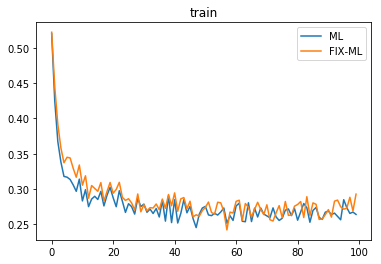

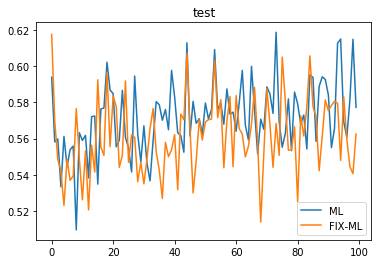

In [57]:
# THIS IS A TYPICAL RUN ###########

# Set parameters
n = 5 # number of support examples per task
n2 = 15 # number of query examples per task
d = 50 # ambient dimension
k = 10 # actual subspace dimension of the weights (used in data generation)  
k_hat = 300 # subspace dimension we learn (used in prediction)
T = 15 # total number of tasks
M = 10000 # total number of X matrix of shape n \times d
m = 20 # no of support sets in fixml
lr = 0.05 # learning rate for learning D
num_iterations_train = 400000 # no of train_iterations
test_frequency = 4000 # no of iterations after which we test
batchsz = 1
lambd = 2. # inner loop regularizer
device = 'cpu' # cuda uses GPU, cpu option would only perform operations on np arrays
seed = 9127
np.random.seed(seed) # set seed

        
# obtain meta-learning and fix-meta learning solns
D_true = np.stack([isotropic_gaussian(d) for _ in range(k)], axis=0).T
D_true = np.linalg.qr(D_true)[0]
D_init = np.random.randn(d, k_hat) / np.sqrt(d) # he init
D_test = D_true
# D_test = np.concatenate([D_true[:, :-1], np.random.randn(d, 1)], axis=1)


# Get Dataset

X_sigma_vec=[1./(np.linalg.norm(D_true[i, :])*np.sqrt(d)*2.) for i in range(d)]
X_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n)]) for i in range(M)]
Xq_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n2)]) for i in range(M)]
c_pool = [isotropic_gaussian(k) for i in range(T)]


if device == 'cuda':
    D_true = torch.FloatTensor(D_true).cuda()
    D_init = torch.FloatTensor(D_init).cuda()
    D_test = torch.FloatTensor(D_test).cuda()


np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
metal_avg_train_loss, metal_avg_test_loss, D_ML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=False, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)
np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
fix_metal_avg_train_loss, fix_metal_avg_test_loss, D_FIXML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=True, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)

# plots
plt.plot(list(range(len(metal_avg_train_loss))), metal_avg_train_loss, label='ML')
plt.plot(list(range(len(fix_metal_avg_train_loss))), fix_metal_avg_train_loss, label='FIX-ML')
plt.title('train')
plt.legend()
plt.show()

plt.plot(list(range(num_iterations_train // test_frequency)), metal_avg_test_loss, label='ML')
plt.plot(list(range(num_iterations_train // test_frequency)), fix_metal_avg_test_loss, label='FIX-ML')
plt.title('test')
plt.legend()
plt.show()



  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 96/100000 [00:00<01:44, 954.13it/s]

  0%|          | 179/100000 [00:00<01:49, 912.91it/s]

  0%|          | 266/100000 [00:00<01:51, 898.06it/s]

  0%|          | 353/100000 [00:00<01:52, 888.32it/s]

  0%|          | 440/100000 [00:00<01:52, 881.73it/s]

  1%|          | 527/100000 [00:00<01:53, 876.85it/s]

  1%|          | 614/100000 [00:00<01:53, 873.35it/s]

  1%|          | 701/100000 [00:00<01:54, 870.05it/s]

  1%|          | 789/100000 [00:00<01:53, 870.43it/s]

  1%|          | 873/100000 [00:01<01:55, 860.90it/s]

  1%|          | 959/100000 [00:01<01:55, 857.80it/s]

  1%|          | 1046/100000 [00:01<01:55, 859.14it/s]

  1%|          | 1134/100000 [00:01<01:54, 863.03it/s]

  1%|          | 1220/100000 [00:01<01:55, 854.30it/s]

  1%|▏         | 1305/100000 [00:01<02:16, 725.15it/s]

  1%|▏         | 1381/100000 [00:01<02:22, 691.08it/s]

  1%|▏         | 1468/100000 [00:01<02:13, 736.21it/s]

  2%|▏        

 11%|█▏        | 11302/100000 [00:17<01:53, 783.17it/s]

 11%|█▏        | 11381/100000 [00:17<01:52, 785.14it/s]

 11%|█▏        | 11460/100000 [00:17<01:52, 785.76it/s]

 12%|█▏        | 11539/100000 [00:17<01:52, 785.57it/s]

 12%|█▏        | 11618/100000 [00:17<01:54, 775.27it/s]

 12%|█▏        | 11696/100000 [00:17<02:31, 583.04it/s]

 12%|█▏        | 11762/100000 [00:17<02:28, 592.62it/s]

 12%|█▏        | 11840/100000 [00:18<02:18, 636.97it/s]

 12%|█▏        | 11911/100000 [00:18<02:14, 656.31it/s]

 12%|█▏        | 11980/100000 [00:18<02:31, 582.65it/s]

 12%|█▏        | 12043/100000 [00:20<15:39, 93.58it/s] 

 12%|█▏        | 12121/100000 [00:20<11:31, 127.14it/s]

 12%|█▏        | 12200/100000 [00:20<08:36, 169.86it/s]

 12%|█▏        | 12275/100000 [00:20<06:36, 221.09it/s]

 12%|█▏        | 12354/100000 [00:20<05:10, 281.97it/s]

 12%|█▏        | 12433/100000 [00:20<04:10, 349.17it/s]

 13%|█▎        | 12506/100000 [00:20<03:32, 412.02it/s]

 13%|█▎        | 12585/100000 [

 21%|██        | 21070/100000 [00:37<02:02, 646.50it/s]

 21%|██        | 21145/100000 [00:37<01:57, 672.64it/s]

 21%|██        | 21219/100000 [00:37<01:54, 690.07it/s]

 21%|██▏       | 21291/100000 [00:37<01:53, 692.14it/s]

 21%|██▏       | 21366/100000 [00:37<01:51, 707.62it/s]

 21%|██▏       | 21438/100000 [00:37<01:50, 709.99it/s]

 22%|██▏       | 21513/100000 [00:37<01:49, 720.05it/s]

 22%|██▏       | 21588/100000 [00:37<01:47, 726.83it/s]

 22%|██▏       | 21663/100000 [00:37<01:46, 732.24it/s]

 22%|██▏       | 21737/100000 [00:38<01:47, 728.10it/s]

 22%|██▏       | 21811/100000 [00:38<01:51, 699.75it/s]

 22%|██▏       | 21882/100000 [00:38<02:01, 644.63it/s]

 22%|██▏       | 21953/100000 [00:38<01:57, 662.16it/s]

 22%|██▏       | 22028/100000 [00:38<01:53, 685.62it/s]

 22%|██▏       | 22098/100000 [00:38<02:09, 603.18it/s]

 22%|██▏       | 22161/100000 [00:38<02:12, 585.99it/s]

 22%|██▏       | 22237/100000 [00:38<02:03, 628.86it/s]

 22%|██▏       | 22324/100000 [

 32%|███▏      | 31561/100000 [00:54<01:19, 856.43it/s]

 32%|███▏      | 31647/100000 [00:54<01:22, 824.45it/s]

 32%|███▏      | 31734/100000 [00:54<01:21, 836.22it/s]

 32%|███▏      | 31821/100000 [00:54<01:20, 844.93it/s]

 32%|███▏      | 31908/100000 [00:54<01:19, 851.55it/s]

 32%|███▏      | 31994/100000 [00:54<01:20, 848.12it/s]

 32%|███▏      | 32079/100000 [00:56<08:00, 141.34it/s]

 32%|███▏      | 32166/100000 [00:56<05:59, 188.63it/s]

 32%|███▏      | 32235/100000 [00:56<04:46, 236.71it/s]

 32%|███▏      | 32322/100000 [00:56<03:43, 302.58it/s]

 32%|███▏      | 32409/100000 [00:56<02:59, 375.91it/s]

 32%|███▏      | 32496/100000 [00:56<02:28, 453.07it/s]

 33%|███▎      | 32584/100000 [00:57<02:07, 529.55it/s]

 33%|███▎      | 32666/100000 [00:57<01:59, 565.10it/s]

 33%|███▎      | 32744/100000 [00:57<02:02, 550.79it/s]

 33%|███▎      | 32814/100000 [00:57<02:13, 503.54it/s]

 33%|███▎      | 32898/100000 [00:57<01:57, 571.45it/s]

 33%|███▎      | 32981/100000 [

 42%|████▏     | 42116/100000 [01:13<01:15, 761.98it/s]

 42%|████▏     | 42193/100000 [01:13<01:16, 757.27it/s]

 42%|████▏     | 42269/100000 [01:13<01:39, 578.18it/s]

 42%|████▏     | 42334/100000 [01:13<01:43, 555.97it/s]

 42%|████▏     | 42411/100000 [01:13<01:35, 605.92it/s]

 42%|████▏     | 42489/100000 [01:13<01:28, 647.54it/s]

 43%|████▎     | 42567/100000 [01:13<01:24, 681.53it/s]

 43%|████▎     | 42645/100000 [01:14<01:20, 708.18it/s]

 43%|████▎     | 42723/100000 [01:14<01:18, 727.26it/s]

 43%|████▎     | 42798/100000 [01:14<01:19, 715.58it/s]

 43%|████▎     | 42876/100000 [01:14<01:17, 732.57it/s]

 43%|████▎     | 42951/100000 [01:14<01:18, 727.91it/s]

 43%|████▎     | 43028/100000 [01:14<01:17, 739.47it/s]

 43%|████▎     | 43103/100000 [01:14<01:17, 737.84it/s]

 43%|████▎     | 43181/100000 [01:14<01:15, 747.95it/s]

 43%|████▎     | 43259/100000 [01:14<01:14, 756.58it/s]

 43%|████▎     | 43337/100000 [01:14<01:14, 763.02it/s]

 43%|████▎     | 43415/100000 [

 52%|█████▏    | 52127/100000 [01:33<05:22, 148.36it/s]

 52%|█████▏    | 52205/100000 [01:33<04:04, 195.79it/s]

 52%|█████▏    | 52282/100000 [01:33<03:09, 252.17it/s]

 52%|█████▏    | 52358/100000 [01:33<02:31, 314.92it/s]

 52%|█████▏    | 52436/100000 [01:33<02:04, 382.82it/s]

 53%|█████▎    | 52509/100000 [01:33<01:48, 436.15it/s]

 53%|█████▎    | 52586/100000 [01:33<01:34, 500.98it/s]

 53%|█████▎    | 52667/100000 [01:33<01:23, 564.96it/s]

 53%|█████▎    | 52745/100000 [01:33<01:16, 614.13it/s]

 53%|█████▎    | 52821/100000 [01:34<01:13, 642.10it/s]

 53%|█████▎    | 52898/100000 [01:34<01:09, 675.66it/s]

 53%|█████▎    | 52976/100000 [01:34<01:06, 702.09it/s]

 53%|█████▎    | 53052/100000 [01:34<01:05, 718.10it/s]

 53%|█████▎    | 53128/100000 [01:34<01:44, 446.79it/s]

 53%|█████▎    | 53204/100000 [01:34<01:31, 509.09it/s]

 53%|█████▎    | 53290/100000 [01:34<01:20, 579.77it/s]

 53%|█████▎    | 53365/100000 [01:34<01:14, 622.09it/s]

 53%|█████▎    | 53446/100000 [

 63%|██████▎   | 63056/100000 [01:50<00:42, 867.51it/s]

 63%|██████▎   | 63143/100000 [01:50<00:46, 800.91it/s]

 63%|██████▎   | 63225/100000 [01:50<00:51, 714.21it/s]

 63%|██████▎   | 63299/100000 [01:50<00:54, 675.27it/s]

 63%|██████▎   | 63369/100000 [01:50<00:56, 645.05it/s]

 63%|██████▎   | 63452/100000 [01:50<00:52, 691.06it/s]

 64%|██████▎   | 63552/100000 [01:51<00:47, 760.67it/s]

 64%|██████▎   | 63640/100000 [01:51<00:45, 790.93it/s]

 64%|██████▎   | 63727/100000 [01:51<00:44, 812.09it/s]

 64%|██████▍   | 63814/100000 [01:51<00:43, 827.15it/s]

 64%|██████▍   | 63901/100000 [01:51<00:43, 839.33it/s]

 64%|██████▍   | 63987/100000 [01:51<00:47, 759.05it/s]

 64%|██████▍   | 64066/100000 [01:53<04:41, 127.74it/s]

 64%|██████▍   | 64153/100000 [01:53<03:28, 171.63it/s]

 64%|██████▍   | 64241/100000 [01:53<02:38, 226.08it/s]

 64%|██████▍   | 64328/100000 [01:53<02:02, 290.36it/s]

 64%|██████▍   | 64415/100000 [01:53<01:38, 362.82it/s]

 65%|██████▍   | 64503/100000 [

 74%|███████▍  | 73865/100000 [02:09<00:36, 717.97it/s]

 74%|███████▍  | 73938/100000 [02:10<00:37, 694.74it/s]

 74%|███████▍  | 74014/100000 [02:10<00:36, 710.97it/s]

 74%|███████▍  | 74090/100000 [02:10<00:35, 723.51it/s]

 74%|███████▍  | 74163/100000 [02:10<00:36, 706.65it/s]

 74%|███████▍  | 74237/100000 [02:10<00:36, 714.13it/s]

 74%|███████▍  | 74312/100000 [02:10<00:35, 722.27it/s]

 74%|███████▍  | 74387/100000 [02:10<00:35, 728.19it/s]

 74%|███████▍  | 74462/100000 [02:10<00:34, 732.39it/s]

 75%|███████▍  | 74536/100000 [02:10<00:35, 714.88it/s]

 75%|███████▍  | 74611/100000 [02:10<00:35, 723.42it/s]

 75%|███████▍  | 74686/100000 [02:11<00:34, 729.53it/s]

 75%|███████▍  | 74760/100000 [02:11<00:35, 707.57it/s]

 75%|███████▍  | 74835/100000 [02:11<00:35, 717.83it/s]

 75%|███████▍  | 74910/100000 [02:11<00:34, 725.54it/s]

 75%|███████▍  | 74983/100000 [02:11<00:43, 580.65it/s]

 75%|███████▌  | 75054/100000 [02:11<00:40, 612.75it/s]

 75%|███████▌  | 75127/100000 [

 85%|████████▍ | 84563/100000 [02:28<00:29, 523.12it/s]

 85%|████████▍ | 84649/100000 [02:28<00:25, 592.38it/s]

 85%|████████▍ | 84736/100000 [02:29<00:23, 654.72it/s]

 85%|████████▍ | 84823/100000 [02:29<00:21, 706.51it/s]

 85%|████████▍ | 84908/100000 [02:29<00:21, 706.24it/s]

 85%|████████▍ | 84995/100000 [02:29<00:20, 748.04it/s]

 85%|████████▌ | 85080/100000 [02:29<00:19, 773.95it/s]

 85%|████████▌ | 85167/100000 [02:29<00:18, 799.16it/s]

 85%|████████▌ | 85254/100000 [02:29<00:18, 818.08it/s]

 85%|████████▌ | 85341/100000 [02:29<00:17, 830.79it/s]

 85%|████████▌ | 85428/100000 [02:29<00:17, 841.77it/s]

 86%|████████▌ | 85515/100000 [02:29<00:17, 849.01it/s]

 86%|████████▌ | 85601/100000 [02:30<00:20, 694.03it/s]

 86%|████████▌ | 85676/100000 [02:30<00:28, 506.58it/s]

 86%|████████▌ | 85754/100000 [02:30<00:25, 565.83it/s]

 86%|████████▌ | 85842/100000 [02:30<00:22, 632.42it/s]

 86%|████████▌ | 85929/100000 [02:30<00:20, 687.46it/s]

 86%|████████▌ | 86016/100000 [

 96%|█████████▌| 95618/100000 [02:46<00:05, 828.73it/s]

 96%|█████████▌| 95704/100000 [02:46<00:05, 837.85it/s]

 96%|█████████▌| 95788/100000 [02:46<00:05, 821.91it/s]

 96%|█████████▌| 95871/100000 [02:46<00:05, 801.81it/s]

 96%|█████████▌| 95957/100000 [02:46<00:04, 818.38it/s]

 96%|█████████▌| 96040/100000 [02:48<00:26, 147.09it/s]

 96%|█████████▌| 96099/100000 [02:48<00:21, 184.02it/s]

 96%|█████████▌| 96179/100000 [02:48<00:15, 239.28it/s]

 96%|█████████▋| 96258/100000 [02:48<00:12, 302.28it/s]

 96%|█████████▋| 96331/100000 [02:48<00:10, 355.52it/s]

 96%|█████████▋| 96418/100000 [02:48<00:08, 431.55it/s]

 97%|█████████▋| 96501/100000 [02:48<00:06, 504.04it/s]

 97%|█████████▋| 96588/100000 [02:48<00:05, 576.80it/s]

 97%|█████████▋| 96675/100000 [02:49<00:05, 641.59it/s]

 97%|█████████▋| 96762/100000 [02:49<00:04, 695.41it/s]

 97%|█████████▋| 96845/100000 [02:49<00:04, 717.49it/s]

 97%|█████████▋| 96932/100000 [02:49<00:04, 755.88it/s]

 97%|█████████▋| 97016/100000 [

Running with fixSupport of size 20




  0%|          | 175/100000 [00:00<01:53, 878.06it/s]

  0%|          | 262/100000 [00:00<01:54, 874.56it/s]

  0%|          | 350/100000 [00:00<01:54, 873.12it/s]

  0%|          | 437/100000 [00:00<01:54, 870.50it/s]

  1%|          | 525/100000 [00:00<01:54, 870.16it/s]

  1%|          | 606/100000 [00:00<01:57, 847.98it/s]

  1%|          | 694/100000 [00:00<01:56, 854.48it/s]

  1%|          | 781/100000 [00:00<01:55, 858.17it/s]

  1%|          | 864/100000 [00:01<02:03, 801.30it/s]

  1%|          | 946/100000 [00:01<02:03, 804.89it/s]

  1%|          | 1033/100000 [00:01<02:00, 821.45it/s]

  1%|          | 1117/100000 [00:01<01:59, 824.78it/s]

  1%|          | 1204/100000 [00:01<01:58, 837.09it/s]

  1%|▏         | 1292/100000 [00:01<01:56, 847.27it/s]

  1%|▏         | 1379/100000 [00:01<01:55, 853.31it/s]

  1%|▏         | 1466/100000 [00:01<01:54, 858.19it/s]

  2%|▏         | 1552/100000 [00:01<01:56, 844.14it/s]

  2%|▏         | 1639/100000 [00:01<01:55, 850.30it/s]



 11%|█▏        | 11453/100000 [00:17<02:02, 724.32it/s]

 12%|█▏        | 11532/100000 [00:17<02:10, 678.70it/s]

 12%|█▏        | 11618/100000 [00:18<02:02, 723.55it/s]

 12%|█▏        | 11704/100000 [00:18<01:56, 757.78it/s]

 12%|█▏        | 11791/100000 [00:18<01:52, 787.07it/s]

 12%|█▏        | 11875/100000 [00:18<01:49, 801.61it/s]

 12%|█▏        | 11959/100000 [00:18<01:48, 811.83it/s]

 12%|█▏        | 12042/100000 [00:20<10:41, 137.10it/s]

 12%|█▏        | 12102/100000 [00:20<08:13, 178.08it/s]

 12%|█▏        | 12188/100000 [00:20<06:15, 233.60it/s]

 12%|█▏        | 12274/100000 [00:20<04:53, 298.79it/s]

 12%|█▏        | 12360/100000 [00:20<03:56, 371.29it/s]

 12%|█▏        | 12447/100000 [00:20<03:15, 447.63it/s]

 13%|█▎        | 12533/100000 [00:20<02:47, 522.76it/s]

 13%|█▎        | 12620/100000 [00:20<02:27, 592.77it/s]

 13%|█▎        | 12705/100000 [00:21<02:14, 650.92it/s]

 13%|█▎        | 12789/100000 [00:21<02:10, 669.46it/s]

 13%|█▎        | 12875/100000 [

 23%|██▎       | 22514/100000 [00:36<01:37, 794.99it/s]

 23%|██▎       | 22601/100000 [00:36<01:34, 815.64it/s]

 23%|██▎       | 22689/100000 [00:36<01:33, 831.26it/s]

 23%|██▎       | 22776/100000 [00:37<01:31, 840.14it/s]

 23%|██▎       | 22861/100000 [00:37<01:33, 825.02it/s]

 23%|██▎       | 22948/100000 [00:37<01:31, 837.79it/s]

 23%|██▎       | 23036/100000 [00:37<01:30, 848.12it/s]

 23%|██▎       | 23124/100000 [00:37<01:29, 856.01it/s]

 23%|██▎       | 23212/100000 [00:37<01:29, 861.39it/s]

 23%|██▎       | 23300/100000 [00:37<01:28, 866.01it/s]

 23%|██▎       | 23388/100000 [00:37<01:28, 867.48it/s]

 23%|██▎       | 23475/100000 [00:37<01:32, 831.65it/s]

 24%|██▎       | 23563/100000 [00:38<01:30, 843.28it/s]

 24%|██▎       | 23648/100000 [00:38<01:36, 788.38it/s]

 24%|██▎       | 23728/100000 [00:38<01:49, 698.73it/s]

 24%|██▍       | 23801/100000 [00:38<01:49, 696.61it/s]

 24%|██▍       | 23888/100000 [00:38<01:42, 740.00it/s]

 24%|██▍       | 23975/100000 [

 33%|███▎      | 33260/100000 [00:55<01:20, 833.34it/s]

 33%|███▎      | 33346/100000 [00:56<01:26, 767.30it/s]

 33%|███▎      | 33433/100000 [00:56<01:23, 793.82it/s]

 34%|███▎      | 33520/100000 [00:56<01:21, 814.58it/s]

 34%|███▎      | 33607/100000 [00:56<01:20, 829.67it/s]

 34%|███▎      | 33692/100000 [00:56<01:23, 790.86it/s]

 34%|███▍      | 33779/100000 [00:56<01:21, 811.40it/s]

 34%|███▍      | 33866/100000 [00:56<01:20, 826.55it/s]

 34%|███▍      | 33950/100000 [00:56<01:34, 702.52it/s]

 34%|███▍      | 34025/100000 [00:56<01:37, 676.63it/s]

 34%|███▍      | 34100/100000 [00:57<01:34, 695.07it/s]

 34%|███▍      | 34186/100000 [00:57<01:29, 735.49it/s]

 34%|███▍      | 34262/100000 [00:57<01:30, 726.03it/s]

 34%|███▍      | 34349/100000 [00:57<01:26, 762.35it/s]

 34%|███▍      | 34437/100000 [00:57<01:22, 791.62it/s]

 35%|███▍      | 34524/100000 [00:57<01:20, 812.93it/s]

 35%|███▍      | 34607/100000 [00:57<01:23, 785.68it/s]

 35%|███▍      | 34687/100000 [

 44%|████▍     | 44011/100000 [01:14<07:04, 132.02it/s]

 44%|████▍     | 44095/100000 [01:14<05:16, 176.64it/s]

 44%|████▍     | 44180/100000 [01:15<04:00, 231.71it/s]

 44%|████▍     | 44268/100000 [01:15<03:07, 297.14it/s]

 44%|████▍     | 44345/100000 [01:15<02:42, 342.08it/s]

 44%|████▍     | 44415/100000 [01:15<02:26, 380.64it/s]

 44%|████▍     | 44479/100000 [01:15<02:26, 379.17it/s]

 45%|████▍     | 44566/100000 [01:15<02:01, 456.34it/s]

 45%|████▍     | 44653/100000 [01:15<01:44, 531.60it/s]

 45%|████▍     | 44740/100000 [01:15<01:31, 601.13it/s]

 45%|████▍     | 44827/100000 [01:16<01:23, 662.22it/s]

 45%|████▍     | 44914/100000 [01:16<01:17, 713.12it/s]

 45%|████▌     | 45001/100000 [01:16<01:13, 753.08it/s]

 45%|████▌     | 45088/100000 [01:16<01:10, 784.15it/s]

 45%|████▌     | 45173/100000 [01:16<01:11, 765.48it/s]

 45%|████▌     | 45260/100000 [01:16<01:09, 792.29it/s]

 45%|████▌     | 45347/100000 [01:16<01:07, 813.35it/s]

 45%|████▌     | 45435/100000 [

 55%|█████▌    | 55049/100000 [01:32<01:01, 736.05it/s]

 55%|█████▌    | 55127/100000 [01:32<00:59, 748.68it/s]

 55%|█████▌    | 55206/100000 [01:32<00:59, 758.04it/s]

 55%|█████▌    | 55285/100000 [01:32<00:58, 764.53it/s]

 55%|█████▌    | 55364/100000 [01:32<00:57, 769.99it/s]

 55%|█████▌    | 55442/100000 [01:33<00:57, 769.83it/s]

 56%|█████▌    | 55521/100000 [01:33<00:57, 772.87it/s]

 56%|█████▌    | 55599/100000 [01:33<01:00, 736.39it/s]

 56%|█████▌    | 55678/100000 [01:33<00:59, 749.43it/s]

 56%|█████▌    | 55755/100000 [01:33<00:58, 753.02it/s]

 56%|█████▌    | 55834/100000 [01:33<00:58, 761.32it/s]

 56%|█████▌    | 55911/100000 [01:33<01:02, 701.01it/s]

 56%|█████▌    | 55986/100000 [01:33<01:01, 713.65it/s]

 56%|█████▌    | 56059/100000 [01:35<07:00, 104.48it/s]

 56%|█████▌    | 56137/100000 [01:35<05:10, 141.13it/s]

 56%|█████▌    | 56201/100000 [01:36<03:58, 184.00it/s]

 56%|█████▋    | 56268/100000 [01:36<03:14, 224.61it/s]

 56%|█████▋    | 56333/100000 [

 65%|██████▌   | 65299/100000 [01:52<00:42, 825.39it/s]

 65%|██████▌   | 65386/100000 [01:52<00:41, 838.27it/s]

 65%|██████▌   | 65473/100000 [01:52<00:40, 846.54it/s]

 66%|██████▌   | 65560/100000 [01:52<00:40, 851.64it/s]

 66%|██████▌   | 65646/100000 [01:52<00:43, 785.42it/s]

 66%|██████▌   | 65728/100000 [01:52<00:43, 793.44it/s]

 66%|██████▌   | 65812/100000 [01:52<00:42, 806.47it/s]

 66%|██████▌   | 65897/100000 [01:52<00:41, 817.21it/s]

 66%|██████▌   | 65981/100000 [01:52<00:41, 823.72it/s]

 66%|██████▌   | 66066/100000 [01:52<00:40, 829.55it/s]

 66%|██████▌   | 66150/100000 [01:53<00:40, 831.04it/s]

 66%|██████▌   | 66234/100000 [01:53<00:40, 832.90it/s]

 66%|██████▋   | 66319/100000 [01:53<00:40, 835.48it/s]

 66%|██████▋   | 66403/100000 [01:53<00:40, 836.15it/s]

 66%|██████▋   | 66487/100000 [01:53<00:40, 829.15it/s]

 67%|██████▋   | 66571/100000 [01:53<00:40, 831.22it/s]

 67%|██████▋   | 66655/100000 [01:53<00:48, 683.79it/s]

 67%|██████▋   | 66738/100000 [

 76%|███████▌  | 75644/100000 [02:09<00:29, 816.02it/s]

 76%|███████▌  | 75727/100000 [02:09<00:30, 784.52it/s]

 76%|███████▌  | 75814/100000 [02:09<00:29, 806.29it/s]

 76%|███████▌  | 75900/100000 [02:09<00:29, 821.55it/s]

 76%|███████▌  | 75986/100000 [02:10<00:28, 832.68it/s]

 76%|███████▌  | 76070/100000 [02:12<03:05, 128.79it/s]

 76%|███████▌  | 76133/100000 [02:12<02:21, 169.08it/s]

 76%|███████▌  | 76211/100000 [02:12<01:47, 220.97it/s]

 76%|███████▋  | 76290/100000 [02:12<01:24, 281.55it/s]

 76%|███████▋  | 76369/100000 [02:12<01:07, 348.49it/s]

 76%|███████▋  | 76448/100000 [02:12<00:56, 418.22it/s]

 77%|███████▋  | 76527/100000 [02:12<00:48, 486.39it/s]

 77%|███████▋  | 76606/100000 [02:12<00:42, 548.30it/s]

 77%|███████▋  | 76685/100000 [02:12<00:38, 602.38it/s]

 77%|███████▋  | 76762/100000 [02:12<00:37, 619.27it/s]

 77%|███████▋  | 76840/100000 [02:13<00:35, 659.48it/s]

 77%|███████▋  | 76919/100000 [02:13<00:33, 691.71it/s]

 77%|███████▋  | 76998/100000 [

 87%|████████▋ | 86676/100000 [02:28<00:15, 843.76it/s]

 87%|████████▋ | 86761/100000 [02:29<00:16, 820.58it/s]

 87%|████████▋ | 86845/100000 [02:29<00:15, 824.96it/s]

 87%|████████▋ | 86932/100000 [02:29<00:15, 836.98it/s]

 87%|████████▋ | 87019/100000 [02:29<00:15, 844.94it/s]

 87%|████████▋ | 87106/100000 [02:29<00:15, 851.14it/s]

 87%|████████▋ | 87193/100000 [02:29<00:14, 855.71it/s]

 87%|████████▋ | 87279/100000 [02:29<00:17, 727.08it/s]

 87%|████████▋ | 87356/100000 [02:29<00:21, 588.11it/s]

 87%|████████▋ | 87443/100000 [02:29<00:19, 650.22it/s]

 88%|████████▊ | 87528/100000 [02:30<00:17, 698.94it/s]

 88%|████████▊ | 87605/100000 [02:30<00:17, 717.76it/s]

 88%|████████▊ | 87693/100000 [02:30<00:16, 757.99it/s]

 88%|████████▊ | 87780/100000 [02:30<00:15, 787.76it/s]

 88%|████████▊ | 87868/100000 [02:30<00:14, 811.42it/s]

 88%|████████▊ | 87955/100000 [02:30<00:14, 827.88it/s]

 88%|████████▊ | 88040/100000 [02:32<01:25, 139.25it/s]

 88%|████████▊ | 88126/100000 [

 97%|█████████▋| 97443/100000 [02:48<00:03, 813.83it/s]

 98%|█████████▊| 97526/100000 [02:48<00:03, 719.69it/s]

 98%|█████████▊| 97607/100000 [02:48<00:03, 743.94it/s]

 98%|█████████▊| 97692/100000 [02:48<00:02, 770.94it/s]

 98%|█████████▊| 97777/100000 [02:48<00:02, 791.55it/s]

 98%|█████████▊| 97862/100000 [02:48<00:02, 806.42it/s]

 98%|█████████▊| 97947/100000 [02:48<00:02, 817.73it/s]

 98%|█████████▊| 98032/100000 [02:48<00:02, 825.30it/s]

 98%|█████████▊| 98116/100000 [02:48<00:02, 829.18it/s]

 98%|█████████▊| 98200/100000 [02:48<00:02, 789.29it/s]

 98%|█████████▊| 98280/100000 [02:49<00:02, 788.59it/s]

 98%|█████████▊| 98364/100000 [02:49<00:02, 801.49it/s]

 98%|█████████▊| 98448/100000 [02:49<00:01, 810.07it/s]

 99%|█████████▊| 98530/100000 [02:49<00:01, 735.03it/s]

 99%|█████████▊| 98613/100000 [02:49<00:01, 760.98it/s]

 99%|█████████▊| 98696/100000 [02:49<00:01, 780.40it/s]

 99%|█████████▉| 98780/100000 [02:49<00:01, 795.56it/s]

 99%|█████████▉| 98864/100000 [

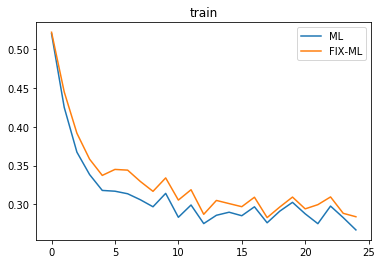

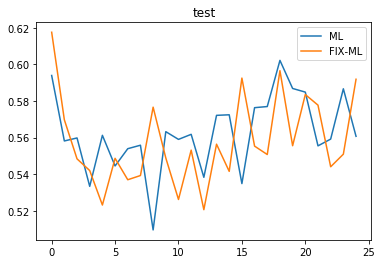

In [58]:
# THIS IS A TYPICAL RUN ###########

# Set parameters
n = 5 # number of support examples per task
n2 = 15 # number of query examples per task
d = 50 # ambient dimension
k = 10 # actual subspace dimension of the weights (used in data generation)  
k_hat = 300 # subspace dimension we learn (used in prediction)
T = 15 # total number of tasks
M = 10000 # total number of X matrix of shape n \times d
m = 20 # no of support sets in fixml
lr = 0.05 # learning rate for learning D
num_iterations_train = 100000 # no of train_iterations
test_frequency = 4000 # no of iterations after which we test
batchsz = 1
lambd = 2. # inner loop regularizer
device = 'cpu' # cuda uses GPU, cpu option would only perform operations on np arrays
seed = 9127
np.random.seed(seed) # set seed

        
# obtain meta-learning and fix-meta learning solns
D_true = np.stack([isotropic_gaussian(d) for _ in range(k)], axis=0).T
D_true = np.linalg.qr(D_true)[0]
D_init = np.random.randn(d, k_hat) / np.sqrt(d) # he init
D_test = D_true
# D_test = np.concatenate([D_true[:, :-1], np.random.randn(d, 1)], axis=1)


# Get Dataset

X_sigma_vec=[1./(np.linalg.norm(D_true[i, :])*np.sqrt(d)*2.) for i in range(d)]
X_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n)]) for i in range(M)]
Xq_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n2)]) for i in range(M)]
c_pool = [isotropic_gaussian(k) for i in range(T)]


if device == 'cuda':
    D_true = torch.FloatTensor(D_true).cuda()
    D_init = torch.FloatTensor(D_init).cuda()
    D_test = torch.FloatTensor(D_test).cuda()


np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
metal_avg_train_loss, metal_avg_test_loss, D_ML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=False, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)
np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
fix_metal_avg_train_loss, fix_metal_avg_test_loss, D_FIXML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=True, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)

# plots
plt.plot(list(range(len(metal_avg_train_loss))), metal_avg_train_loss, label='ML')
plt.plot(list(range(len(fix_metal_avg_train_loss))), fix_metal_avg_train_loss, label='FIX-ML')
plt.title('train')
plt.legend()
plt.show()

plt.plot(list(range(num_iterations_train // test_frequency)), metal_avg_test_loss, label='ML')
plt.plot(list(range(num_iterations_train // test_frequency)), fix_metal_avg_test_loss, label='FIX-ML')
plt.title('test')
plt.show()



  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 475/100000 [00:00<00:20, 4746.15it/s]

  1%|          | 948/100000 [00:00<00:20, 4739.59it/s]

  1%|▏         | 1415/100000 [00:00<00:20, 4715.73it/s]

  2%|▏         | 1892/100000 [00:00<00:20, 4730.07it/s]

  2%|▏         | 2360/100000 [00:00<00:20, 4714.52it/s]

  3%|▎         | 2827/100000 [00:00<00:20, 4700.80it/s]

  3%|▎         | 3301/100000 [00:00<00:20, 4710.48it/s]

  4%|▍         | 3770/100000 [00:00<00:20, 4644.30it/s]

  4%|▍         | 4208/100000 [00:01<00:49, 1952.93it/s]

  5%|▍         | 4664/100000 [00:01<00:40, 2356.79it/s]

  5%|▌         | 5122/100000 [00:01<00:34, 2757.78it/s]

  6%|▌         | 5584/100000 [00:01<00:30, 3136.91it/s]

  6%|▌         | 6045/100000 [00:01<00:27, 3468.83it/s]

  7%|▋         | 6505/100000 [00:01<00:24, 3743.44it/s]

  7%|▋         | 6970/100000 [00:01<00:23, 3974.29it/s]

  7%|▋         | 7440/100000 [00:02<00:22, 4167.32it/s]

  8%|▊         | 7902/100000 [00:02<00:21, 4

 60%|██████    | 60258/100000 [00:19<00:20, 1982.77it/s]

 61%|██████    | 60722/100000 [00:19<00:16, 2393.69it/s]

 61%|██████    | 61191/100000 [00:19<00:13, 2805.38it/s]

 62%|██████▏   | 61661/100000 [00:19<00:12, 3190.64it/s]

 62%|██████▏   | 62141/100000 [00:19<00:10, 3546.89it/s]

 63%|██████▎   | 62607/100000 [00:19<00:09, 3819.83it/s]

 63%|██████▎   | 63086/100000 [00:19<00:09, 4066.02it/s]

 64%|██████▎   | 63564/100000 [00:19<00:08, 4255.63it/s]

 64%|██████▍   | 64029/100000 [00:20<00:18, 1974.57it/s]

 64%|██████▍   | 64500/100000 [00:20<00:14, 2390.53it/s]

 65%|██████▍   | 64970/100000 [00:20<00:12, 2803.73it/s]

 65%|██████▌   | 65442/100000 [00:20<00:10, 3191.89it/s]

 66%|██████▌   | 65918/100000 [00:20<00:09, 3541.61it/s]

 66%|██████▋   | 66395/100000 [00:20<00:08, 3838.05it/s]

 67%|██████▋   | 66859/100000 [00:21<00:08, 4046.04it/s]

 67%|██████▋   | 67336/100000 [00:21<00:07, 4237.72it/s]

 68%|██████▊   | 67806/100000 [00:21<00:07, 4365.18it/s]

 68%|██████▊  

Running with fixSupport of size 20




  1%|          | 974/100000 [00:00<00:20, 4890.15it/s]

  1%|▏         | 1457/100000 [00:00<00:20, 4870.06it/s]

  2%|▏         | 1942/100000 [00:00<00:20, 4863.44it/s]

  2%|▏         | 2427/100000 [00:00<00:20, 4858.09it/s]

  3%|▎         | 2904/100000 [00:00<00:20, 4830.31it/s]

  3%|▎         | 3388/100000 [00:00<00:19, 4831.45it/s]

  4%|▍         | 3873/100000 [00:00<00:19, 4835.64it/s]

  4%|▍         | 4329/100000 [00:01<00:46, 2052.46it/s]

  5%|▍         | 4800/100000 [00:01<00:38, 2470.24it/s]

  5%|▌         | 5276/100000 [00:01<00:32, 2886.63it/s]

  6%|▌         | 5752/100000 [00:01<00:28, 3272.12it/s]

  6%|▌         | 6229/100000 [00:01<00:25, 3611.90it/s]

  7%|▋         | 6706/100000 [00:01<00:23, 3894.79it/s]

  7%|▋         | 7182/100000 [00:01<00:22, 4117.74it/s]

  8%|▊         | 7661/100000 [00:02<00:21, 4298.21it/s]

  8%|▊         | 8127/100000 [00:02<00:45, 2006.42it/s]

  9%|▊         | 8608/100000 [00:02<00:37, 2431.32it/s]

  9%|▉         | 9085/100000 [

 62%|██████▏   | 61524/100000 [00:19<00:13, 2804.54it/s]

 62%|██████▏   | 61951/100000 [00:19<00:12, 3125.55it/s]

 62%|██████▏   | 62380/100000 [00:19<00:11, 3401.37it/s]

 63%|██████▎   | 62806/100000 [00:19<00:10, 3620.08it/s]

 63%|██████▎   | 63233/100000 [00:19<00:09, 3791.19it/s]

 64%|██████▎   | 63664/100000 [00:20<00:09, 3932.47it/s]

 64%|██████▍   | 64087/100000 [00:20<00:21, 1679.78it/s]

 65%|██████▍   | 64513/100000 [00:20<00:17, 2052.49it/s]

 65%|██████▍   | 64942/100000 [00:20<00:14, 2433.04it/s]

 65%|██████▌   | 65371/100000 [00:20<00:12, 2795.52it/s]

 66%|██████▌   | 65803/100000 [00:21<00:10, 3125.07it/s]

 66%|██████▌   | 66228/100000 [00:21<00:09, 3394.50it/s]

 67%|██████▋   | 66656/100000 [00:21<00:09, 3618.33it/s]

 67%|██████▋   | 67083/100000 [00:21<00:08, 3791.91it/s]

 68%|██████▊   | 67509/100000 [00:21<00:08, 3920.97it/s]

 68%|██████▊   | 67936/100000 [00:21<00:07, 4018.45it/s]

 68%|██████▊   | 68359/100000 [00:22<00:18, 1684.65it/s]

 69%|██████▉  

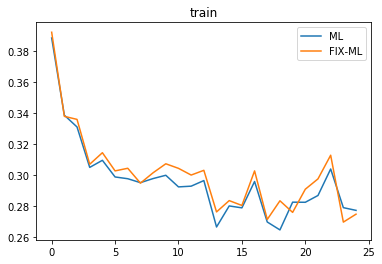

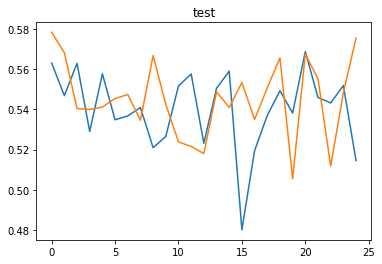

In [60]:
# THIS IS A TYPICAL RUN ###########

# Set parameters
n = 5 # number of support examples per task
n2 = 15 # number of query examples per task
d = 50 # ambient dimension
k = 10 # actual subspace dimension of the weights (used in data generation)  
k_hat = 30 # subspace dimension we learn (used in prediction)
T = 15 # total number of tasks
M = 10000 # total number of X matrix of shape n \times d
m = 20 # no of support sets in fixml
lr = 0.1 # learning rate for learning D
num_iterations_train = 100000 # no of train_iterations
test_frequency = 4000 # no of iterations after which we test
batchsz = 1
lambd = 2. # inner loop regularizer
device = 'cpu' # cuda uses GPU, cpu option would only perform operations on np arrays
seed = 9127
np.random.seed(seed) # set seed

        
# obtain meta-learning and fix-meta learning solns
D_true = np.stack([isotropic_gaussian(d) for _ in range(k)], axis=0).T
D_true = np.linalg.qr(D_true)[0]
D_init = np.random.randn(d, k_hat) / np.sqrt(d) # he init
D_test = D_true
# D_test = np.concatenate([D_true[:, :-1], np.random.randn(d, 1)], axis=1)


# Get Dataset

X_sigma_vec=[1./(np.linalg.norm(D_true[i, :])*np.sqrt(d)*2.) for i in range(d)]
X_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n)]) for i in range(M)]
Xq_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n2)]) for i in range(M)]
c_pool = [isotropic_gaussian(k) for i in range(T)]


if device == 'cuda':
    D_true = torch.FloatTensor(D_true).cuda()
    D_init = torch.FloatTensor(D_init).cuda()
    D_test = torch.FloatTensor(D_test).cuda()


np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
metal_avg_train_loss, metal_avg_test_loss, D_ML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=False, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)
np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
fix_metal_avg_train_loss, fix_metal_avg_test_loss, D_FIXML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=True, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)

# plots
plt.plot(list(range(len(metal_avg_train_loss))), metal_avg_train_loss, label='ML')
plt.plot(list(range(len(fix_metal_avg_train_loss))), fix_metal_avg_train_loss, label='FIX-ML')
plt.title('train')
plt.legend()
plt.show()

plt.plot(list(range(num_iterations_train // test_frequency)), metal_avg_test_loss, label='ML')
plt.plot(list(range(num_iterations_train // test_frequency)), fix_metal_avg_test_loss, label='FIX-ML')
plt.title('test')
plt.show()



  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 25/8000 [00:00<00:32, 245.88it/s]

  1%|          | 50/8000 [00:00<00:32, 247.01it/s]

  1%|          | 74/8000 [00:00<00:32, 244.14it/s]

  1%|          | 97/8000 [00:00<00:33, 236.91it/s]

  2%|▏         | 121/8000 [00:00<00:33, 237.11it/s]

  2%|▏         | 145/8000 [00:00<00:33, 237.28it/s]

  2%|▏         | 169/8000 [00:00<00:32, 237.73it/s]

  2%|▏         | 193/8000 [00:00<00:32, 237.98it/s]

  3%|▎         | 216/8000 [00:00<00:34, 222.78it/s]

  3%|▎         | 240/8000 [00:01<00:34, 226.96it/s]

  3%|▎         | 264/8000 [00:01<00:33, 229.98it/s]

  4%|▎         | 288/8000 [00:01<00:33, 232.62it/s]

  4%|▍         | 312/8000 [00:01<00:34, 223.88it/s]

  4%|▍         | 335/8000 [00:01<00:34, 220.00it/s]

  4%|▍         | 358/8000 [00:01<00:34, 221.79it/s]

  5%|▍         | 382/8000 [00:01<00:33, 225.84it/s]

  5%|▌         | 406/8000 [00:01<00:33, 227.36it/s]

  5%|▌         | 430/8000 [00:01<00:32, 230.21it/s]

  6%|▌

 41%|████      | 3262/8000 [00:18<00:20, 225.88it/s]

 41%|████      | 3286/8000 [00:18<00:20, 229.54it/s]

 41%|████▏     | 3310/8000 [00:18<00:20, 231.20it/s]

 42%|████▏     | 3334/8000 [00:18<00:20, 232.21it/s]

 42%|████▏     | 3358/8000 [00:18<00:19, 233.05it/s]

 42%|████▏     | 3382/8000 [00:18<00:20, 226.94it/s]

 43%|████▎     | 3406/8000 [00:19<00:20, 228.48it/s]

 43%|████▎     | 3430/8000 [00:19<00:19, 231.34it/s]

 43%|████▎     | 3455/8000 [00:19<00:19, 233.92it/s]

 43%|████▎     | 3479/8000 [00:19<00:20, 224.43it/s]

 44%|████▍     | 3502/8000 [00:19<00:20, 222.23it/s]

 44%|████▍     | 3525/8000 [00:19<00:20, 221.71it/s]

 44%|████▍     | 3549/8000 [00:19<00:19, 225.83it/s]

 45%|████▍     | 3573/8000 [00:19<00:19, 228.50it/s]

 45%|████▍     | 3597/8000 [00:19<00:19, 230.90it/s]

 45%|████▌     | 3621/8000 [00:19<00:18, 233.34it/s]

 46%|████▌     | 3645/8000 [00:20<00:25, 172.95it/s]

 46%|████▌     | 3669/8000 [00:20<00:23, 187.74it/s]

 46%|████▌     | 3693/8000 [

 81%|████████  | 6479/8000 [00:41<00:07, 214.03it/s]

 81%|████████▏ | 6503/8000 [00:42<00:06, 219.24it/s]

 82%|████████▏ | 6526/8000 [00:42<00:06, 210.99it/s]

 82%|████████▏ | 6550/8000 [00:42<00:06, 216.76it/s]

 82%|████████▏ | 6572/8000 [00:42<00:06, 216.33it/s]

 82%|████████▏ | 6595/8000 [00:42<00:06, 218.64it/s]

 83%|████████▎ | 6619/8000 [00:42<00:06, 222.81it/s]

 83%|████████▎ | 6643/8000 [00:42<00:06, 225.88it/s]

 83%|████████▎ | 6666/8000 [00:42<00:05, 226.74it/s]

 84%|████████▎ | 6690/8000 [00:42<00:05, 228.56it/s]

 84%|████████▍ | 6713/8000 [00:43<00:06, 197.08it/s]

 84%|████████▍ | 6741/8000 [00:43<00:05, 215.92it/s]

 85%|████████▍ | 6764/8000 [00:43<00:05, 218.95it/s]

 85%|████████▍ | 6787/8000 [00:43<00:06, 177.37it/s]

 85%|████████▌ | 6807/8000 [00:43<00:07, 169.34it/s]

 85%|████████▌ | 6834/8000 [00:43<00:06, 189.97it/s]

 86%|████████▌ | 6856/8000 [00:43<00:05, 197.38it/s]

 86%|████████▌ | 6880/8000 [00:43<00:05, 208.30it/s]

 86%|████████▋ | 6904/8000 [

Running with fixSupport of size 20




  1%|          | 42/8000 [00:00<00:40, 197.96it/s]

  1%|          | 67/8000 [00:00<00:37, 209.00it/s]

  1%|          | 91/8000 [00:00<00:36, 216.39it/s]

  1%|▏         | 115/8000 [00:00<00:35, 220.98it/s]

  2%|▏         | 139/8000 [00:00<00:35, 224.59it/s]

  2%|▏         | 163/8000 [00:00<00:34, 227.03it/s]

  2%|▏         | 187/8000 [00:00<00:34, 229.00it/s]

  3%|▎         | 209/8000 [00:00<00:35, 222.26it/s]

  3%|▎         | 231/8000 [00:01<00:35, 218.48it/s]

  3%|▎         | 254/8000 [00:01<00:35, 220.64it/s]

  3%|▎         | 278/8000 [00:01<00:34, 224.30it/s]

  4%|▍         | 301/8000 [00:01<00:35, 219.52it/s]

  4%|▍         | 325/8000 [00:01<00:34, 223.45it/s]

  4%|▍         | 349/8000 [00:01<00:33, 226.00it/s]

  5%|▍         | 373/8000 [00:01<00:33, 228.06it/s]

  5%|▍         | 397/8000 [00:01<00:33, 229.53it/s]

  5%|▌         | 421/8000 [00:01<00:32, 230.39it/s]

  6%|▌         | 445/8000 [00:02<00:41, 182.67it/s]

  6%|▌         | 468/8000 [00:02<00:39, 192.89i

 41%|████      | 3274/8000 [00:19<00:22, 209.51it/s]

 41%|████      | 3298/8000 [00:19<00:21, 216.05it/s]

 42%|████▏     | 3320/8000 [00:19<00:23, 196.67it/s]

 42%|████▏     | 3343/8000 [00:19<00:22, 205.51it/s]

 42%|████▏     | 3366/8000 [00:19<00:21, 212.25it/s]

 42%|████▏     | 3390/8000 [00:19<00:21, 218.05it/s]

 43%|████▎     | 3414/8000 [00:19<00:20, 222.46it/s]

 43%|████▎     | 3438/8000 [00:19<00:20, 225.49it/s]

 43%|████▎     | 3461/8000 [00:19<00:20, 224.42it/s]

 44%|████▎     | 3484/8000 [00:20<00:24, 182.21it/s]

 44%|████▍     | 3507/8000 [00:20<00:23, 192.58it/s]

 44%|████▍     | 3531/8000 [00:20<00:22, 203.08it/s]

 44%|████▍     | 3555/8000 [00:20<00:21, 211.08it/s]

 45%|████▍     | 3577/8000 [00:20<00:25, 173.53it/s]

 45%|████▍     | 3598/8000 [00:20<00:24, 182.37it/s]

 45%|████▌     | 3621/8000 [00:20<00:22, 194.39it/s]

 46%|████▌     | 3644/8000 [00:20<00:21, 202.17it/s]

 46%|████▌     | 3668/8000 [00:21<00:20, 210.16it/s]

 46%|████▌     | 3692/8000 [

 81%|████████  | 6461/8000 [00:42<00:06, 230.11it/s]

 81%|████████  | 6485/8000 [00:42<00:06, 232.64it/s]

 81%|████████▏ | 6509/8000 [00:42<00:06, 234.79it/s]

 82%|████████▏ | 6533/8000 [00:42<00:06, 222.20it/s]

 82%|████████▏ | 6557/8000 [00:43<00:06, 226.33it/s]

 82%|████████▏ | 6581/8000 [00:43<00:06, 229.99it/s]

 83%|████████▎ | 6605/8000 [00:43<00:05, 232.68it/s]

 83%|████████▎ | 6629/8000 [00:43<00:06, 220.01it/s]

 83%|████████▎ | 6653/8000 [00:43<00:06, 224.04it/s]

 83%|████████▎ | 6677/8000 [00:43<00:05, 228.39it/s]

 84%|████████▍ | 6700/8000 [00:43<00:06, 208.33it/s]

 84%|████████▍ | 6722/8000 [00:43<00:07, 167.15it/s]

 84%|████████▍ | 6741/8000 [00:44<00:08, 150.44it/s]

 84%|████████▍ | 6760/8000 [00:44<00:07, 160.32it/s]

 85%|████████▍ | 6784/8000 [00:44<00:06, 177.68it/s]

 85%|████████▌ | 6809/8000 [00:44<00:06, 192.77it/s]

 85%|████████▌ | 6833/8000 [00:44<00:05, 204.78it/s]

 86%|████████▌ | 6855/8000 [00:44<00:05, 205.54it/s]

 86%|████████▌ | 6879/8000 [

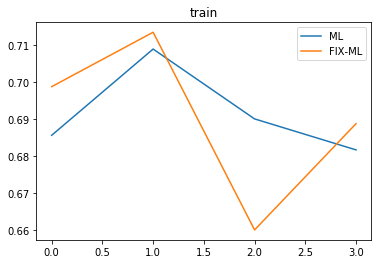

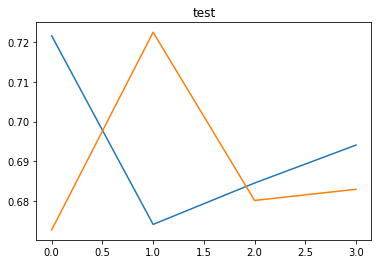

In [68]:
# THIS IS A TYPICAL RUN ###########

# Set parameters
n = 5 # number of support examples per task
n2 = 15 # number of query examples per task
d = 50 # ambient dimension
k = 10 # actual subspace dimension of the weights (used in data generation)  
k_hat = 20 # subspace dimension we learn (used in prediction)
T = 15 # total number of tasks
M = 10000 # total number of X matrix of shape n \times d
m = 20 # no of support sets in fixml
lr = 0.1 # learning rate for learning D
num_iterations_train = 8000 # no of train_iterations
test_frequency = 2000 # no of iterations after which we test
batchsz = 1
lambd = 1.5 # inner loop regularizer
device = 'cpu' # cuda uses GPU, cpu option would only perform operations on np arrays
seed = 9127
np.random.seed(seed) # set seed

        
# obtain meta-learning and fix-meta learning solns
D_true = np.stack([isotropic_gaussian(d) for _ in range(k)], axis=0).T
D_true = np.linalg.qr(D_true)[0]
D_init = np.random.randn(d, k_hat) / np.sqrt(d) # he init
D_test = D_true
# D_test = np.concatenate([D_true[:, :-1], np.random.randn(d, 1)], axis=1)


# Get Dataset

X_sigma_vec=[1./(np.linalg.norm(D_true[i, :])*np.sqrt(d)*2.) for i in range(d)]
X_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n)]) for i in range(M)]
Xq_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n2)]) for i in range(M)]
c_pool = [isotropic_gaussian(k) for i in range(T)]


if device == 'cuda':
    D_true = torch.FloatTensor(D_true).cuda()
    D_init = torch.FloatTensor(D_init).cuda()
    D_test = torch.FloatTensor(D_test).cuda()


np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
metal_avg_train_loss, metal_avg_test_loss, D_ML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=False, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)
np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
fix_metal_avg_train_loss, fix_metal_avg_test_loss, D_FIXML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=True, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)

# plots
plt.plot(list(range(len(metal_avg_train_loss))), metal_avg_train_loss, label='ML')
plt.plot(list(range(len(fix_metal_avg_train_loss))), fix_metal_avg_train_loss, label='FIX-ML')
plt.title('train')
plt.legend()
plt.show()

plt.plot(list(range(num_iterations_train // test_frequency)), metal_avg_test_loss, label='ML')
plt.plot(list(range(num_iterations_train // test_frequency)), fix_metal_avg_test_loss, label='FIX-ML')
plt.title('test')
plt.show()

In [51]:
# THIS IS A TYPICAL RUN ###########

# Set parameters
n = 5 # number of support examples per task
n2 = 15 # number of query examples per task
d = 50 # ambient dimension
k = 5 # actual subspace dimension of the weights (used in data generation)  
k_hat = 50 # subspace dimension we learn (used in prediction)
T = 20 # total number of tasks
M = 10000 # total number of X matrix of shape n \times d
m = 20 # no of support sets in fixml
lr = 0.1 # learning rate for learning D
num_iterations_train = 400000 # no of train_iterations
test_frequency = 4000 # no of iterations after which we test
batchsz = 1
lambd = 1. # inner loop regularizer
device = 'cpu' # cuda uses GPU, cpu option would only perform operations on np arrays
seed = 9127
np.random.seed(seed) # set seed

        
# obtain meta-learning and fix-meta learning solns
D_true = np.stack([isotropic_gaussian(d) for _ in range(k)], axis=0).T
D_true = np.linalg.qr(D_true)[0]
D_init = np.random.randn(d, k_hat) / np.sqrt(d) # he init
D_test = D_true
# D_test = np.concatenate([D_true[:, :-1], np.random.randn(d, 1)], axis=1)


# Get Dataset

X_sigma_vec=[1./(np.linalg.norm(D_true[i, :])*np.sqrt(d)*2.) for i in range(d)]
X_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n)]) for i in range(M)]
Xq_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n2)]) for i in range(M)]
c_pool = [isotropic_gaussian(k) for i in range(T)]


if device == 'cuda':
    D_true = torch.FloatTensor(D_true).cuda()
    D_init = torch.FloatTensor(D_init).cuda()
    D_test = torch.FloatTensor(D_test).cuda()


np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
metal_avg_train_loss, metal_avg_test_loss, D_ML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=False, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)
np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
fix_metal_avg_train_loss, fix_metal_avg_test_loss, D_FIXML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=True, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)

# plots
plt.plot(list(range(len(metal_avg_train_loss))), metal_avg_train_loss, label='ML')
plt.plot(list(range(len(fix_metal_avg_train_loss))), fix_metal_avg_train_loss, label='FIX-ML')
plt.title('train')
plt.legend()
plt.show()

plt.plot(list(range(num_iterations_train // test_frequency)), metal_avg_test_loss, label='ML')
plt.plot(list(range(num_iterations_train // test_frequency)), fix_metal_avg_test_loss, label='FIX-ML')
plt.title('test')
plt.legend()
plt.show()

  0%|          | 399/400000 [00:00<01:40, 3986.47it/s]

Running with fixSupport of size 20


 16%|█▌        | 62816/400000 [00:22<01:37, 3447.51it/s]

KeyboardInterrupt: 

  0%|          | 892/200000 [00:00<00:44, 4464.91it/s]

Running with fixSupport of size 10


100%|██████████| 200000/200000 [01:27<00:00, 2281.73it/s]


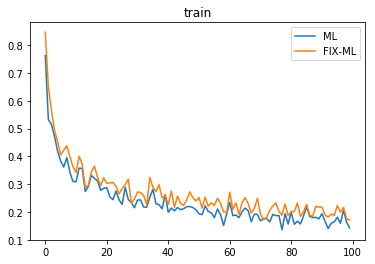

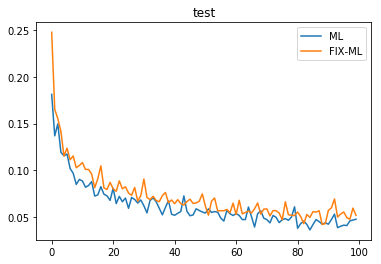

In [50]:
# THIS IS A TYPICAL RUN ###########

# Set parameters
n = 5 # number of support examples per task
n2 = 15 # number of query examples per task
d = 50 # ambient dimension
k = 5 # actual subspace dimension of the weights (used in data generation)  
k_hat = 5 # subspace dimension we learn (used in prediction)
T = 1000 # total number of tasks
M = 10000 # total number of X matrix of shape n \times d
m = 10 # no of support sets in fixml
lr = 0.01 # learning rate for learning D
num_iterations_train = 200000 # no of train_iterations
test_frequency = 2000 # no of iterations after which we test
batchsz = 1
lambd = 1. # inner loop regularizer
device = 'cpu' # cuda uses GPU, cpu option would only perform operations on np arrays
seed = 9127
np.random.seed(seed) # set seed

        
# obtain meta-learning and fix-meta learning solns
D_true = np.stack([isotropic_gaussian(d) for _ in range(k)], axis=0).T
D_true = np.linalg.qr(D_true)[0]
D_init = np.random.randn(d, k_hat) / np.sqrt(d) # he init
D_test = D_true
# D_test = np.concatenate([D_true[:, :-1], np.random.randn(d, 1)], axis=1)


# Get Dataset

X_sigma_vec=[1./(np.linalg.norm(D_true[i, :])*np.sqrt(d)) for i in range(d)]
X_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n)]) for i in range(M)]
Xq_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n2)]) for i in range(M)]
c_pool = [isotropic_gaussian(k) for i in range(T)]


if device == 'cuda':
    D_true = torch.FloatTensor(D_true).cuda()
    D_init = torch.FloatTensor(D_init).cuda()
    D_test = torch.FloatTensor(D_test).cuda()


np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
metal_avg_train_loss, metal_avg_test_loss, D_ML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=False, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)
np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
fix_metal_avg_train_loss, fix_metal_avg_test_loss, D_FIXML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=True, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)

# plots
plt.plot(list(range(len(metal_avg_train_loss))), metal_avg_train_loss, label='ML')
plt.plot(list(range(len(fix_metal_avg_train_loss))), fix_metal_avg_train_loss, label='FIX-ML')
plt.title('train')
plt.legend()
plt.show()

plt.plot(list(range(num_iterations_train // test_frequency)), metal_avg_test_loss, label='ML')
plt.plot(list(range(num_iterations_train // test_frequency)), fix_metal_avg_test_loss, label='FIX-ML')
plt.title('test')
plt.legend()
plt.show()

In [ ]:
# THIS IS A TYPICAL RUN ###########

# Set parameters
n = 5 # number of support examples per task
n2 = 15 # number of query examples per task
d = 50 # ambient dimension
k = 5 # actual subspace dimension of the weights (used in data generation)  
k_hat = 30 # subspace dimension we learn (used in prediction)
T = 1000 # total number of tasks
M = 10000 # total number of X matrix of shape n \times d
m = 10 # no of support sets in fixml
lr = 0.01 # learning rate for learning D
num_iterations_train = 200000 # no of train_iterations
test_frequency = 2000 # no of iterations after which we test
batchsz = 1
lambd = 1. # inner loop regularizer
device = 'cpu' # cuda uses GPU, cpu option would only perform operations on np arrays
seed = 9127
np.random.seed(seed) # set seed

        
# obtain meta-learning and fix-meta learning solns
D_true = np.stack([isotropic_gaussian(d) for _ in range(k)], axis=0).T
D_true = np.linalg.qr(D_true)[0]
D_init = np.random.randn(d, k_hat) / np.sqrt(d) # he init
D_test = D_true
# D_test = np.concatenate([D_true[:, :-1], np.random.randn(d, 1)], axis=1)


# Get Dataset

X_sigma_vec=[1./(np.linalg.norm(D_true[i, :])*np.sqrt(d)) for i in range(d)]
X_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n)]) for i in range(M)]
Xq_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n2)]) for i in range(M)]
c_pool = [isotropic_gaussian(k) for i in range(T)]


if device == 'cuda':
    D_true = torch.FloatTensor(D_true).cuda()
    D_init = torch.FloatTensor(D_init).cuda()
    D_test = torch.FloatTensor(D_test).cuda()


np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
metal_avg_train_loss, metal_avg_test_loss, D_ML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=False, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)
np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
fix_metal_avg_train_loss, fix_metal_avg_test_loss, D_FIXML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=True, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)

# plots
plt.plot(list(range(len(metal_avg_train_loss))), metal_avg_train_loss, label='ML')
plt.plot(list(range(len(fix_metal_avg_train_loss))), fix_metal_avg_train_loss, label='FIX-ML')
plt.title('train')
plt.legend()
plt.show()

plt.plot(list(range(num_iterations_train // test_frequency)), metal_avg_test_loss, label='ML')
plt.plot(list(range(num_iterations_train // test_frequency)), fix_metal_avg_test_loss, label='FIX-ML')
plt.title('test')
plt.legend()
plt.show()

In [ ]:
# THIS IS A TYPICAL RUN ###########

# Set parameters
n = 5 # number of support examples per task
n2 = 15 # number of query examples per task
d = 50 # ambient dimension
k = 5 # actual subspace dimension of the weights (used in data generation)  
k_hat = 5 # subspace dimension we learn (used in prediction)
T = 100 # total number of tasks
M = 10000 # total number of X matrix of shape n \times d
m = 10 # no of support sets in fixml
lr = 0.01 # learning rate for learning D
num_iterations_train = 200000 # no of train_iterations
test_frequency = 2000 # no of iterations after which we test
batchsz = 1
lambd = 1. # inner loop regularizer
device = 'cpu' # cuda uses GPU, cpu option would only perform operations on np arrays
seed = 9127
np.random.seed(seed) # set seed

        
# obtain meta-learning and fix-meta learning solns
D_true = np.stack([isotropic_gaussian(d) for _ in range(k)], axis=0).T
D_true = np.linalg.qr(D_true)[0]
D_init = np.random.randn(d, k_hat) / np.sqrt(d) # he init
D_test = D_true
# D_test = np.concatenate([D_true[:, :-1], np.random.randn(d, 1)], axis=1)


# Get Dataset

X_sigma_vec=[1./(np.linalg.norm(D_true[i, :])*np.sqrt(d)) for i in range(d)]
X_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n)]) for i in range(M)]
Xq_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n2)]) for i in range(M)]
c_pool = [isotropic_gaussian(k) for i in range(T)]


if device == 'cuda':
    D_true = torch.FloatTensor(D_true).cuda()
    D_init = torch.FloatTensor(D_init).cuda()
    D_test = torch.FloatTensor(D_test).cuda()


np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
metal_avg_train_loss, metal_avg_test_loss, D_ML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=False, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)
np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
fix_metal_avg_train_loss, fix_metal_avg_test_loss, D_FIXML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=True, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)

# plots
plt.plot(list(range(len(metal_avg_train_loss))), metal_avg_train_loss, label='ML')
plt.plot(list(range(len(fix_metal_avg_train_loss))), fix_metal_avg_train_loss, label='FIX-ML')
plt.title('train')
plt.legend()
plt.show()

plt.plot(list(range(num_iterations_train // test_frequency)), metal_avg_test_loss, label='ML')
plt.plot(list(range(num_iterations_train // test_frequency)), fix_metal_avg_test_loss, label='FIX-ML')
plt.title('test')
plt.legend()
plt.show()

In [ ]:
# THIS IS A TYPICAL RUN ###########

# Set parameters
n = 5 # number of support examples per task
n2 = 15 # number of query examples per task
d = 50 # ambient dimension
k = 5 # actual subspace dimension of the weights (used in data generation)  
k_hat = 30 # subspace dimension we learn (used in prediction)
T = 10 # total number of tasks
M = 10000 # total number of X matrix of shape n \times d
m = 10 # no of support sets in fixml
lr = 0.01 # learning rate for learning D
num_iterations_train = 200000 # no of train_iterations
test_frequency = 2000 # no of iterations after which we test
batchsz = 1
lambd = 1. # inner loop regularizer
device = 'cpu' # cuda uses GPU, cpu option would only perform operations on np arrays
seed = 9127
np.random.seed(seed) # set seed

        
# obtain meta-learning and fix-meta learning solns
D_true = np.stack([isotropic_gaussian(d) for _ in range(k)], axis=0).T
D_true = np.linalg.qr(D_true)[0]
D_init = np.random.randn(d, k_hat) / np.sqrt(d) # he init
D_test = D_true
# D_test = np.concatenate([D_true[:, :-1], np.random.randn(d, 1)], axis=1)


# Get Dataset

X_sigma_vec=[1./(np.linalg.norm(D_true[i, :])*np.sqrt(d)) for i in range(d)]
X_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n)]) for i in range(M)]
Xq_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n2)]) for i in range(M)]
c_pool = [isotropic_gaussian(k) for i in range(T)]


if device == 'cuda':
    D_true = torch.FloatTensor(D_true).cuda()
    D_init = torch.FloatTensor(D_init).cuda()
    D_test = torch.FloatTensor(D_test).cuda()


np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
metal_avg_train_loss, metal_avg_test_loss, D_ML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=False, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)
np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
fix_metal_avg_train_loss, fix_metal_avg_test_loss, D_FIXML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=True, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)

# plots
plt.plot(list(range(len(metal_avg_train_loss))), metal_avg_train_loss, label='ML')
plt.plot(list(range(len(fix_metal_avg_train_loss))), fix_metal_avg_train_loss, label='FIX-ML')
plt.title('train')
plt.legend()
plt.show()

plt.plot(list(range(num_iterations_train // test_frequency)), metal_avg_test_loss, label='ML')
plt.plot(list(range(num_iterations_train // test_frequency)), fix_metal_avg_test_loss, label='FIX-ML')
plt.title('test')
plt.legend()
plt.show()

In [ ]:
# THIS IS A TYPICAL RUN ###########

# Set parameters
n = 5 # number of support examples per task
n2 = 15 # number of query examples per task
d = 500 # ambient dimension
k = 10 # actual subspace dimension of the weights (used in data generation)  
k_hat = 10 # subspace dimension we learn (used in prediction)
T = 10000 # total number of tasks
M = 10000 # total number of X matrix of shape n \times d
m = 10 # no of support sets in fixml
lr = 0.01 # learning rate for learning D
num_iterations_train = 200000 # no of train_iterations
test_frequency = 2000 # no of iterations after which we test
batchsz = 1
lambd = 10. # inner loop regularizer
device = 'cpu' # cuda uses GPU, cpu option would only perform operations on np arrays
seed = 9127
np.random.seed(seed) # set seed

        
# obtain meta-learning and fix-meta learning solns
D_true = np.stack([isotropic_gaussian(d) for _ in range(k)], axis=0).T
D_true = np.linalg.qr(D_true)[0]
D_init = np.random.randn(d, k_hat) / np.sqrt(d) # he init
D_test = D_true
# D_test = np.concatenate([D_true[:, :-1], np.random.randn(d, 1)], axis=1)


# Get Dataset

X_sigma_vec=[1./(np.linalg.norm(D_true[i, :])*np.sqrt(d)) for i in range(d)]
X_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n)]) for i in range(M)]
Xq_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n2)]) for i in range(M)]
c_pool = [isotropic_gaussian(k) for i in range(T)]


if device == 'cuda':
    D_true = torch.FloatTensor(D_true).cuda()
    D_init = torch.FloatTensor(D_init).cuda()
    D_test = torch.FloatTensor(D_test).cuda()


np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
metal_avg_train_loss, metal_avg_test_loss, D_ML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=False, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)
np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
fix_metal_avg_train_loss, fix_metal_avg_test_loss, D_FIXML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=True, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)

# plots
plt.plot(list(range(len(metal_avg_train_loss))), metal_avg_train_loss, label='ML')
plt.plot(list(range(len(fix_metal_avg_train_loss))), fix_metal_avg_train_loss, label='FIX-ML')
plt.title('train')
plt.legend()
plt.show()

plt.plot(list(range(num_iterations_train // test_frequency)), metal_avg_test_loss, label='ML')
plt.plot(list(range(num_iterations_train // test_frequency)), fix_metal_avg_test_loss, label='FIX-ML')
plt.title('test')
plt.legend()
plt.show()

In [ ]:
# THIS IS A TYPICAL RUN ###########

# Set parameters
n = 5 # number of support examples per task
n2 = 15 # number of query examples per task
d = 500 # ambient dimension
k = 20 # actual subspace dimension of the weights (used in data generation)  
k_hat = 50 # subspace dimension we learn (used in prediction)
T = 10000 # total number of tasks
M = 10000 # total number of X matrix of shape n \times d
m = 10 # no of support sets in fixml
lr = 0.01 # learning rate for learning D
num_iterations_train = 200000 # no of train_iterations
test_frequency = 2000 # no of iterations after which we test
batchsz = 1
lambd = 10. # inner loop regularizer
device = 'cpu' # cuda uses GPU, cpu option would only perform operations on np arrays
seed = 9127
np.random.seed(seed) # set seed

        
# obtain meta-learning and fix-meta learning solns
D_true = np.stack([isotropic_gaussian(d) for _ in range(k)], axis=0).T
D_true = np.linalg.qr(D_true)[0]
D_init = np.random.randn(d, k_hat) / np.sqrt(d) # he init
D_test = D_true
# D_test = np.concatenate([D_true[:, :-1], np.random.randn(d, 1)], axis=1)


# Get Dataset

X_sigma_vec=[1./(np.linalg.norm(D_true[i, :])*np.sqrt(d)) for i in range(d)]
X_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n)]) for i in range(M)]
Xq_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n2)]) for i in range(M)]
c_pool = [isotropic_gaussian(k) for i in range(T)]


if device == 'cuda':
    D_true = torch.FloatTensor(D_true).cuda()
    D_init = torch.FloatTensor(D_init).cuda()
    D_test = torch.FloatTensor(D_test).cuda()


np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
metal_avg_train_loss, metal_avg_test_loss, D_ML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=False, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)
np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
fix_metal_avg_train_loss, fix_metal_avg_test_loss, D_FIXML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=True, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)

# plots
plt.plot(list(range(len(metal_avg_train_loss))), metal_avg_train_loss, label='ML')
plt.plot(list(range(len(fix_metal_avg_train_loss))), fix_metal_avg_train_loss, label='FIX-ML')
plt.title('train')
plt.legend()
plt.show()

plt.plot(list(range(num_iterations_train // test_frequency)), metal_avg_test_loss, label='ML')
plt.plot(list(range(num_iterations_train // test_frequency)), fix_metal_avg_test_loss, label='FIX-ML')
plt.title('test')
plt.legend()
plt.show()

In [ ]:
# THIS IS A TYPICAL RUN ###########

# Set parameters
n = 5 # number of support examples per task
n2 = 15 # number of query examples per task
d = 500 # ambient dimension
k = 3 # actual subspace dimension of the weights (used in data generation)  
k_hat = 4 # subspace dimension we learn (used in prediction)
T = 10000 # total number of tasks
M = 10000 # total number of X matrix of shape n \times d
m = 10 # no of support sets in fixml
lr = 0.01 # learning rate for learning D
num_iterations_train = 200000 # no of train_iterations
test_frequency = 2000 # no of iterations after which we test
batchsz = 1
lambd = 10. # inner loop regularizer
device = 'cpu' # cuda uses GPU, cpu option would only perform operations on np arrays
seed = 9127
np.random.seed(seed) # set seed

        
# obtain meta-learning and fix-meta learning solns
D_true = np.stack([isotropic_gaussian(d) for _ in range(k)], axis=0).T
D_true = np.linalg.qr(D_true)[0]
D_init = np.random.randn(d, k_hat) / np.sqrt(d) # he init
D_test = D_true
# D_test = np.concatenate([D_true[:, :-1], np.random.randn(d, 1)], axis=1)


# Get Dataset

X_sigma_vec=[1./(np.linalg.norm(D_true[i, :])*np.sqrt(d)) for i in range(d)]
X_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n)]) for i in range(M)]
Xq_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n2)]) for i in range(M)]
c_pool = [isotropic_gaussian(k) for i in range(T)]


if device == 'cuda':
    D_true = torch.FloatTensor(D_true).cuda()
    D_init = torch.FloatTensor(D_init).cuda()
    D_test = torch.FloatTensor(D_test).cuda()


np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
metal_avg_train_loss, metal_avg_test_loss, D_ML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=False, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)
np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
fix_metal_avg_train_loss, fix_metal_avg_test_loss, D_FIXML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=True, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)

# plots
plt.plot(list(range(len(metal_avg_train_loss))), metal_avg_train_loss, label='ML')
plt.plot(list(range(len(fix_metal_avg_train_loss))), fix_metal_avg_train_loss, label='FIX-ML')
plt.title('train')
plt.legend()
plt.show()

plt.plot(list(range(num_iterations_train // test_frequency)), metal_avg_test_loss, label='ML')
plt.plot(list(range(num_iterations_train // test_frequency)), fix_metal_avg_test_loss, label='FIX-ML')
plt.title('test')
plt.legend()
plt.show()

In [ ]:
# THIS IS A TYPICAL RUN ###########

# Set parameters
n = 5 # number of support examples per task
n2 = 15 # number of query examples per task
d = 500 # ambient dimension
k = 3 # actual subspace dimension of the weights (used in data generation)  
k_hat = 20 # subspace dimension we learn (used in prediction)
T = 10000 # total number of tasks
M = 10000 # total number of X matrix of shape n \times d
m = 10 # no of support sets in fixml
lr = 0.01 # learning rate for learning D
num_iterations_train = 200000 # no of train_iterations
test_frequency = 2000 # no of iterations after which we test
batchsz = 1
lambd = 10. # inner loop regularizer
device = 'cpu' # cuda uses GPU, cpu option would only perform operations on np arrays
seed = 9127
np.random.seed(seed) # set seed

        
# obtain meta-learning and fix-meta learning solns
D_true = np.stack([isotropic_gaussian(d) for _ in range(k)], axis=0).T
D_true = np.linalg.qr(D_true)[0]
D_init = np.random.randn(d, k_hat) / np.sqrt(d) # he init
D_test = D_true
# D_test = np.concatenate([D_true[:, :-1], np.random.randn(d, 1)], axis=1)


# Get Dataset

X_sigma_vec=[1./(np.linalg.norm(D_true[i, :])*np.sqrt(d)) for i in range(d)]
X_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n)]) for i in range(M)]
Xq_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n2)]) for i in range(M)]
c_pool = [isotropic_gaussian(k) for i in range(T)]


if device == 'cuda':
    D_true = torch.FloatTensor(D_true).cuda()
    D_init = torch.FloatTensor(D_init).cuda()
    D_test = torch.FloatTensor(D_test).cuda()


np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
metal_avg_train_loss, metal_avg_test_loss, D_ML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=False, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)
np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
fix_metal_avg_train_loss, fix_metal_avg_test_loss, D_FIXML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=True, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)

# plots
plt.plot(list(range(len(metal_avg_train_loss))), metal_avg_train_loss, label='ML')
plt.plot(list(range(len(fix_metal_avg_train_loss))), fix_metal_avg_train_loss, label='FIX-ML')
plt.title('train')
plt.legend()
plt.show()

plt.plot(list(range(num_iterations_train // test_frequency)), metal_avg_test_loss, label='ML')
plt.plot(list(range(num_iterations_train // test_frequency)), fix_metal_avg_test_loss, label='FIX-ML')
plt.title('test')
plt.legend()
plt.show()

In [ ]:
# THIS IS A TYPICAL RUN ###########

# Set parameters
n = 5 # number of support examples per task
n2 = 15 # number of query examples per task
d = 500 # ambient dimension
k = 20 # actual subspace dimension of the weights (used in data generation)  
k_hat = 120 # subspace dimension we learn (used in prediction)
T = 10000 # total number of tasks
M = 10000 # total number of X matrix of shape n \times d
m = 10 # no of support sets in fixml
lr = 0.01 # learning rate for learning D
num_iterations_train = 200000 # no of train_iterations
test_frequency = 2000 # no of iterations after which we test
batchsz = 1
lambd = 10. # inner loop regularizer
device = 'cpu' # cuda uses GPU, cpu option would only perform operations on np arrays
seed = 9127
np.random.seed(seed) # set seed

        
# obtain meta-learning and fix-meta learning solns
D_true = np.stack([isotropic_gaussian(d) for _ in range(k)], axis=0).T
D_true = np.linalg.qr(D_true)[0]
D_init = np.random.randn(d, k_hat) / np.sqrt(d) # he init
D_test = D_true
# D_test = np.concatenate([D_true[:, :-1], np.random.randn(d, 1)], axis=1)


# Get Dataset

X_sigma_vec=[1./(np.linalg.norm(D_true[i, :])*np.sqrt(d)) for i in range(d)]
X_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n)]) for i in range(M)]
Xq_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n2)]) for i in range(M)]
c_pool = [isotropic_gaussian(k) for i in range(T)]


if device == 'cuda':
    D_true = torch.FloatTensor(D_true).cuda()
    D_init = torch.FloatTensor(D_init).cuda()
    D_test = torch.FloatTensor(D_test).cuda()


np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
metal_avg_train_loss, metal_avg_test_loss, D_ML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=False, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)
np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
fix_metal_avg_train_loss, fix_metal_avg_test_loss, D_FIXML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=True, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)

# plots
plt.plot(list(range(len(metal_avg_train_loss))), metal_avg_train_loss, label='ML')
plt.plot(list(range(len(fix_metal_avg_train_loss))), fix_metal_avg_train_loss, label='FIX-ML')
plt.title('train')
plt.legend()
plt.show()

plt.plot(list(range(num_iterations_train // test_frequency)), metal_avg_test_loss, label='ML')
plt.plot(list(range(num_iterations_train // test_frequency)), fix_metal_avg_test_loss, label='FIX-ML')
plt.title('test')
plt.legend()
plt.show()

In [ ]:
# THIS IS A TYPICAL RUN ###########

# Set parameters
n = 5 # number of support examples per task
n2 = 15 # number of query examples per task
d = 500 # ambient dimension
k = 20 # actual subspace dimension of the weights (used in data generation)  
k_hat = 50 # subspace dimension we learn (used in prediction)
T = 10000 # total number of tasks
M = 10000 # total number of X matrix of shape n \times d
m = 10 # no of support sets in fixml
lr = 0.01 # learning rate for learning D
num_iterations_train = 200000 # no of train_iterations
test_frequency = 2000 # no of iterations after which we test
batchsz = 1
lambd = 10. # inner loop regularizer
device = 'cpu' # cuda uses GPU, cpu option would only perform operations on np arrays
seed = 9127
np.random.seed(seed) # set seed

        
# obtain meta-learning and fix-meta learning solns
D_true = np.stack([isotropic_gaussian(d) for _ in range(k)], axis=0).T
D_true = np.linalg.qr(D_true)[0]
D_init = np.random.randn(d, k_hat) / np.sqrt(d) # he init
D_test = D_true
# D_test = np.concatenate([D_true[:, :-1], np.random.randn(d, 1)], axis=1)


# Get Dataset

X_sigma_vec=[1./(np.linalg.norm(D_true[i, :])*np.sqrt(d)) for i in range(d)]
X_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n)]) for i in range(M)]
Xq_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n2)]) for i in range(M)]
c_pool = [isotropic_gaussian(k) for i in range(T)]


if device == 'cuda':
    D_true = torch.FloatTensor(D_true).cuda()
    D_init = torch.FloatTensor(D_init).cuda()
    D_test = torch.FloatTensor(D_test).cuda()


np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
metal_avg_train_loss, metal_avg_test_loss, D_ML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=False, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)
np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
fix_metal_avg_train_loss, fix_metal_avg_test_loss, D_FIXML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=True, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)

# plots
plt.plot(list(range(len(metal_avg_train_loss))), metal_avg_train_loss, label='ML')
plt.plot(list(range(len(fix_metal_avg_train_loss))), fix_metal_avg_train_loss, label='FIX-ML')
plt.title('train')
plt.legend()
plt.show()

plt.plot(list(range(num_iterations_train // test_frequency)), metal_avg_test_loss, label='ML')
plt.plot(list(range(num_iterations_train // test_frequency)), fix_metal_avg_test_loss, label='FIX-ML')
plt.title('test')
plt.legend()
plt.show()

In [ ]:
# THIS IS A TYPICAL RUN ###########

# Set parameters
n = 5 # number of support examples per task
n2 = 15 # number of query examples per task
d = 50 # ambient dimension
k = 3 # actual subspace dimension of the weights (used in data generation)  
k_hat = 40 # subspace dimension we learn (used in prediction)
T = 10000 # total number of tasks
M = 10000 # total number of X matrix of shape n \times d
m = 10 # no of support sets in fixml
lr = 0.01 # learning rate for learning D
num_iterations_train = 200000 # no of train_iterations
test_frequency = 2000 # no of iterations after which we test
batchsz = 1
lambd = 10. # inner loop regularizer
device = 'cpu' # cuda uses GPU, cpu option would only perform operations on np arrays
seed = 9127
np.random.seed(seed) # set seed

        
# obtain meta-learning and fix-meta learning solns
D_true = np.stack([isotropic_gaussian(d) for _ in range(k)], axis=0).T
D_true = np.linalg.qr(D_true)[0]
D_init = np.random.randn(d, k_hat) / np.sqrt(d) # he init
D_test = D_true
# D_test = np.concatenate([D_true[:, :-1], np.random.randn(d, 1)], axis=1)


# Get Dataset

X_sigma_vec=[1./(np.linalg.norm(D_true[i, :])*np.sqrt(d)) for i in range(d)]
X_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n)]) for i in range(M)]
Xq_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n2)]) for i in range(M)]
c_pool = [isotropic_gaussian(k) for i in range(T)]


if device == 'cuda':
    D_true = torch.FloatTensor(D_true).cuda()
    D_init = torch.FloatTensor(D_init).cuda()
    D_test = torch.FloatTensor(D_test).cuda()


np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
metal_avg_train_loss, metal_avg_test_loss, D_ML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=False, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)
np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
fix_metal_avg_train_loss, fix_metal_avg_test_loss, D_FIXML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=True, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)

# plots
plt.plot(list(range(len(metal_avg_train_loss))), metal_avg_train_loss, label='ML')
plt.plot(list(range(len(fix_metal_avg_train_loss))), fix_metal_avg_train_loss, label='FIX-ML')
plt.title('train')
plt.legend()
plt.show()

plt.plot(list(range(num_iterations_train // test_frequency)), metal_avg_test_loss, label='ML')
plt.plot(list(range(num_iterations_train // test_frequency)), fix_metal_avg_test_loss, label='FIX-ML')
plt.title('test')
plt.legend()
plt.show()

In [ ]:
Alg P: D

Expressivity: 
    w^*_t \in D[\hat{c}_t] f(D, X_{s,t}) (D?, \lambda?)

Task specific Generalization:
    \| \hat{w}_t - w^*_t \| \leq \epsilon

In [ ]:
# THIS IS A TYPICAL RUN ###########

# Set parameters
n = 5 # number of support examples per task
n2 = 15 # number of query examples per task
d = 50 # ambient dimension
k = 3 # actual subspace dimension of the weights (used in data generation)  
k_hat = 40 # subspace dimension we learn (used in prediction)
T = 100 # total number of tasks
M = 10000 # total number of X matrix of shape n \times d
m = 10 # no of support sets in fixml
lr = 0.01 # learning rate for learning D
num_iterations_train = 200000 # no of train_iterations
test_frequency = 2000 # no of iterations after which we test
batchsz = 1
lambd = 10. # inner loop regularizer
device = 'cpu' # cuda uses GPU, cpu option would only perform operations on np arrays
seed = 9127
np.random.seed(seed) # set seed

        
# obtain meta-learning and fix-meta learning solns
D_true = np.stack([isotropic_gaussian(d) for _ in range(k)], axis=0).T
D_true = np.linalg.qr(D_true)[0]
D_init = np.random.randn(d, k_hat) / np.sqrt(d) # he init
D_test = D_true
# D_test = np.concatenate([D_true[:, :-1], np.random.randn(d, 1)], axis=1)


# Get Dataset

X_sigma_vec=[1./(np.linalg.norm(D_true[i, :])*np.sqrt(d)) for i in range(d)]
X_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n)]) for i in range(M)]
Xq_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n2)]) for i in range(M)]
c_pool = [isotropic_gaussian(k) for i in range(T)]


if device == 'cuda':
    D_true = torch.FloatTensor(D_true).cuda()
    D_init = torch.FloatTensor(D_init).cuda()
    D_test = torch.FloatTensor(D_test).cuda()


np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
metal_avg_train_loss, metal_avg_test_loss, D_ML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=False, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)
np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
fix_metal_avg_train_loss, fix_metal_avg_test_loss, D_FIXML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=True, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)

# plots
plt.plot(list(range(len(metal_avg_train_loss))), metal_avg_train_loss, label='ML')
plt.plot(list(range(len(fix_metal_avg_train_loss))), fix_metal_avg_train_loss, label='FIX-ML')
plt.title('train')
plt.legend()
plt.show()

plt.plot(list(range(num_iterations_train // test_frequency)), metal_avg_test_loss, label='ML')
plt.plot(list(range(num_iterations_train // test_frequency)), fix_metal_avg_test_loss, label='FIX-ML')
plt.title('test')
plt.legend()
plt.show()

In [ ]:
# THIS IS A TYPICAL RUN ###########

# Set parameters
n = 5 # number of support examples per task
n2 = 15 # number of query examples per task
d = 50 # ambient dimension
k = 10 # actual subspace dimension of the weights (used in data generation)  
k_hat = 40 # subspace dimension we learn (used in prediction)
T = 100 # total number of tasks
M = 10000 # total number of X matrix of shape n \times d
m = 10 # no of support sets in fixml
lr = 0.01 # learning rate for learning D
num_iterations_train = 200000 # no of train_iterations
test_frequency = 2000 # no of iterations after which we test
batchsz = 1
lambd = 10. # inner loop regularizer
device = 'cpu' # cuda uses GPU, cpu option would only perform operations on np arrays
seed = 9127
np.random.seed(seed) # set seed

        
# obtain meta-learning and fix-meta learning solns
D_true = np.stack([isotropic_gaussian(d) for _ in range(k)], axis=0).T
D_true = np.linalg.qr(D_true)[0]
D_init = np.random.randn(d, k_hat) / np.sqrt(d) # he init
D_test = D_true
# D_test = np.concatenate([D_true[:, :-1], np.random.randn(d, 1)], axis=1)


# Get Dataset

X_sigma_vec=[1./(np.linalg.norm(D_true[i, :])*np.sqrt(d)) for i in range(d)]
X_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n)]) for i in range(M)]
Xq_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n2)]) for i in range(M)]
c_pool = [isotropic_gaussian(k) for i in range(T)]


if device == 'cuda':
    D_true = torch.FloatTensor(D_true).cuda()
    D_init = torch.FloatTensor(D_init).cuda()
    D_test = torch.FloatTensor(D_test).cuda()


np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
metal_avg_train_loss, metal_avg_test_loss, D_ML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=False, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)
np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
fix_metal_avg_train_loss, fix_metal_avg_test_loss, D_FIXML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=True, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)

# plots
plt.plot(list(range(len(metal_avg_train_loss))), metal_avg_train_loss, label='ML')
plt.plot(list(range(len(fix_metal_avg_train_loss))), fix_metal_avg_train_loss, label='FIX-ML')
plt.title('train')
plt.legend()
plt.show()

plt.plot(list(range(num_iterations_train // test_frequency)), metal_avg_test_loss, label='ML')
plt.plot(list(range(num_iterations_train // test_frequency)), fix_metal_avg_test_loss, label='FIX-ML')
plt.title('test')
plt.legend()
plt.show()

In [ ]:
# THIS IS A TYPICAL RUN ###########

# Set parameters
n = 5 # number of support examples per task
n2 = 15 # number of query examples per task
d = 50 # ambient dimension
k = 10 # actual subspace dimension of the weights (used in data generation)  
k_hat = 40 # subspace dimension we learn (used in prediction)
T = 50 # total number of tasks
M = 10000 # total number of X matrix of shape n \times d
m = 10 # no of support sets in fixml
lr = 0.01 # learning rate for learning D
num_iterations_train = 200000 # no of train_iterations
test_frequency = 2000 # no of iterations after which we test
batchsz = 1
lambd = 10. # inner loop regularizer
device = 'cpu' # cuda uses GPU, cpu option would only perform operations on np arrays
seed = 9127
np.random.seed(seed) # set seed

        
# obtain meta-learning and fix-meta learning solns
D_true = np.stack([isotropic_gaussian(d) for _ in range(k)], axis=0).T
D_true = np.linalg.qr(D_true)[0]
D_init = np.random.randn(d, k_hat) / np.sqrt(d) # he init
D_test = D_true
# D_test = np.concatenate([D_true[:, :-1], np.random.randn(d, 1)], axis=1)


# Get Dataset

X_sigma_vec=[1./(np.linalg.norm(D_true[i, :])*np.sqrt(d)) for i in range(d)]
X_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n)]) for i in range(M)]
Xq_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n2)]) for i in range(M)]
c_pool = [isotropic_gaussian(k) for i in range(T)]


if device == 'cuda':
    D_true = torch.FloatTensor(D_true).cuda()
    D_init = torch.FloatTensor(D_init).cuda()
    D_test = torch.FloatTensor(D_test).cuda()


np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
metal_avg_train_loss, metal_avg_test_loss, D_ML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=False, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)
np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
fix_metal_avg_train_loss, fix_metal_avg_test_loss, D_FIXML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=True, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)

# plots
plt.plot(list(range(len(metal_avg_train_loss))), metal_avg_train_loss, label='ML')
plt.plot(list(range(len(fix_metal_avg_train_loss))), fix_metal_avg_train_loss, label='FIX-ML')
plt.title('train')
plt.legend()
plt.show()

plt.plot(list(range(num_iterations_train // test_frequency)), metal_avg_test_loss, label='ML')
plt.plot(list(range(num_iterations_train // test_frequency)), fix_metal_avg_test_loss, label='FIX-ML')
plt.title('test')
plt.legend()
plt.show()

In [ ]:
# THIS IS A TYPICAL RUN ###########

# Set parameters
n = 5 # number of support examples per task
n2 = 15 # number of query examples per task
d = 50 # ambient dimension
k = 10 # actual subspace dimension of the weights (used in data generation)  
k_hat = 40 # subspace dimension we learn (used in prediction)
T = 25 # total number of tasks
M = 10000 # total number of X matrix of shape n \times d
m = 10 # no of support sets in fixml
lr = 0.01 # learning rate for learning D
num_iterations_train = 2000000 # no of train_iterations
test_frequency = 20000 # no of iterations after which we test
batchsz = 1
lambd = 10. # inner loop regularizer
device = 'cpu' # cuda uses GPU, cpu option would only perform operations on np arrays
seed = 9127
np.random.seed(seed) # set seed

        
# obtain meta-learning and fix-meta learning solns
D_true = np.stack([isotropic_gaussian(d) for _ in range(k)], axis=0).T
D_true = np.linalg.qr(D_true)[0]
D_init = np.random.randn(d, k_hat) / np.sqrt(d) # he init
D_test = D_true
# D_test = np.concatenate([D_true[:, :-1], np.random.randn(d, 1)], axis=1)


# Get Dataset

X_sigma_vec=[1./(np.linalg.norm(D_true[i, :])*np.sqrt(d)) for i in range(d)]
X_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n)]) for i in range(M)]
Xq_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n2)]) for i in range(M)]
c_pool = [isotropic_gaussian(k) for i in range(T)]


if device == 'cuda':
    D_true = torch.FloatTensor(D_true).cuda()
    D_init = torch.FloatTensor(D_init).cuda()
    D_test = torch.FloatTensor(D_test).cuda()


np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
metal_avg_train_loss, metal_avg_test_loss, D_ML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=False, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)
np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
fix_metal_avg_train_loss, fix_metal_avg_test_loss, D_FIXML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=True, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)

# plots
plt.plot(list(range(len(metal_avg_train_loss))), metal_avg_train_loss, label='ML')
plt.plot(list(range(len(fix_metal_avg_train_loss))), fix_metal_avg_train_loss, label='FIX-ML')
plt.title('train')
plt.legend()
plt.show()

plt.plot(list(range(num_iterations_train // test_frequency)), metal_avg_test_loss, label='ML')
plt.plot(list(range(num_iterations_train // test_frequency)), fix_metal_avg_test_loss, label='FIX-ML')
plt.title('test')
plt.legend()
plt.show()

In [ ]:
# THIS IS A TYPICAL RUN ###########

# Set parameters
n = 5 # number of support examples per task
n2 = 15 # number of query examples per task
d = 50 # ambient dimension
k = 10 # actual subspace dimension of the weights (used in data generation)  
k_hat = 40 # subspace dimension we learn (used in prediction)
T = 25 # total number of tasks
M = 10000 # total number of X matrix of shape n \times d
m = 10 # no of support sets in fixml
lr = 0.01 # learning rate for learning D
num_iterations_train = 2000000 # no of train_iterations
test_frequency = 20000 # no of iterations after which we test
batchsz = 1
lambd = 20. # inner loop regularizer
device = 'cpu' # cuda uses GPU, cpu option would only perform operations on np arrays
seed = 9127
np.random.seed(seed) # set seed

        
# obtain meta-learning and fix-meta learning solns
D_true = np.stack([isotropic_gaussian(d) for _ in range(k)], axis=0).T
D_true = np.linalg.qr(D_true)[0]
D_init = np.random.randn(d, k_hat) / np.sqrt(d) # he init
D_test = D_true
# D_test = np.concatenate([D_true[:, :-1], np.random.randn(d, 1)], axis=1)


# Get Dataset

X_sigma_vec=[1./(np.linalg.norm(D_true[i, :])*np.sqrt(d)) for i in range(d)]
X_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n)]) for i in range(M)]
Xq_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n2)]) for i in range(M)]
c_pool = [isotropic_gaussian(k) for i in range(T)]


if device == 'cuda':
    D_true = torch.FloatTensor(D_true).cuda()
    D_init = torch.FloatTensor(D_init).cuda()
    D_test = torch.FloatTensor(D_test).cuda()


np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
metal_avg_train_loss, metal_avg_test_loss, D_ML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=False, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)
np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
fix_metal_avg_train_loss, fix_metal_avg_test_loss, D_FIXML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=True, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)

# plots
plt.plot(list(range(len(metal_avg_train_loss))), metal_avg_train_loss, label='ML')
plt.plot(list(range(len(fix_metal_avg_train_loss))), fix_metal_avg_train_loss, label='FIX-ML')
plt.title('train')
plt.legend()
plt.show()

plt.plot(list(range(num_iterations_train // test_frequency)), metal_avg_test_loss, label='ML')
plt.plot(list(range(num_iterations_train // test_frequency)), fix_metal_avg_test_loss, label='FIX-ML')
plt.title('test')
plt.legend()
plt.show()

In [ ]:
# THIS IS A TYPICAL RUN ###########

# Set parameters
n = 5 # number of support examples per task
n2 = 15 # number of query examples per task
d = 50 # ambient dimension
k = 10 # actual subspace dimension of the weights (used in data generation)  
k_hat = 40 # subspace dimension we learn (used in prediction)
T = 25 # total number of tasks
M = 10000 # total number of X matrix of shape n \times d
m = 10 # no of support sets in fixml
lr = 0.005 # learning rate for learning D
num_iterations_train = 2000000 # no of train_iterations
test_frequency = 20000 # no of iterations after which we test
batchsz = 1
lambd = 20. # inner loop regularizer
device = 'cpu' # cuda uses GPU, cpu option would only perform operations on np arrays
seed = 9127
np.random.seed(seed) # set seed

        
# obtain meta-learning and fix-meta learning solns
D_true = np.stack([isotropic_gaussian(d) for _ in range(k)], axis=0).T
D_true = np.linalg.qr(D_true)[0]
D_init = np.random.randn(d, k_hat) / np.sqrt(d) # he init
D_test = D_true
# D_test = np.concatenate([D_true[:, :-1], np.random.randn(d, 1)], axis=1)


# Get Dataset

X_sigma_vec=[1./(np.linalg.norm(D_true[i, :])*np.sqrt(d)) for i in range(d)]
X_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n)]) for i in range(M)]
Xq_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n2)]) for i in range(M)]
c_pool = [isotropic_gaussian(k) for i in range(T)]


if device == 'cuda':
    D_true = torch.FloatTensor(D_true).cuda()
    D_init = torch.FloatTensor(D_init).cuda()
    D_test = torch.FloatTensor(D_test).cuda()


np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
metal_avg_train_loss, metal_avg_test_loss, D_ML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=False, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)
np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
fix_metal_avg_train_loss, fix_metal_avg_test_loss, D_FIXML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=True, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)

# plots
plt.plot(list(range(len(metal_avg_train_loss))), metal_avg_train_loss, label='ML')
plt.plot(list(range(len(fix_metal_avg_train_loss))), fix_metal_avg_train_loss, label='FIX-ML')
plt.title('train')
plt.legend()
plt.show()

plt.plot(list(range(num_iterations_train // test_frequency)), metal_avg_test_loss, label='ML')
plt.plot(list(range(num_iterations_train // test_frequency)), fix_metal_avg_test_loss, label='FIX-ML')
plt.title('test')
plt.legend()
plt.show()

In [ ]:
# THIS IS A TYPICAL RUN ###########

# Set parameters
n = 5 # number of support examples per task
n2 = 15 # number of query examples per task
d = 50 # ambient dimension
k = 10 # actual subspace dimension of the weights (used in data generation)  
k_hat = 40 # subspace dimension we learn (used in prediction)
T = 25 # total number of tasks
M = 10000 # total number of X matrix of shape n \times d
m = 10 # no of support sets in fixml
lr = 0.001 # learning rate for learning D
num_iterations_train = 2000000 # no of train_iterations
test_frequency = 20000 # no of iterations after which we test
batchsz = 1
lambd = 20. # inner loop regularizer
device = 'cpu' # cuda uses GPU, cpu option would only perform operations on np arrays
seed = 9127
np.random.seed(seed) # set seed

        
# obtain meta-learning and fix-meta learning solns
D_true = np.stack([isotropic_gaussian(d) for _ in range(k)], axis=0).T
D_true = np.linalg.qr(D_true)[0]
D_init = np.random.randn(d, k_hat) / np.sqrt(d) # he init
D_test = D_true
# D_test = np.concatenate([D_true[:, :-1], np.random.randn(d, 1)], axis=1)


# Get Dataset

X_sigma_vec=[1./(np.linalg.norm(D_true[i, :])*np.sqrt(d)) for i in range(d)]
X_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n)]) for i in range(M)]
Xq_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n2)]) for i in range(M)]
c_pool = [isotropic_gaussian(k) for i in range(T)]


if device == 'cuda':
    D_true = torch.FloatTensor(D_true).cuda()
    D_init = torch.FloatTensor(D_init).cuda()
    D_test = torch.FloatTensor(D_test).cuda()


np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
metal_avg_train_loss, metal_avg_test_loss, D_ML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=False, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)
np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
fix_metal_avg_train_loss, fix_metal_avg_test_loss, D_FIXML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=True, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)

# plots
plt.plot(list(range(len(metal_avg_train_loss))), metal_avg_train_loss, label='ML')
plt.plot(list(range(len(fix_metal_avg_train_loss))), fix_metal_avg_train_loss, label='FIX-ML')
plt.title('train')
plt.legend()
plt.show()

plt.plot(list(range(num_iterations_train // test_frequency)), metal_avg_test_loss, label='ML')
plt.plot(list(range(num_iterations_train // test_frequency)), fix_metal_avg_test_loss, label='FIX-ML')
plt.title('test')
plt.legend()
plt.show()

In [ ]:
# THIS IS A TYPICAL RUN ###########

# Set parameters
n = 5 # number of support examples per task
n2 = 15 # number of query examples per task
d = 50 # ambient dimension
k = 10 # actual subspace dimension of the weights (used in data generation)  
k_hat = 40 # subspace dimension we learn (used in prediction)
T = 25 # total number of tasks
M = 10000 # total number of X matrix of shape n \times d
m = 10 # no of support sets in fixml
lr = 0.005 # learning rate for learning D
num_iterations_train = 2000000 # no of train_iterations
test_frequency = 20000 # no of iterations after which we test
batchsz = 1
lambd = 50. # inner loop regularizer
device = 'cpu' # cuda uses GPU, cpu option would only perform operations on np arrays
seed = 9127
np.random.seed(seed) # set seed

        
# obtain meta-learning and fix-meta learning solns
D_true = np.stack([isotropic_gaussian(d) for _ in range(k)], axis=0).T
D_true = np.linalg.qr(D_true)[0]
D_init = np.random.randn(d, k_hat) / np.sqrt(d) # he init
D_test = D_true
# D_test = np.concatenate([D_true[:, :-1], np.random.randn(d, 1)], axis=1)


# Get Dataset

X_sigma_vec=[1./(np.linalg.norm(D_true[i, :])*np.sqrt(d)) for i in range(d)]
X_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n)]) for i in range(M)]
Xq_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n2)]) for i in range(M)]
c_pool = [isotropic_gaussian(k) for i in range(T)]


if device == 'cuda':
    D_true = torch.FloatTensor(D_true).cuda()
    D_init = torch.FloatTensor(D_init).cuda()
    D_test = torch.FloatTensor(D_test).cuda()


np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
metal_avg_train_loss, metal_avg_test_loss, D_ML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=False, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)
np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
fix_metal_avg_train_loss, fix_metal_avg_test_loss, D_FIXML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=True, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)

# plots
plt.plot(list(range(len(metal_avg_train_loss))), metal_avg_train_loss, label='ML')
plt.plot(list(range(len(fix_metal_avg_train_loss))), fix_metal_avg_train_loss, label='FIX-ML')
plt.title('train')
plt.legend()
plt.show()

plt.plot(list(range(num_iterations_train // test_frequency)), metal_avg_test_loss, label='ML')
plt.plot(list(range(num_iterations_train // test_frequency)), fix_metal_avg_test_loss, label='FIX-ML')
plt.title('test')
plt.legend()
plt.show()

In [ ]:
# THIS IS A TYPICAL RUN ###########

# Set parameters
n = 5 # number of support examples per task
n2 = 15 # number of query examples per task
d = 50 # ambient dimension
k = 10 # actual subspace dimension of the weights (used in data generation)  
k_hat = 80 # subspace dimension we learn (used in prediction)
T = 25 # total number of tasks
M = 10000 # total number of X matrix of shape n \times d
m = 10 # no of support sets in fixml
lr = 0.005 # learning rate for learning D
num_iterations_train = 2000000 # no of train_iterations
test_frequency = 20000 # no of iterations after which we test
batchsz = 1
lambd = 50. # inner loop regularizer
device = 'cpu' # cuda uses GPU, cpu option would only perform operations on np arrays
seed = 9127
np.random.seed(seed) # set seed

        
# obtain meta-learning and fix-meta learning solns
D_true = np.stack([isotropic_gaussian(d) for _ in range(k)], axis=0).T
D_true = np.linalg.qr(D_true)[0]
D_init = np.random.randn(d, k_hat) / np.sqrt(d) # he init
D_test = D_true
# D_test = np.concatenate([D_true[:, :-1], np.random.randn(d, 1)], axis=1)


# Get Dataset

X_sigma_vec=[1./(np.linalg.norm(D_true[i, :])*np.sqrt(d)) for i in range(d)]
X_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n)]) for i in range(M)]
Xq_pool = [np.stack([isotropic_gaussian(d, sigma=X_sigma_vec).T for _ in range(n2)]) for i in range(M)]
c_pool = [isotropic_gaussian(k) for i in range(T)]


if device == 'cuda':
    D_true = torch.FloatTensor(D_true).cuda()
    D_init = torch.FloatTensor(D_init).cuda()
    D_test = torch.FloatTensor(D_test).cuda()


np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
metal_avg_train_loss, metal_avg_test_loss, D_ML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=False, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)
np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
fix_metal_avg_train_loss, fix_metal_avg_test_loss, D_FIXML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=True, m=m, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)

# plots
plt.plot(list(range(len(metal_avg_train_loss))), metal_avg_train_loss, label='ML')
plt.plot(list(range(len(fix_metal_avg_train_loss))), fix_metal_avg_train_loss, label='FIX-ML')
plt.title('train')
plt.legend()
plt.show()

plt.plot(list(range(num_iterations_train // test_frequency)), metal_avg_test_loss, label='ML')
plt.plot(list(range(num_iterations_train // test_frequency)), fix_metal_avg_test_loss, label='FIX-ML')
plt.title('test')
plt.legend()
plt.show()

## -------------------------------------------------------------------------------------------------------------

In [ ]:
# retain only a subspace of the original span of D_true 
for p in range(1, 5):
    print('--'*50)
    print(p)
    D_test = np.concatenate([D_true[:, :-p], np.random.randn(d, p)], axis=1)
    print(D_test.shape)
    D = D_ML
    sum_test_loss = 0.
    n_test = 2000
    for i in range(n_test):
        X = X_sample(n=n, d=d, distribution_sample=uniform_hypersphere, device=device)
        Xq = X_sample(n=n2, d=d, distribution_sample=uniform_hypersphere, device=device)
        c = c_sample(k, distribution_sample=uniform_hypersphere, device=device)
        y = y_sample(D=D_test, c=c, X=X)
        yq = y_sample(D=D_test, c=c, X=Xq)
        c_solved, loss, gradient = task_c_loss_gradient_with_query(X=X, y=y, X2=Xq, y2=yq, D=D, lambd=lambd, device=device)
        sum_test_loss += loss
    print("ML:", sum_test_loss / n_test)

    D = D_FIXML
    sum_test_loss = 0.
    n_test = 2000
    for i in range(n_test):
        X = X_sample(n=n, d=d, distribution_sample=uniform_hypersphere, device=device)
        Xq = X_sample(n=n2, d=d, distribution_sample=uniform_hypersphere, device=device)
        c = c_sample(k, distribution_sample=uniform_hypersphere, device=device)
        y = y_sample(D=D_test, c=c, X=X)
        yq = y_sample(D=D_test, c=c, X=Xq)
        c_solved, loss, gradient = task_c_loss_gradient_with_query(X=X, y=y, X2=Xq, y2=yq, D=D, lambd=lambd, device=device)
        sum_test_loss += loss
    print("FIX ML:", sum_test_loss / n_test)

In [ ]:
"""
D is a matrix
X is a matrix
X2 is a matrix
c is a scalar
y is a vector
y2 is a vector
"""

from __future__ import division, print_function, absolute_import

import numpy as np

def fAndG(D, X, X2, c, y, y2):
    assert isinstance(D, np.ndarray)
    dim = D.shape
    assert len(dim) == 2
    D_rows = dim[0]
    D_cols = dim[1]
    assert isinstance(X, np.ndarray)
    dim = X.shape
    assert len(dim) == 2
    X_rows = dim[0]
    X_cols = dim[1]
    assert isinstance(X2, np.ndarray)
    dim = X2.shape
    assert len(dim) == 2
    X2_rows = dim[0]
    X2_cols = dim[1]
    if isinstance(c, np.ndarray):
        dim = c.shape
        assert dim == (1, )
    assert isinstance(y, np.ndarray)
    dim = y.shape
    assert len(dim) == 1
    y_rows = dim[0]
    assert isinstance(y2, np.ndarray)
    dim = y2.shape
    assert len(dim) == 1
    y2_rows = dim[0]
    assert y2_rows == X2_rows
    assert D_rows == X_cols == X2_cols
    assert y_rows == X_rows

    
    _, functionValue, gradient = task_c_loss_gradient_with_query(X, y, D, X2, y2, lambd=c)
    return functionValue, gradient

def checkGradient(D, X, X2, c, y, y2):
    # numerical gradient checking
    # f(x + t * delta) - f(x - t * delta) / (2t)
    # should be roughly equal to inner product <g, delta>
    t = 1E-6
    delta = np.random.randn(*D.shape)
    f1, _ = fAndG(D + t * delta, X, X2, c, y, y2)
    f2, _ = fAndG(D - t * delta, X, X2, c, y, y2)
    f, g = fAndG(D, X, X2, c, y, y2)
    print('approximation error',
          np.linalg.norm((f1 - f2) / (2*t) - np.tensordot(g, delta, axes=2)))

def generateRandomData():
    D = np.random.randn(30, 10)
    X = np.random.randn(5, 30)
    X2 = np.random.randn(100, 30)
    c = np.random.randn(1)
    y = np.random.randn(5)
    y2 = np.random.randn(100)

    return D, X, X2, c, y, y2

if __name__ == '__main__':
    D, X, X2, c, y, y2 = generateRandomData()
    functionValue, gradient = fAndG(D, X, X2, c, y, y2)
    print('functionValue = ', functionValue)
    print('gradient = ', gradient)

    print('numerical gradient checking ...')
    checkGradient(D, X, X2, c, y, y2)
